In [1]:
#pip install liac-arff numpy pandas scikit-learn matplotlib seaborn

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=e8a7a88b254e191a828aa9b60c0610f243bf8166bc15efcb7b1087d09c6e27f1
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


In [42]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import arff
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, hinge_loss, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarning globally
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
# load the dataset
with open('dataset_31_credit-g.arff', 'r') as file:
    dataset = arff.load(file)

# convert to pandas DataFrame
data = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])
# convert all byte columns into strings for python library compatibility
data = data.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
# display the first few rows
#print(data.head())

In [44]:
# data pre-processing

# drop any null values
data = data.dropna()

# Strip and lowercase all column names for consistency
data.columns = [col.strip().lower() for col in data.columns]

# print(f"Columns before one-hot-encode: {df.columns}")
# print(f"Total Columns: {len(df.columns)}")

## ONE-HOT ENCODING (no natural order)
columns_to_one_hot_encode = ["credit_history", "purpose", "personal_status", "other_parties", "property_magnitude", "other_payment_plans", "housing", "own_telephone", "foreign_worker"]
columns_to_one_hot_encode = [col.strip().lower() for col in columns_to_one_hot_encode]
data = pd.get_dummies(data, columns=columns_to_one_hot_encode)
# print(f"Columns after one-hot-encode: {df.columns}")
# print(f"Total Columns: {len(df.columns)}")

# ORDINAL ENCODING (with natural order)
columns_for_ordinal_encoding = ["checking_status", "savings_status", "employment", "job"]
columns_for_ordinal_encoding = [col.strip().lower() for col in columns_for_ordinal_encoding]
# Ordinal Encoding (Custom)
# Note: Not using OrdinalEncode() because it assigns arbitrarily-ordered values for ordinal columns

# checking_status order
checking_status_mapping = {
    'no checking': 0,
    '<0': 1,
    '0<=X<200': 2,
    '>=200': 3,
}
data['checking_status'] = data['checking_status'].replace(checking_status_mapping)
# print(df['checking_status'].head())

# savings_status order
savings_status_mapping = {
    'no known savings': 0,
    '<100': 1,
    '100<=X<500': 2,
    '500<=X<1000': 3,
    '>=1000': 4
}
data['savings_status'] = data['savings_status'].replace(savings_status_mapping)

# employment order
employment_mapping = {
    'unemployed': 0,
    '<1': 1,
    '1<=X<4': 2,
    '4<=X<7': 3,
    '>=7': 4
}
data['employment'] = data['employment'].replace(employment_mapping)

# job order
job_mapping = {
    'unemp/unskilled non res': 0,
    'unskilled resident': 1,
    'skilled': 2,
    'high qualif/self emp/mgmt': 3
}
data['job'] = data['job'].replace(job_mapping)

# map classes
class_mapping = {
    'bad': 0,
    'good': 1
}
data['class'] = data['class'].replace(class_mapping)
# CHECK
# print("Categorical variables encoded! Before standardizing......")
# print(df['job'].head(5))

## STANDARDIZATION (change values s.t. mean=0, var=1 for all numerical and ordinal columns)
# Note: Exclude one-hot encoded columns and true label column
one_hot_encoded_columns = [col for col in data.columns if any(prefix in col for prefix in columns_to_one_hot_encode)]
X_to_scale = data.drop(one_hot_encoded_columns + ['class'], axis=1)
y = data['class']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_to_scale)

# Convert scaled_data back to DataFrame
scaled_data = pd.DataFrame(scaled_data, columns=X_to_scale.columns)

# Combine scaled data with one-hot encoded columns
scaled_X = pd.concat([scaled_data, data[one_hot_encoded_columns]], axis=1) # true label column excluded
# print("After standardizing data......")
# print(scaled_X['job'].head(5))
# print(y.head())
# print(type(y))
# print(type(scaled_X))

# Notes:
# "scaled_X" contains input data (standardized and encoded); we will split "scaled_X" for training, validation and testing
# "y" contains true labels

## SPLIT THE DATASET
# 80/10/10% for training, validation and test sets
# First split: 80% training, 20% remaining
X_train, X_temp, y_train, y_temp = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

# Second split: 50% of the remaining 20% for validation and test (10% each of the original dataset)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verify set sizes
print("Training set size:", X_train.shape, y_train.shape) # use for initial training of model
print("Validation set size:", X_val.shape, y_val.shape) # use for tuning regularization hyperparameters
print("Test set size:", X_test.shape, y_test.shape) # use for final evaluation of model performance

Training set size: (800, 47) (800,)
Validation set size: (100, 47) (100,)
Test set size: (100, 47) (100,)


In [45]:
# apply dimensionality reduction using PCA

pca = PCA(n_components=0.95)
transformed_data = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=transformed_data, columns=[f"PC{i+1}" for i in range(transformed_data.shape[1])])

#transformed_data.shape

In [46]:
# apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_df)

# add cluster labels to pca dataframe
pca_df['cluster'] = clusters

In [47]:
# explore patterns in data from clustering and dimensionality

# grouping data by clustering
cluster_summary = pca_df.groupby('cluster').mean()
print(cluster_summary)

# seeing how transformed data works alongside original dataset
clustered_data = pd.concat([data, pca_df['cluster']], axis=1)

numerical_clustered_data = clustered_data.select_dtypes(include=['number'])
# analyze cluster characteristics
print(numerical_clustered_data.groupby('cluster').mean())

              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
cluster                                                                         
0        2.082902 -0.591127 -0.191216 -0.086041  0.079356  0.180818  0.060597   
1       -0.147303  1.370872 -0.035070  0.262775 -0.007263  0.018212  0.037962   
2       -0.760495 -0.736339  0.104628 -0.152483 -0.027791 -0.088228 -0.052392   

              PC8       PC9      PC10  
cluster                                
0       -0.231866 -0.117050 -0.047522  
1        0.104215  0.009878 -0.052868  
2        0.021743  0.041590  0.057635  
         checking_status   duration  credit_amount  savings_status  \
cluster                                                              
0               1.056410  38.343590    7551.410256        0.974359   
1               0.922619  17.199405    2255.104167        1.235119   
2               1.034115  16.304904    2219.654584        1.247335   

         employment  installment_commitment

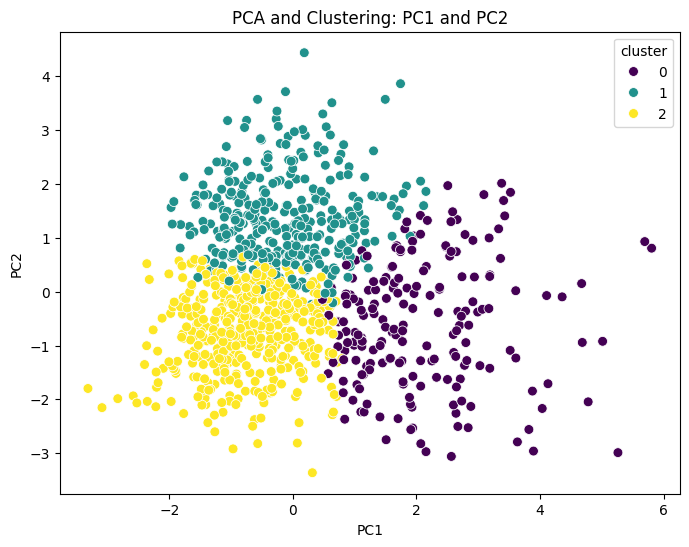

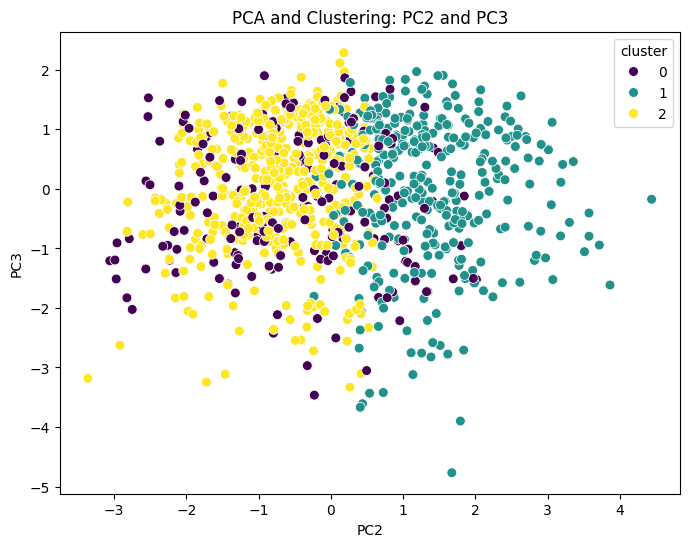

In [48]:
# plot PCA results with clusters
plt.figure(figsize=(8, 6))
# visualizing clusters
sns.scatterplot(
    x='PC1', y='PC2',
    hue='cluster', palette='viridis', data=pca_df, s=50
)

plt.title('PCA and Clustering: PC1 and PC2')
plt.show()

print()
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PC2', y='PC3',
    hue='cluster', palette='viridis', data=pca_df, s=50
)

plt.title('PCA and Clustering: PC2 and PC3')
plt.show()

47


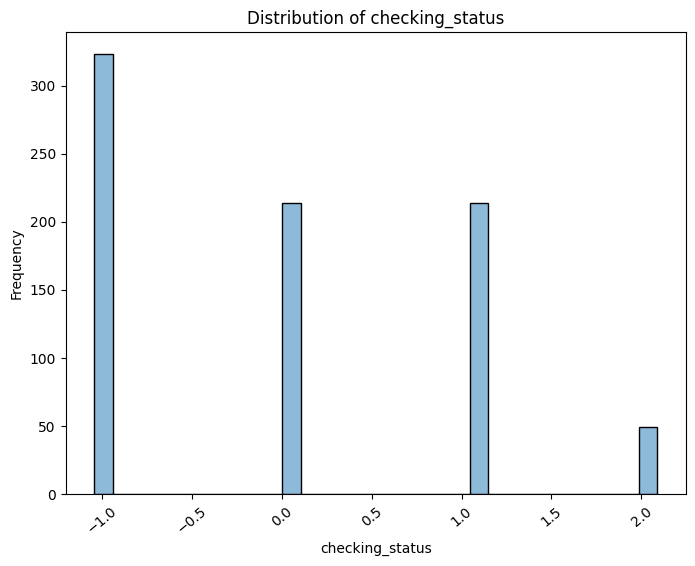

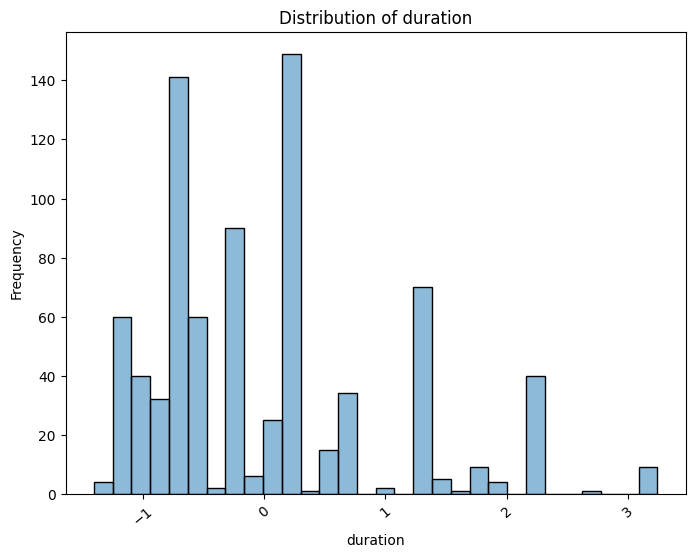

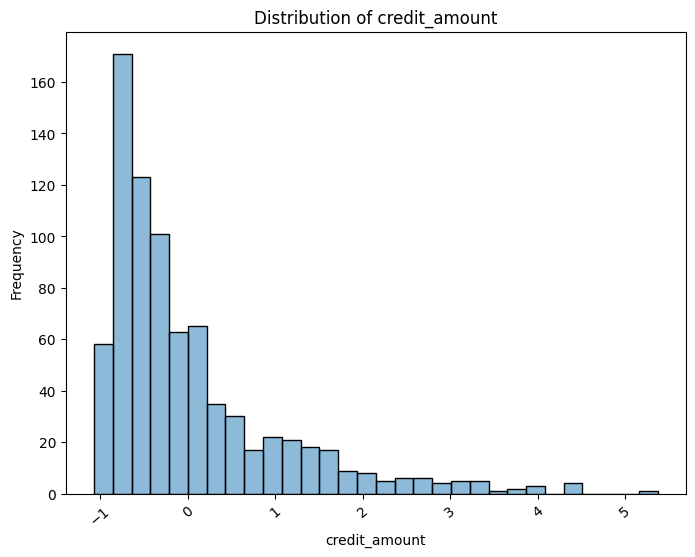

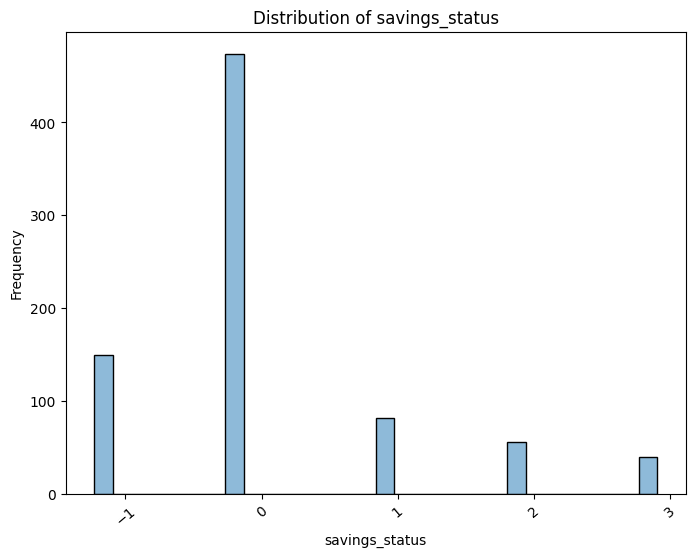

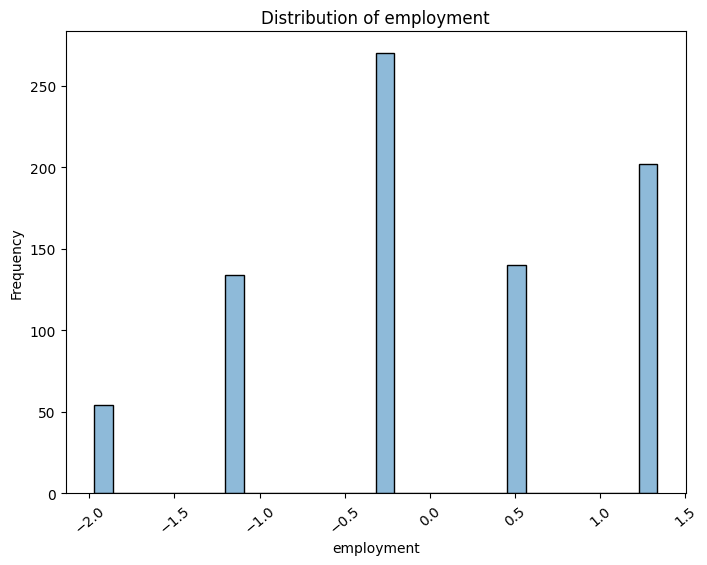

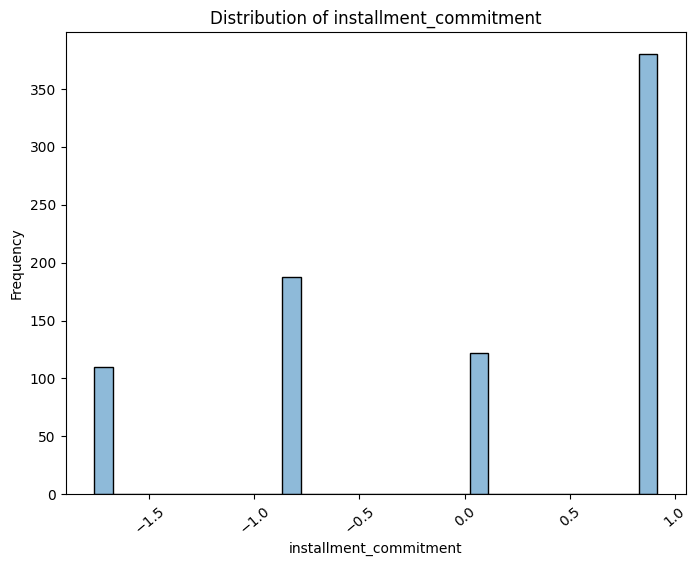

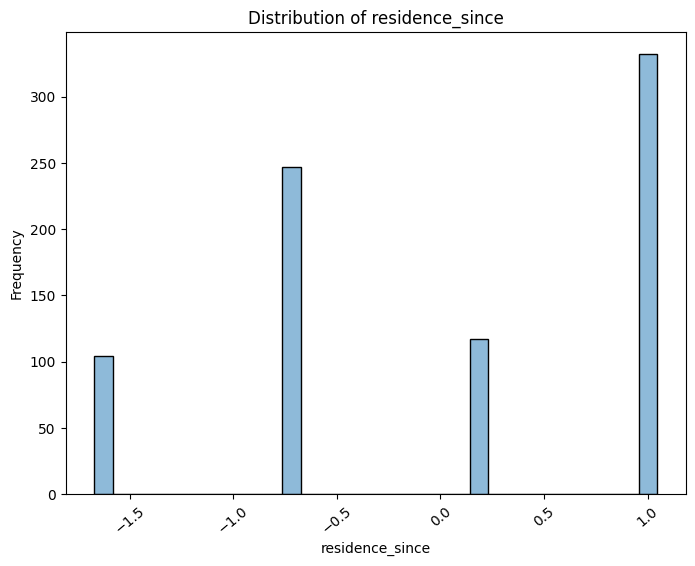

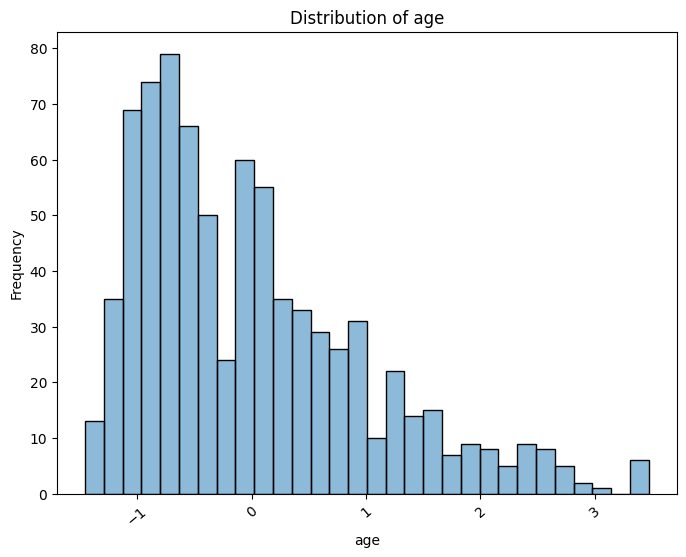

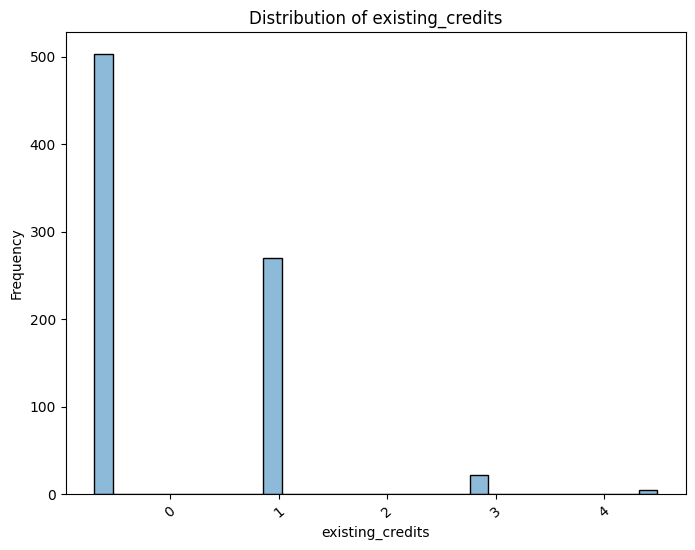

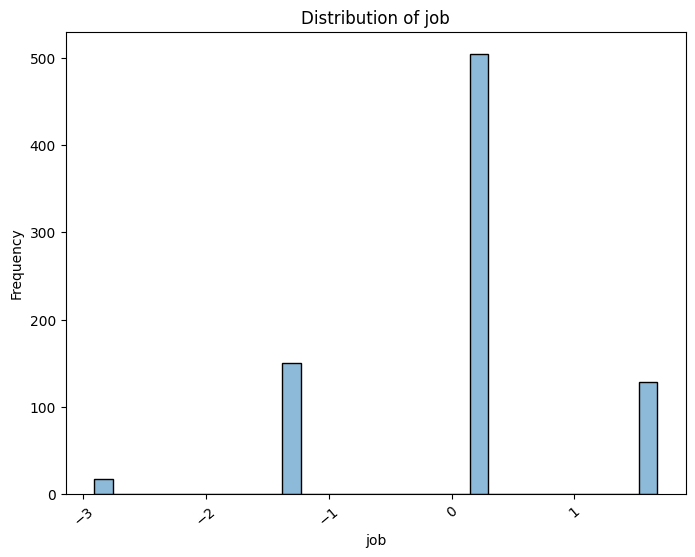

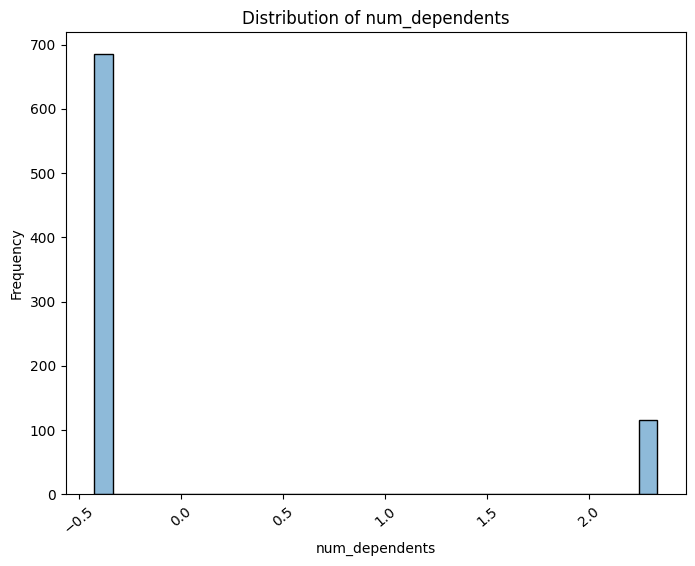

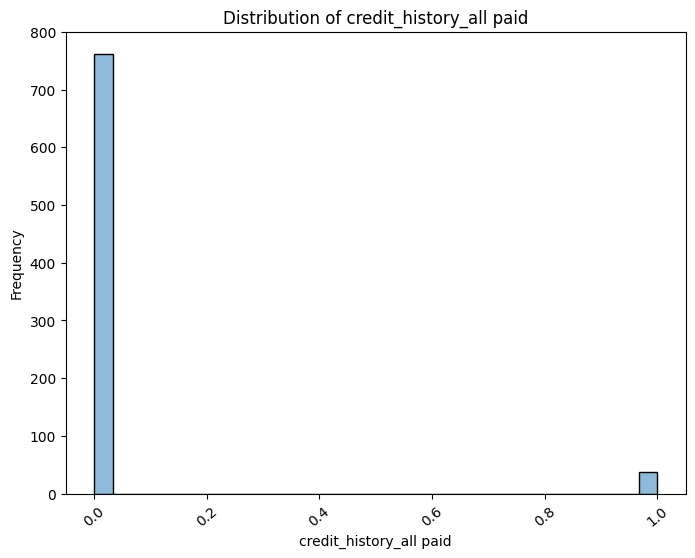

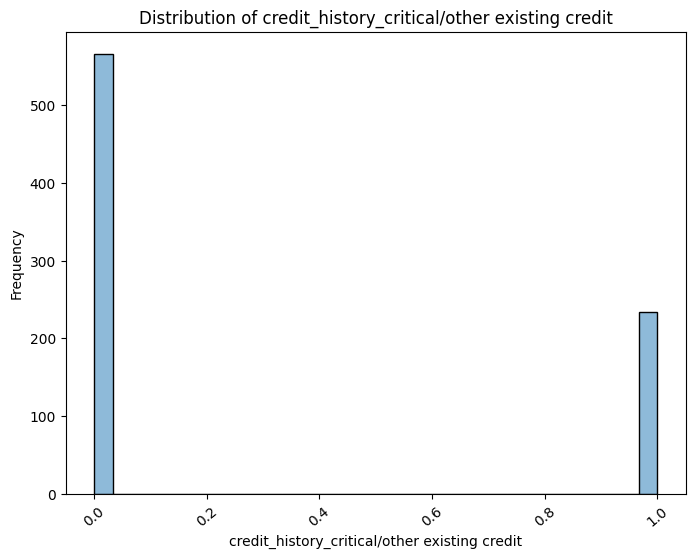

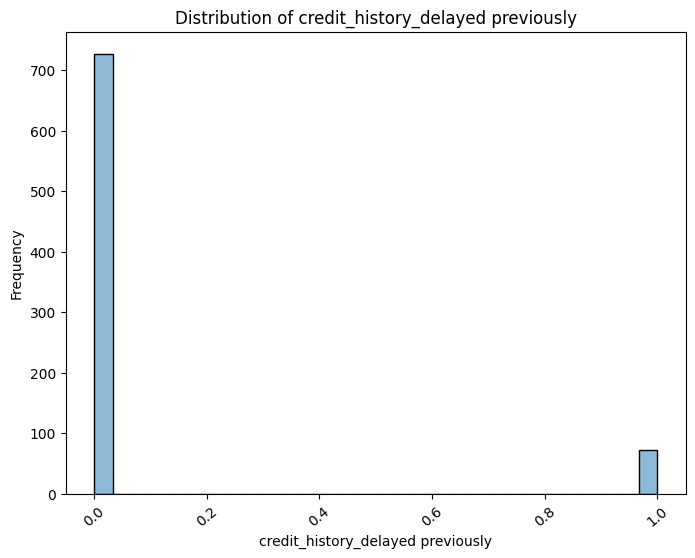

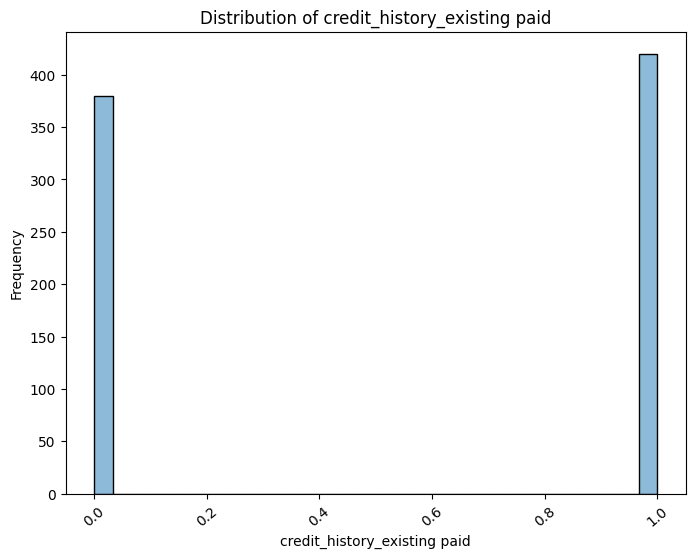

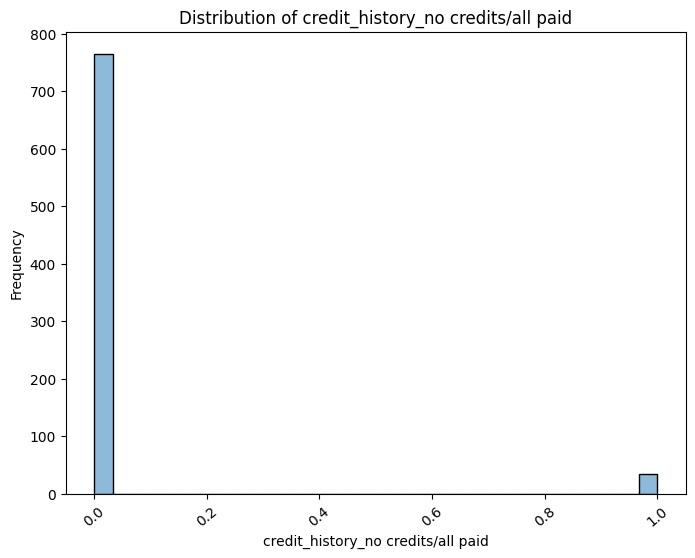

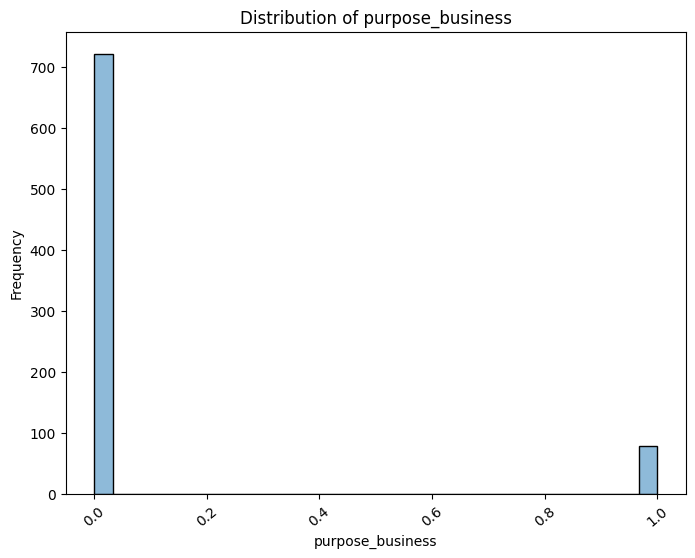

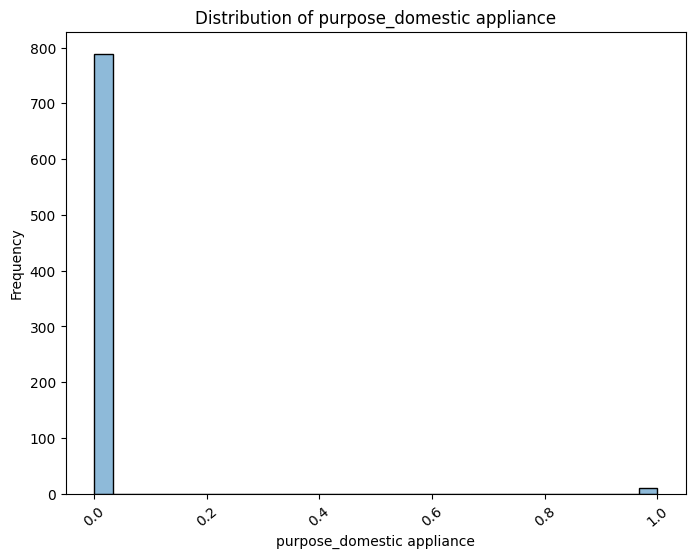

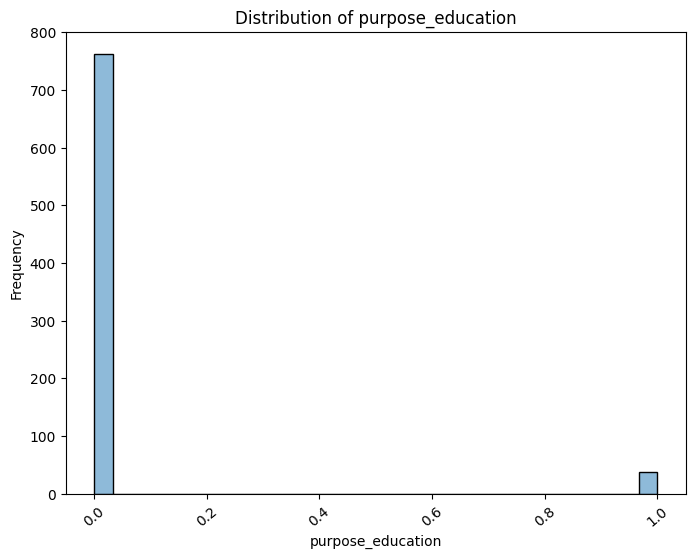

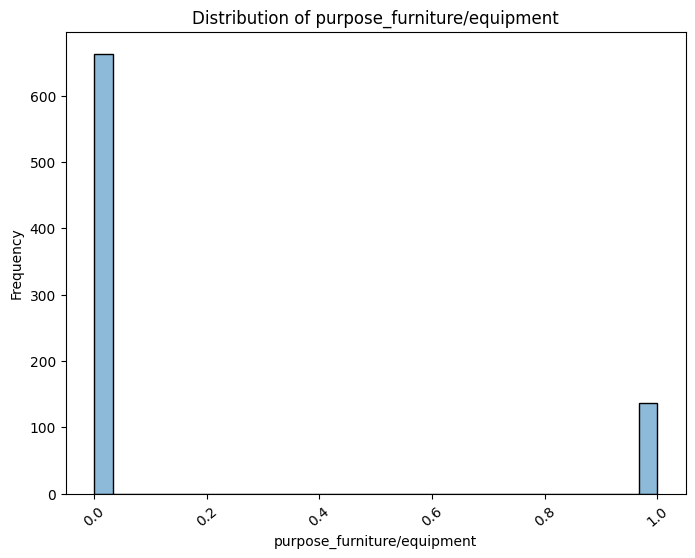

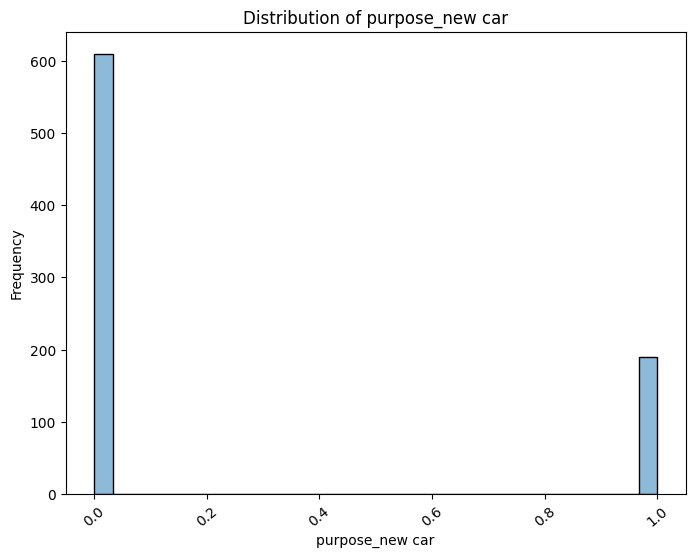

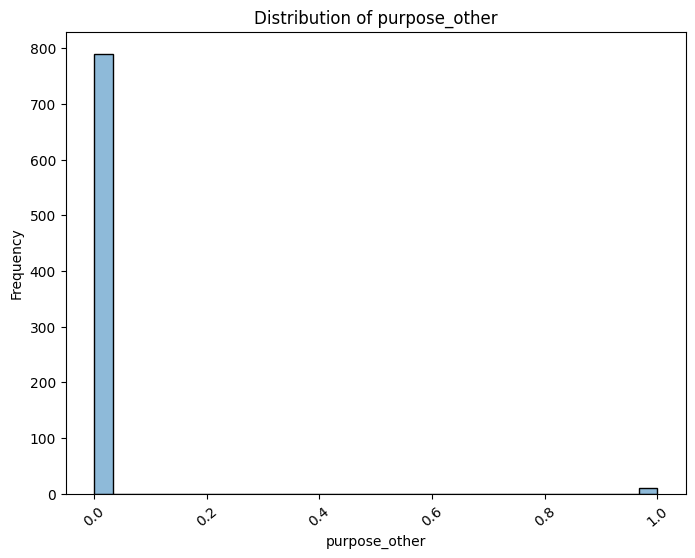

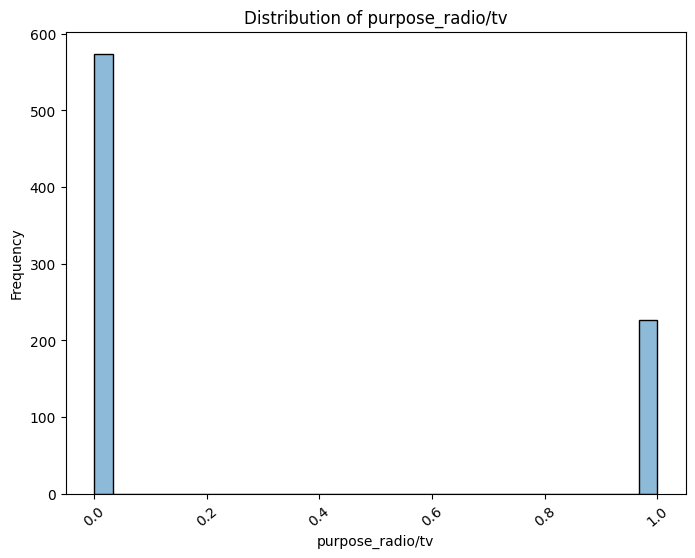

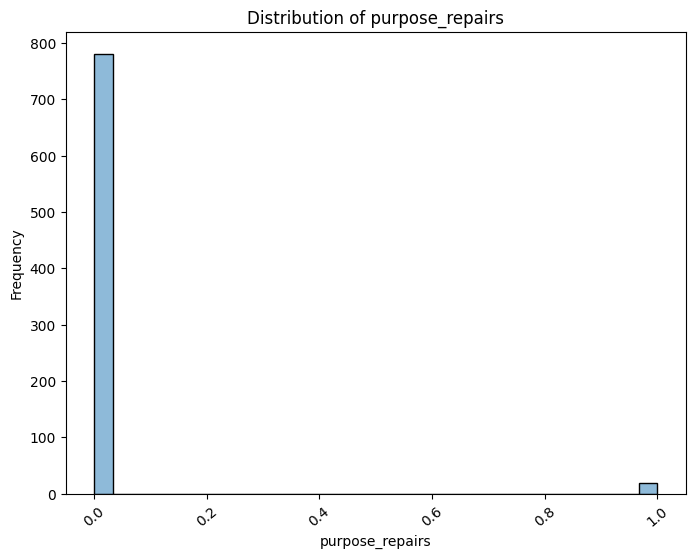

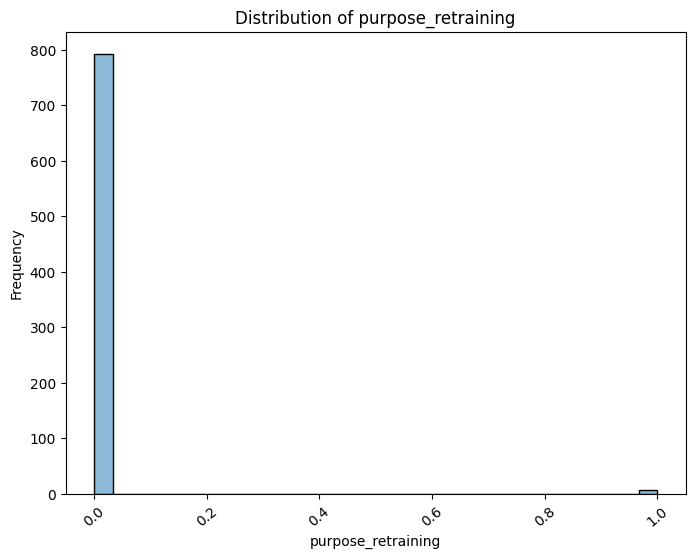

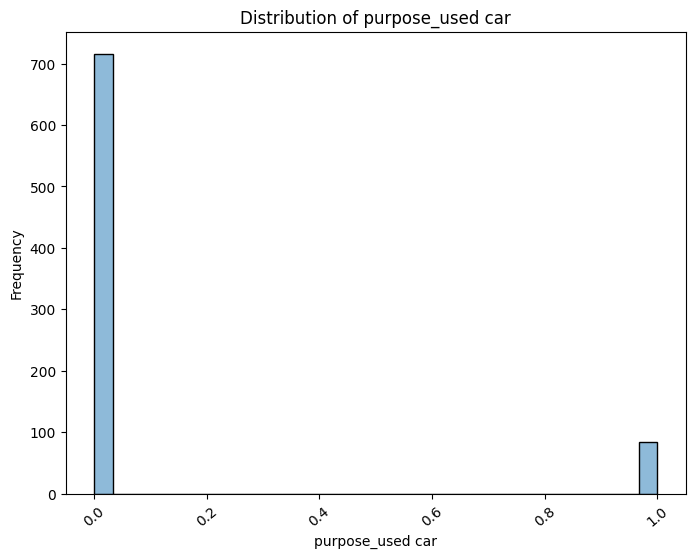

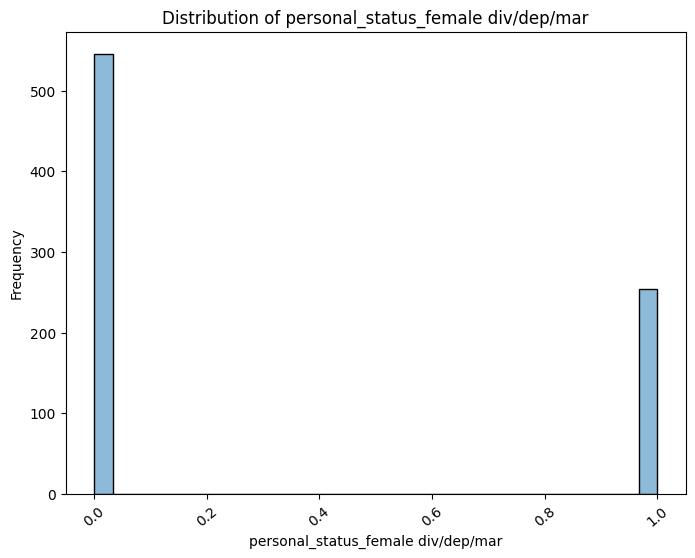

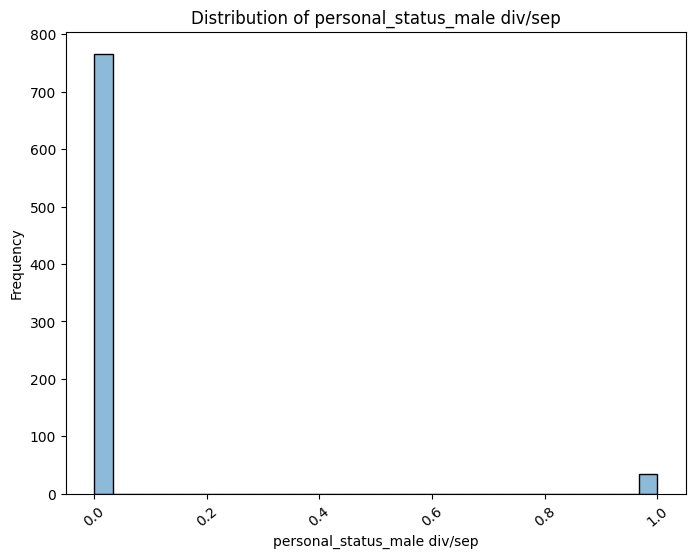

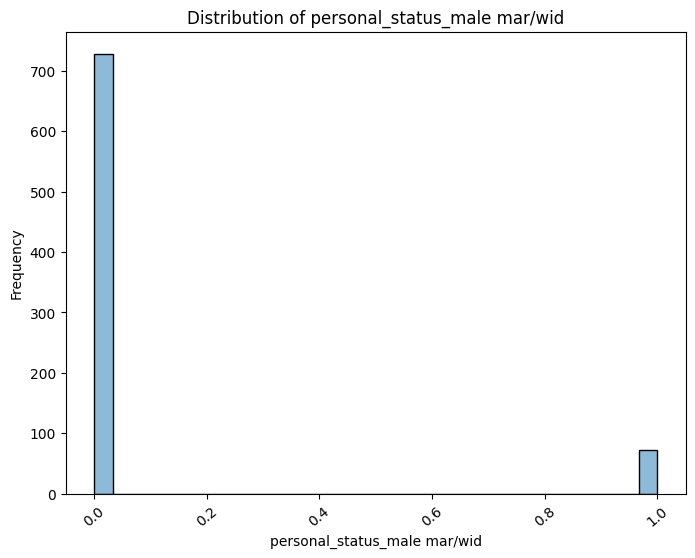

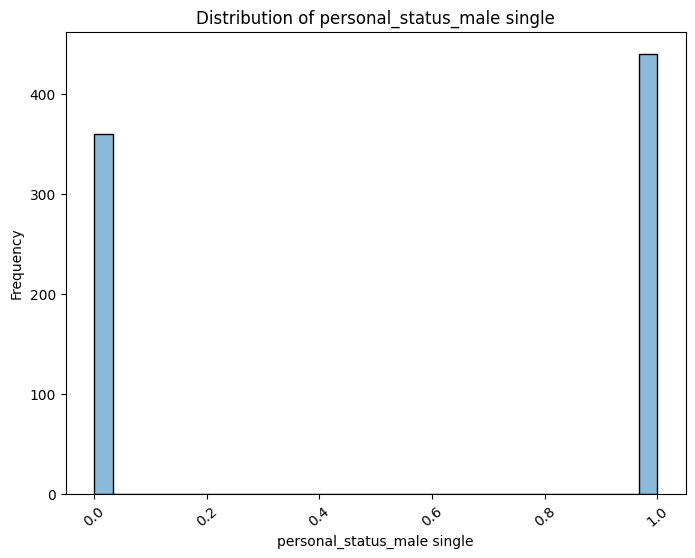

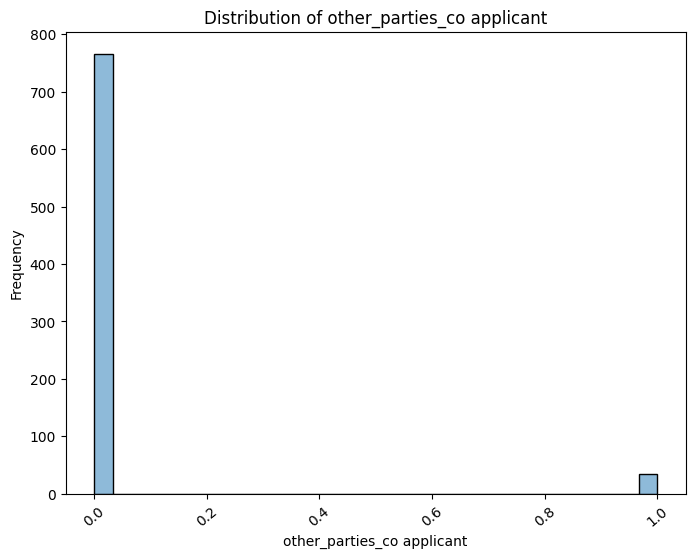

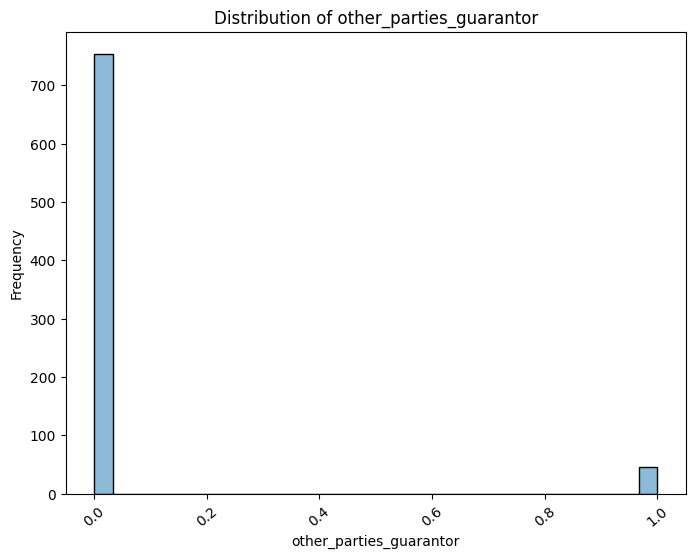

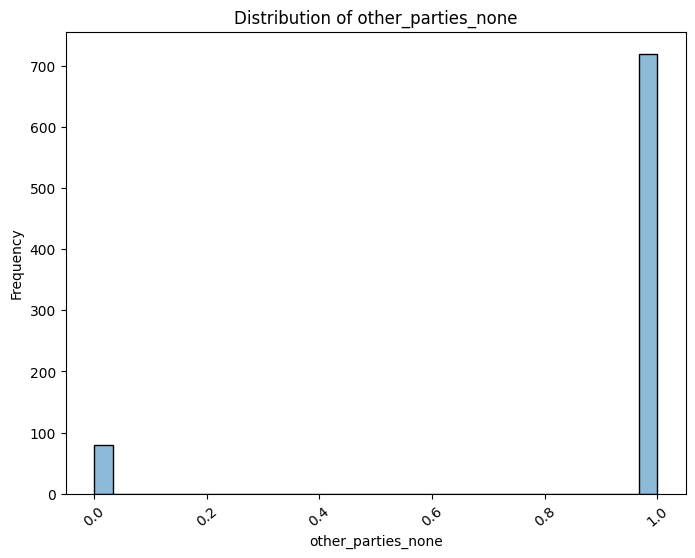

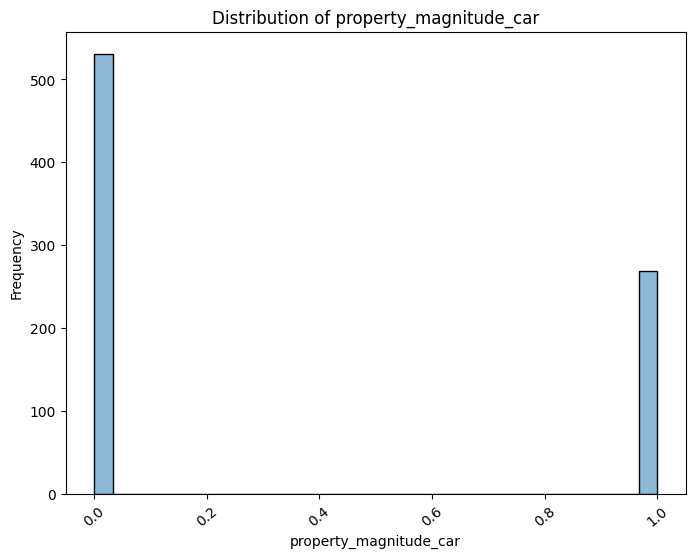

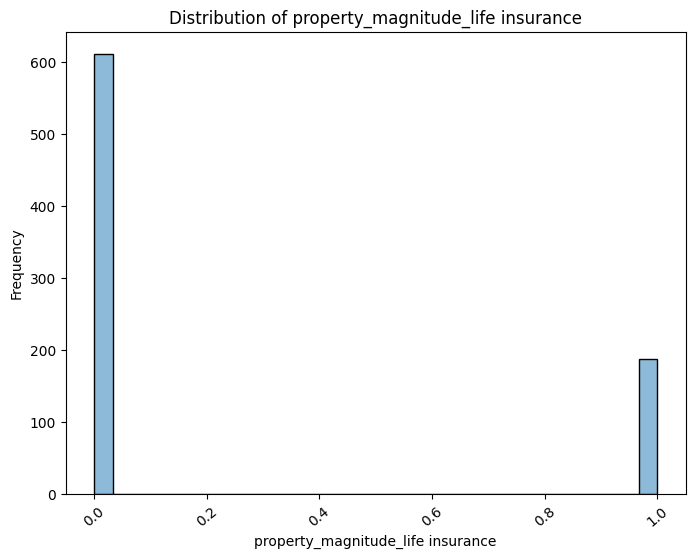

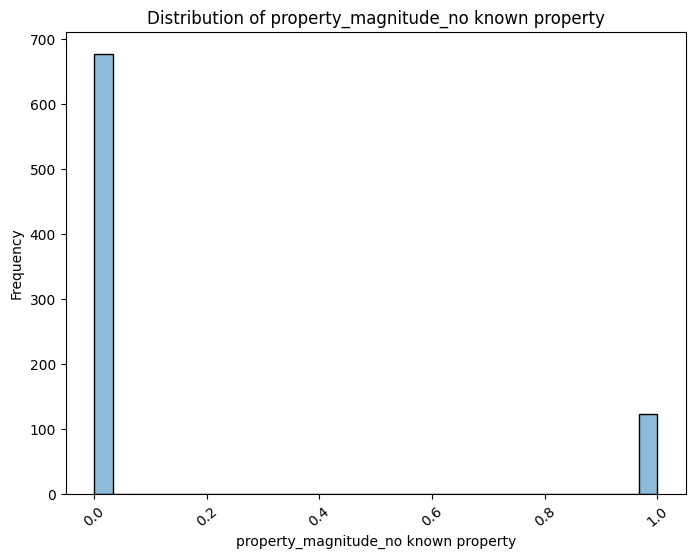

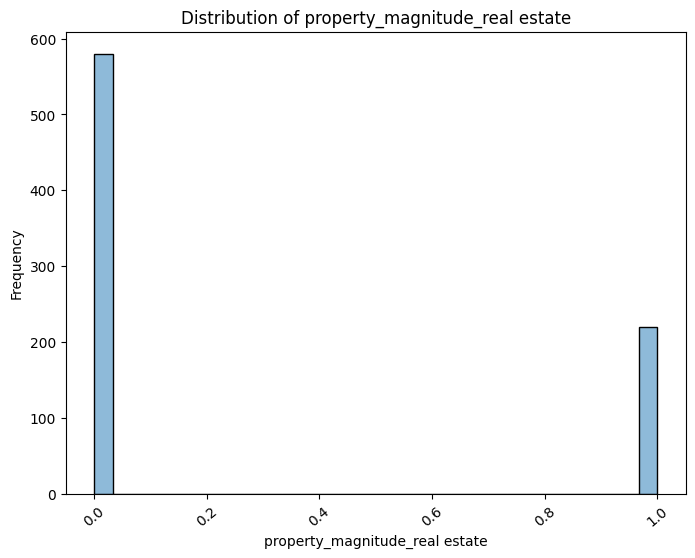

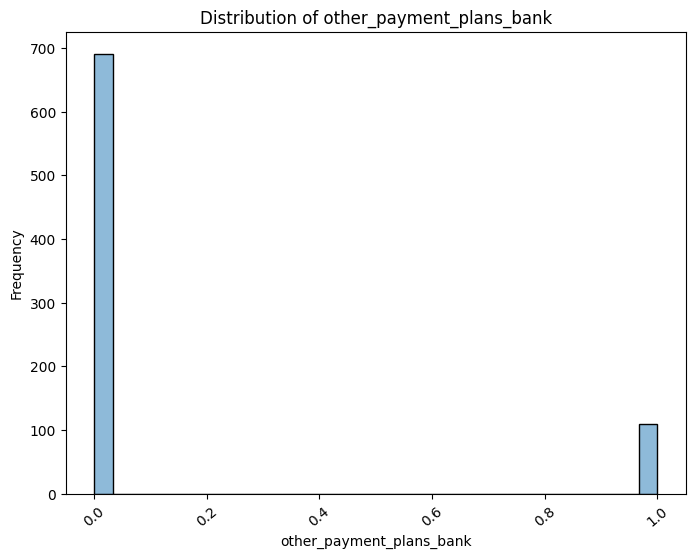

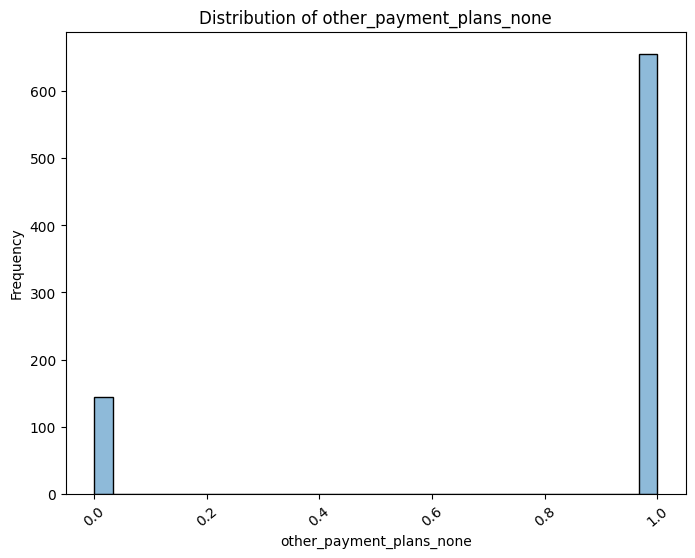

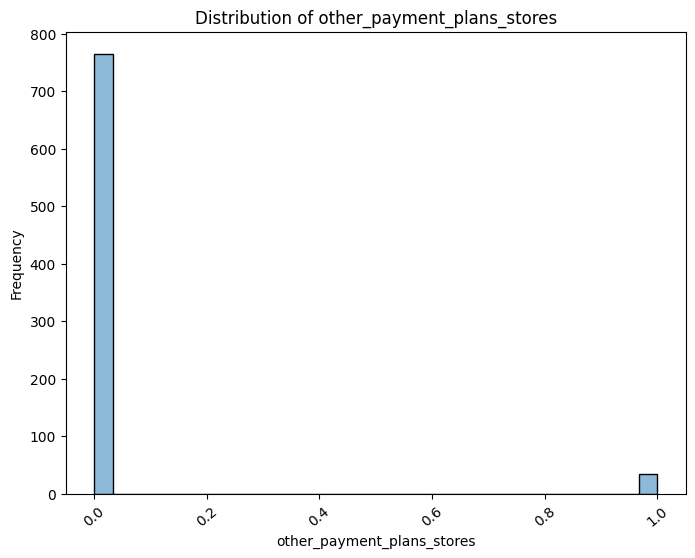

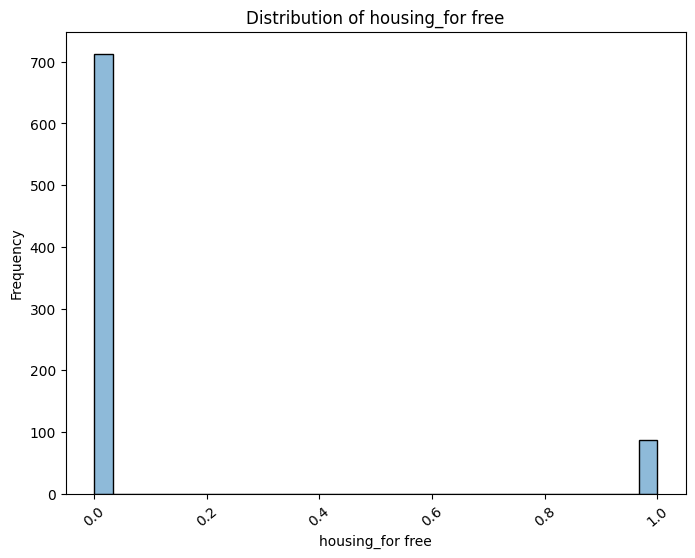

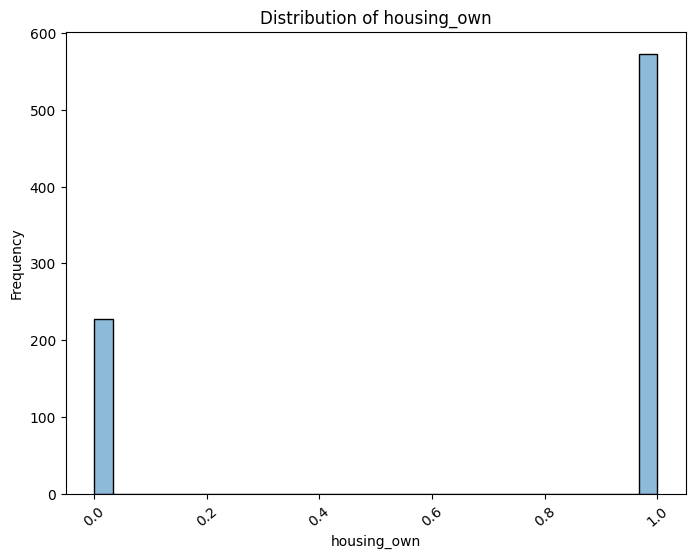

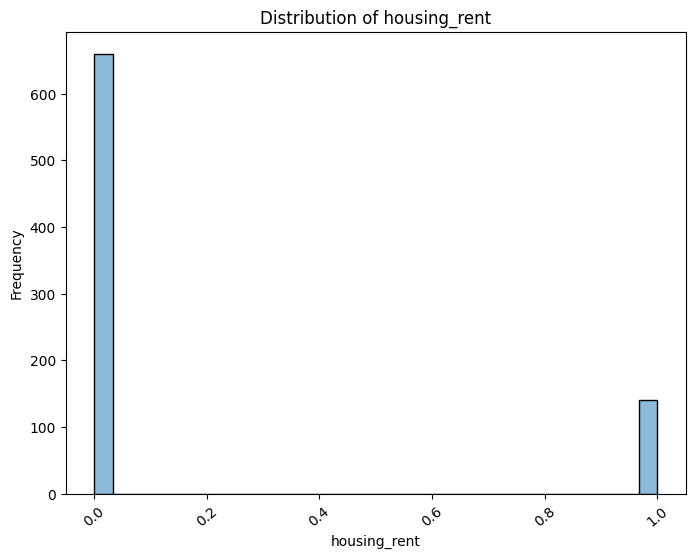

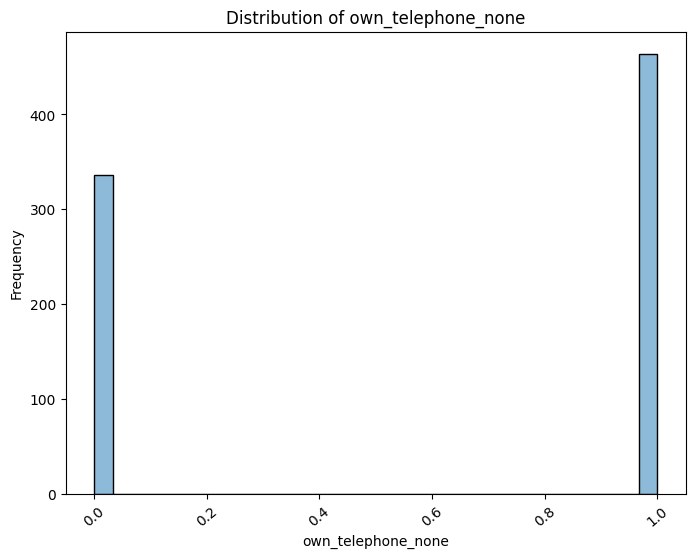

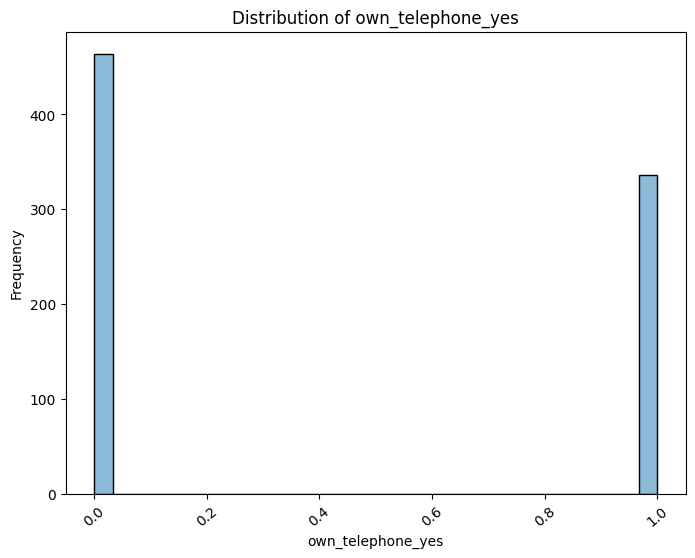

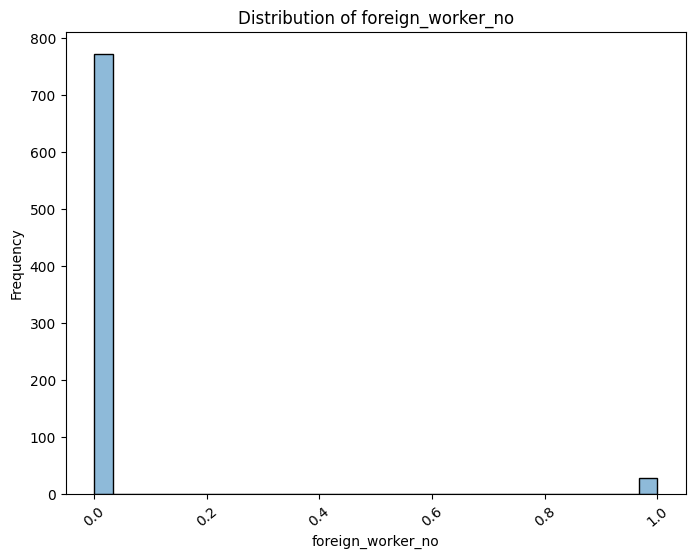

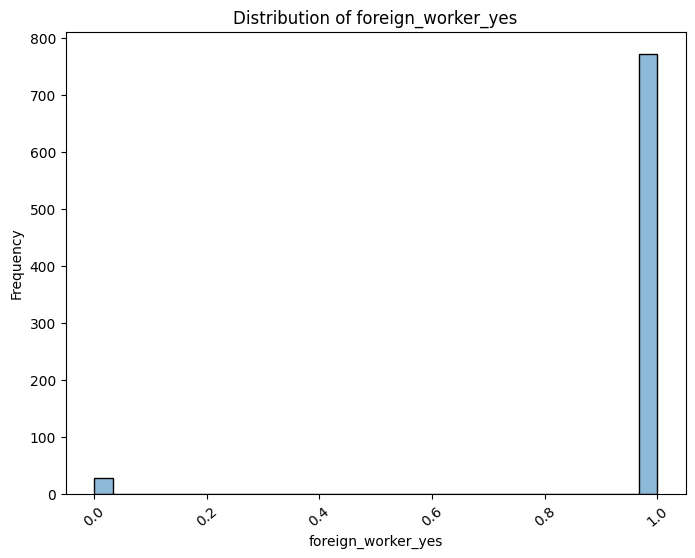

In [49]:
# Visualizing individual features
print(len(X_train.columns))
for feature in X_train.columns:
  plt.figure(figsize=(8,6))
  sns.histplot(X_train[feature],kde=False,bins=30, alpha=0.5)
  plt.xlabel(feature)
  plt.xticks(rotation=40)
  plt.ylabel("Frequency")
  plt.title(f"Distribution of {feature}")
  plt.show()
  print()

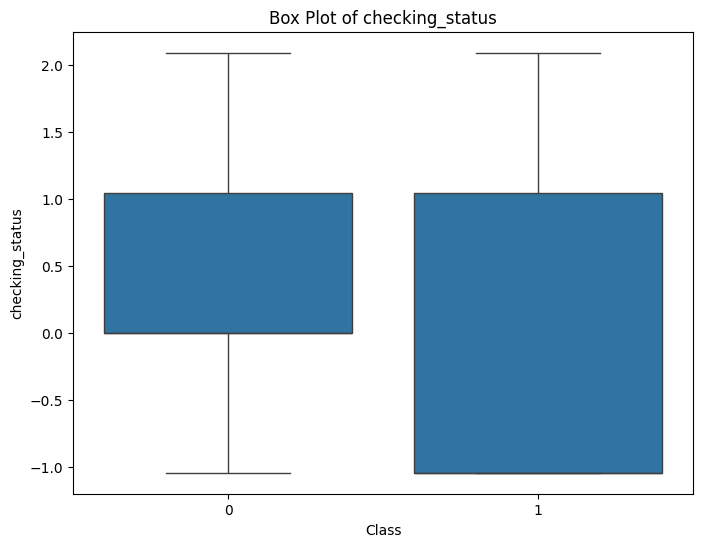

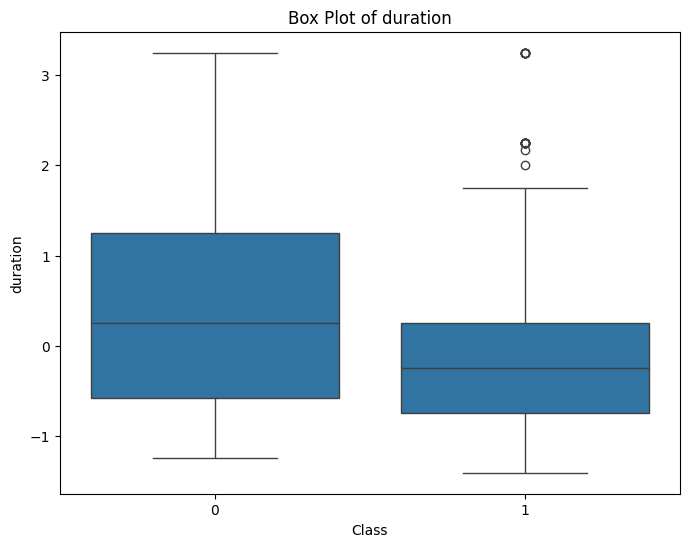

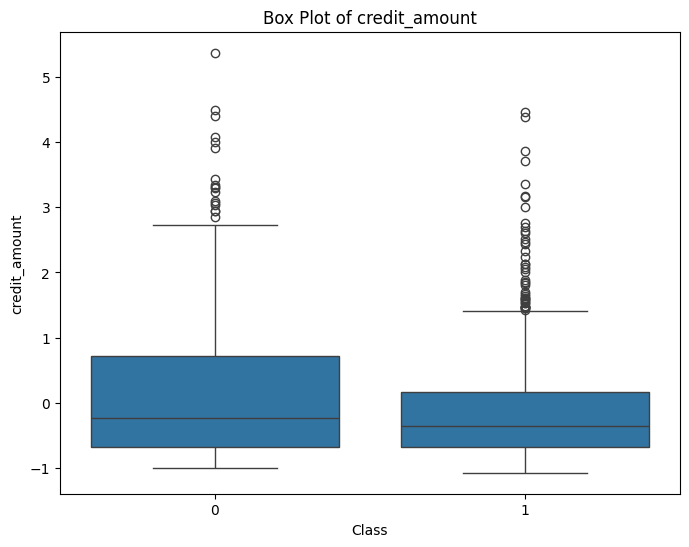

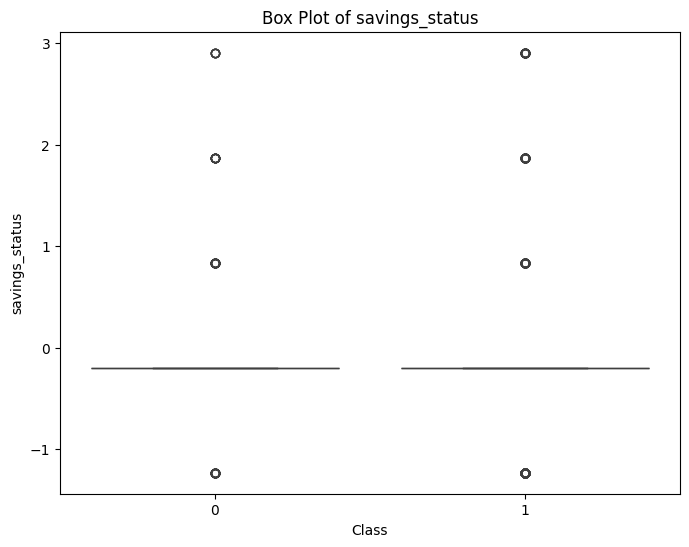

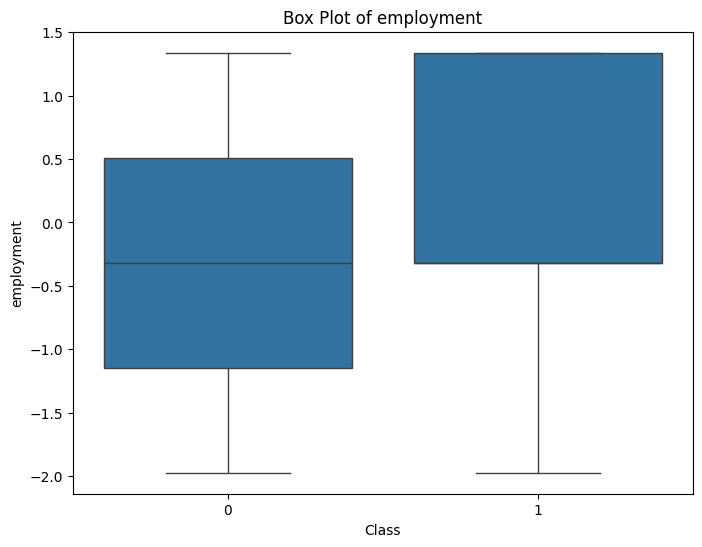

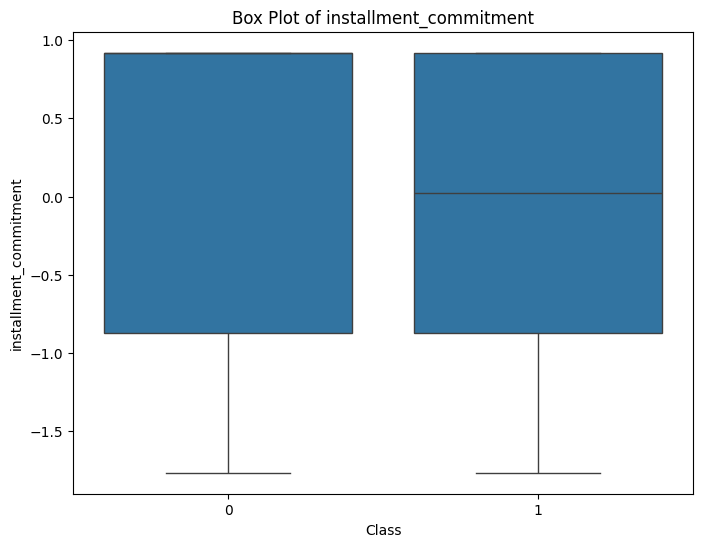

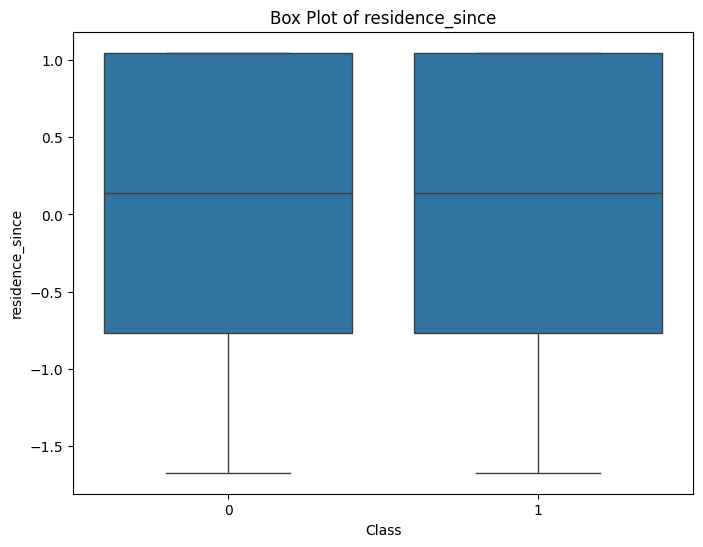

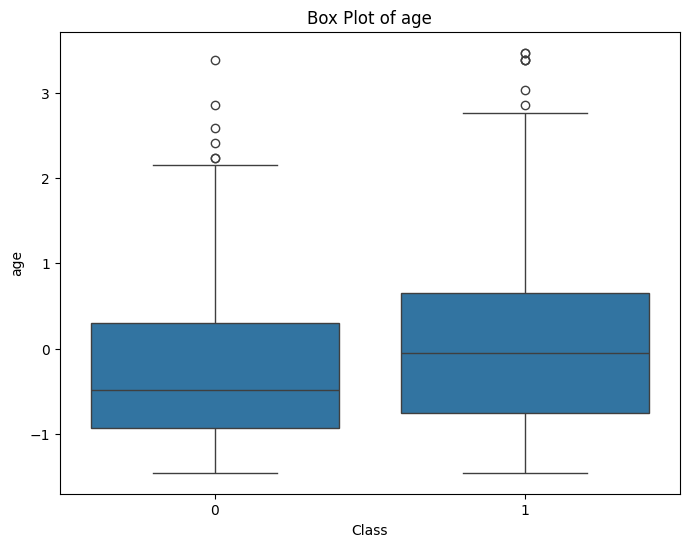

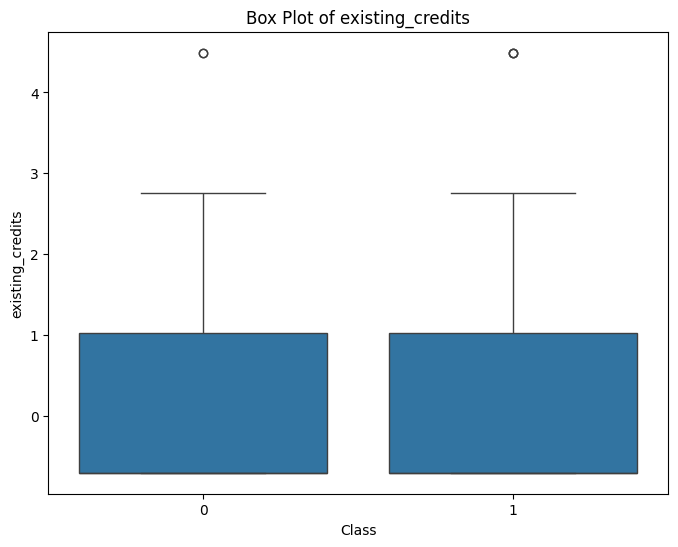

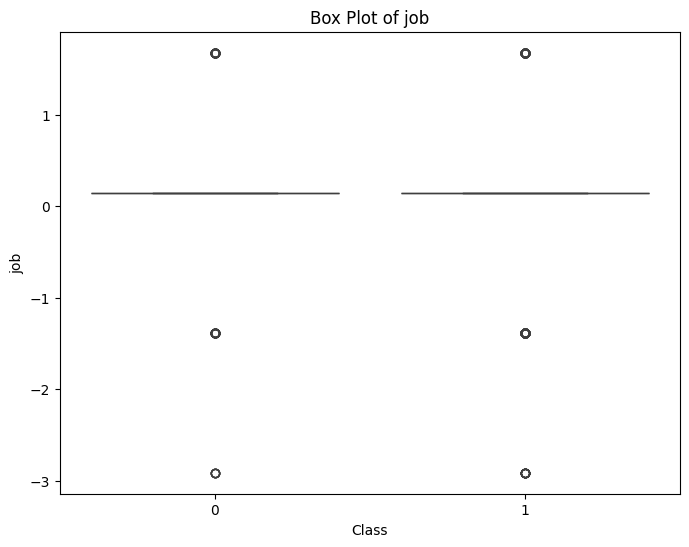

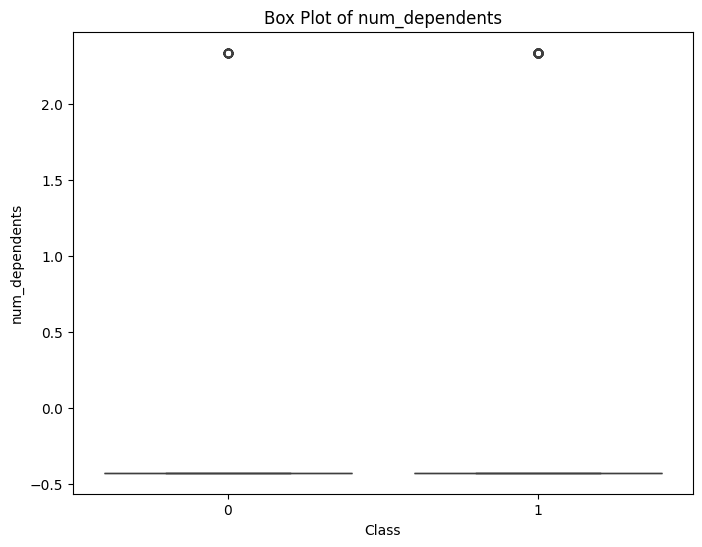

In [10]:
numerical_features = X_train.select_dtypes(include=['number'])

# For numerical features, we are using a box plot to show its relationship to the target variable
for feature in numerical_features.columns:
  plt.figure(figsize=(8,6))
  sns.boxplot(y=X_train[feature],x=y_train)
  plt.ylabel(feature)
  plt.xlabel("Class")
  plt.title(f"Box Plot of {feature}")
  plt.show()

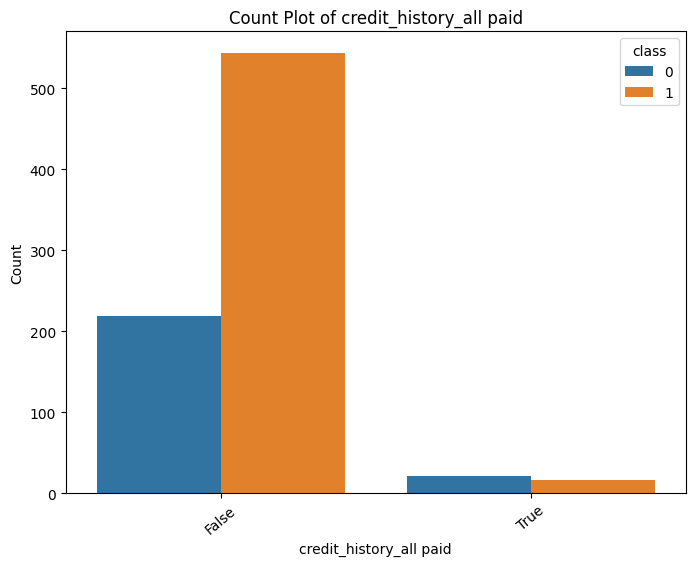

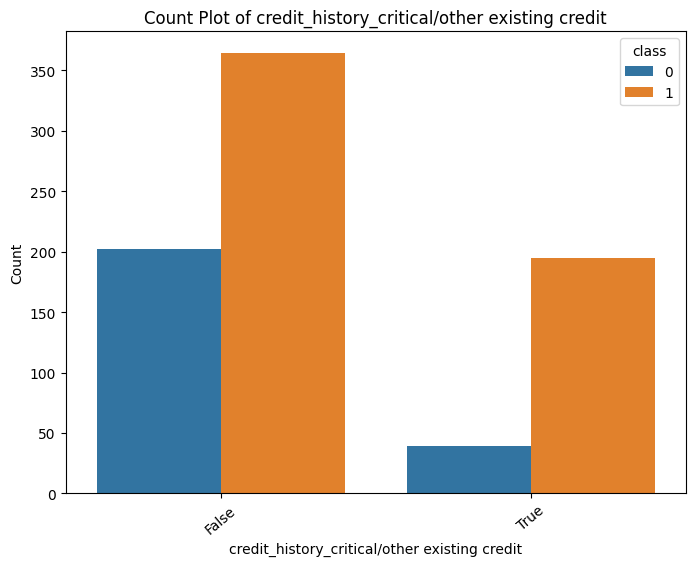

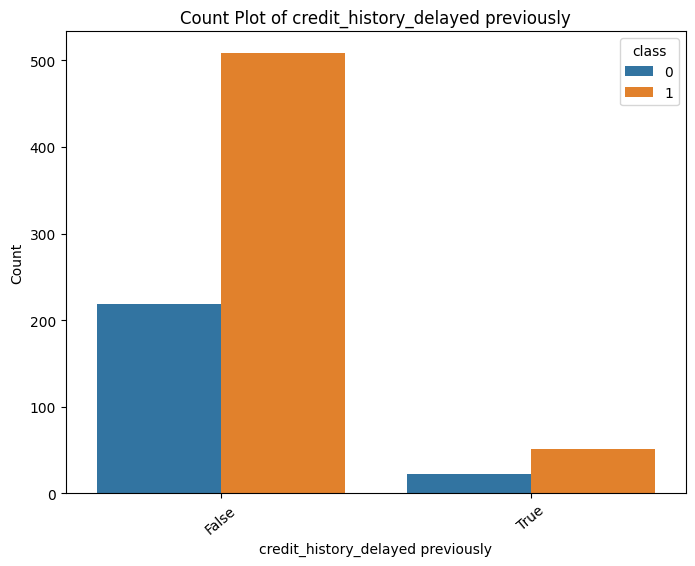

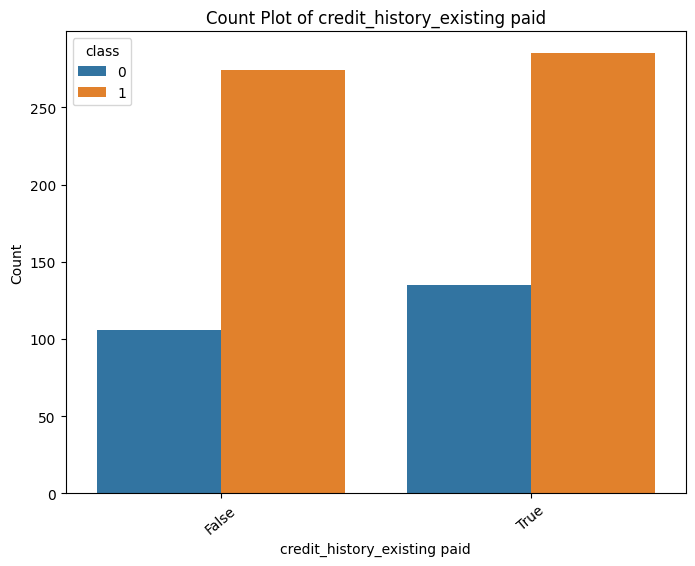

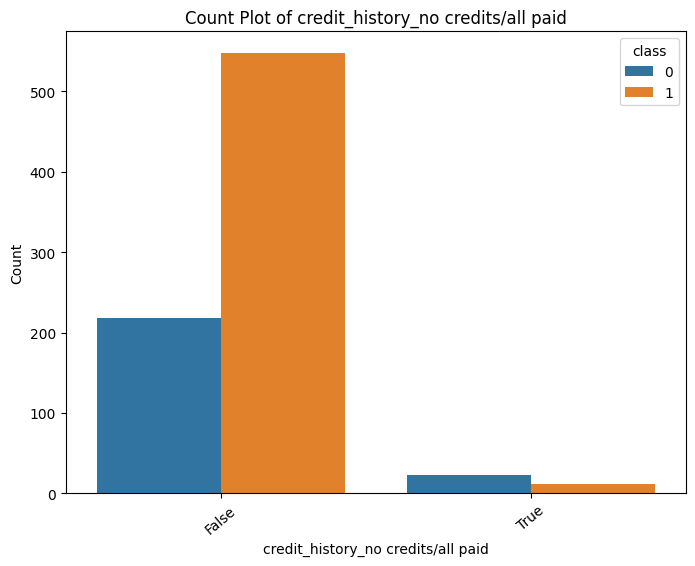

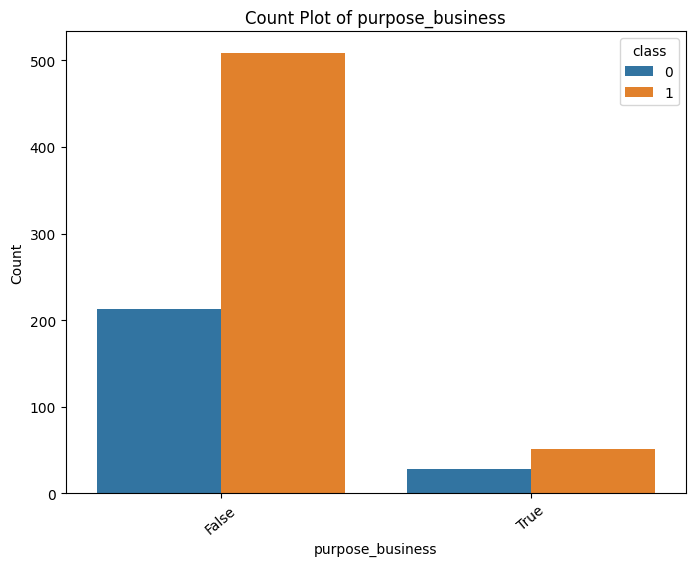

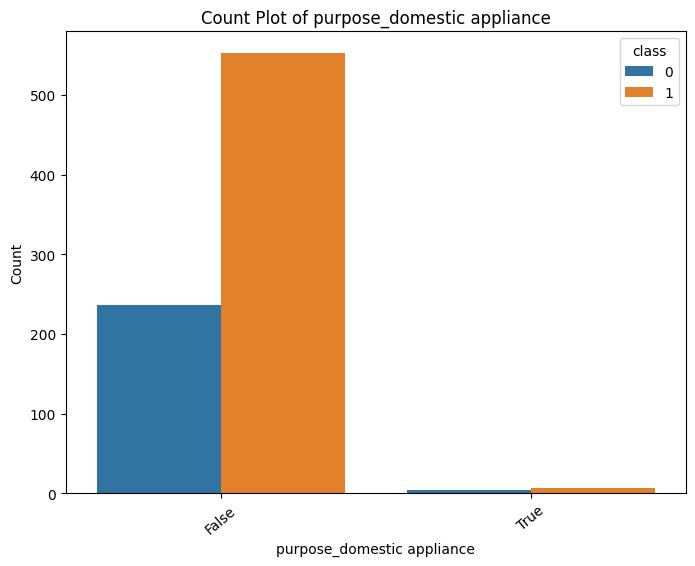

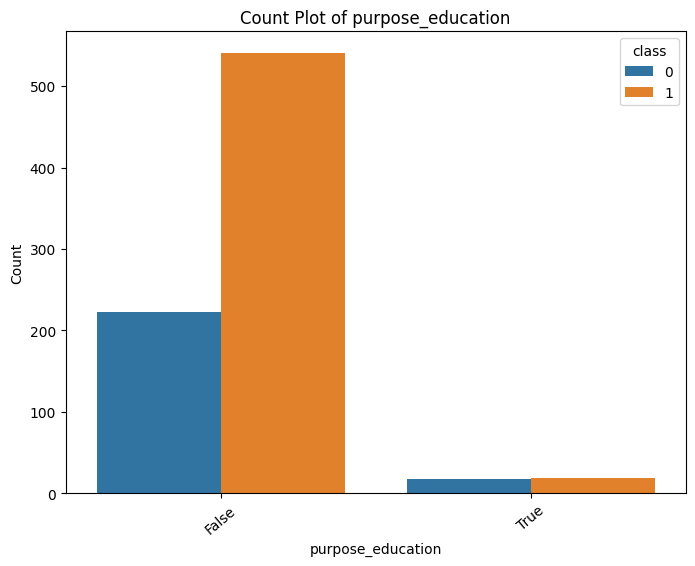

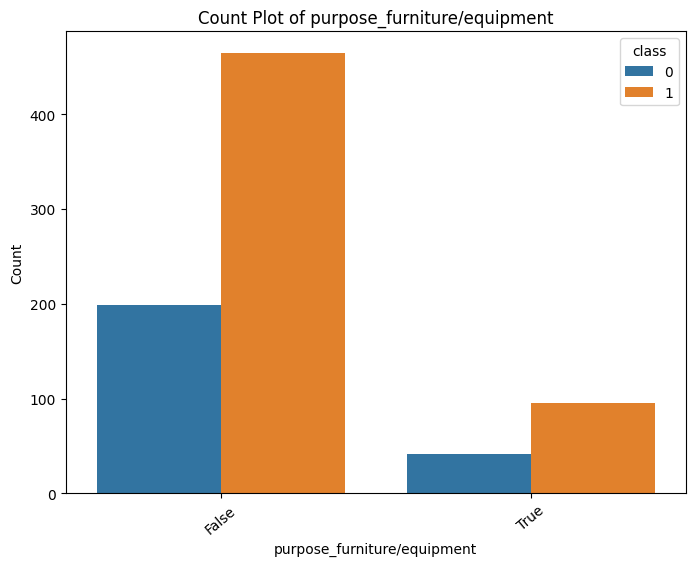

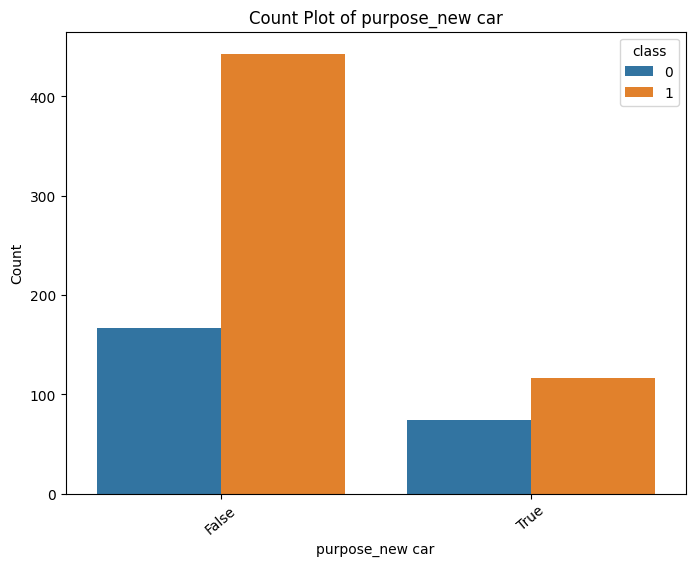

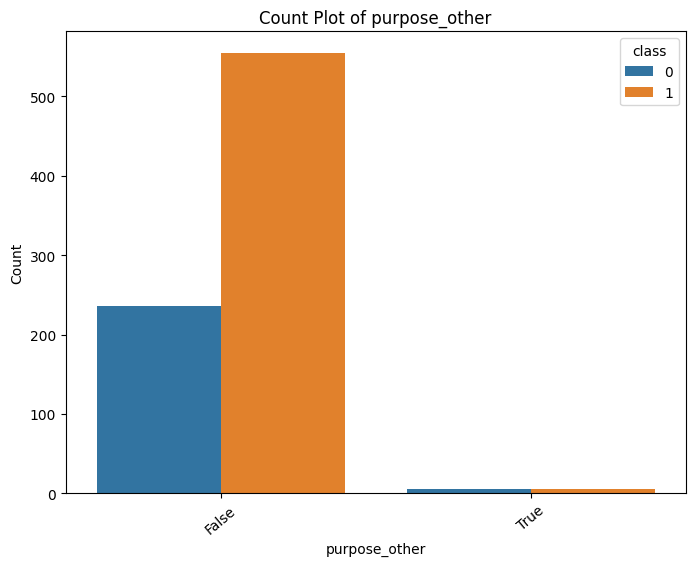

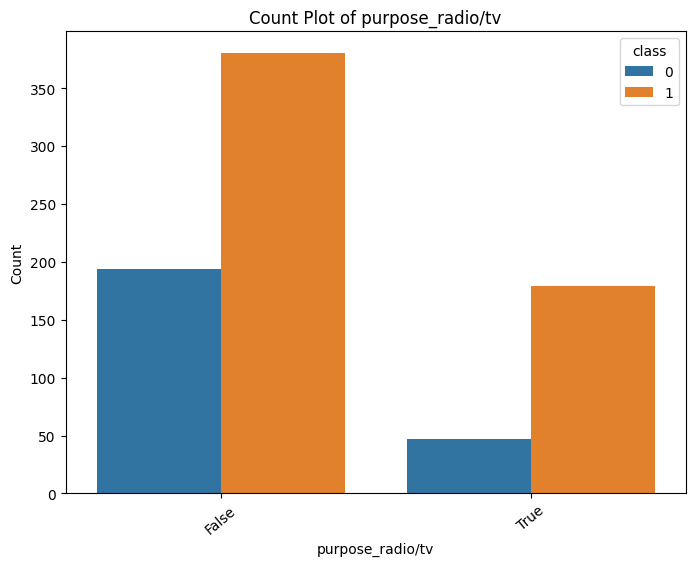

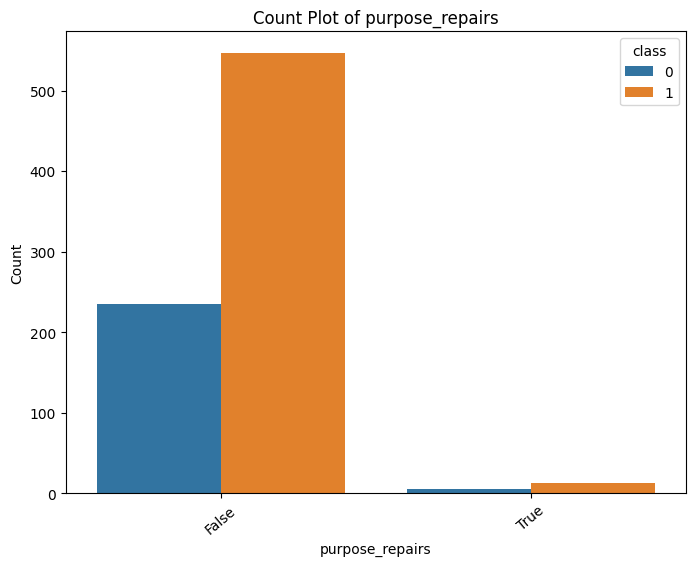

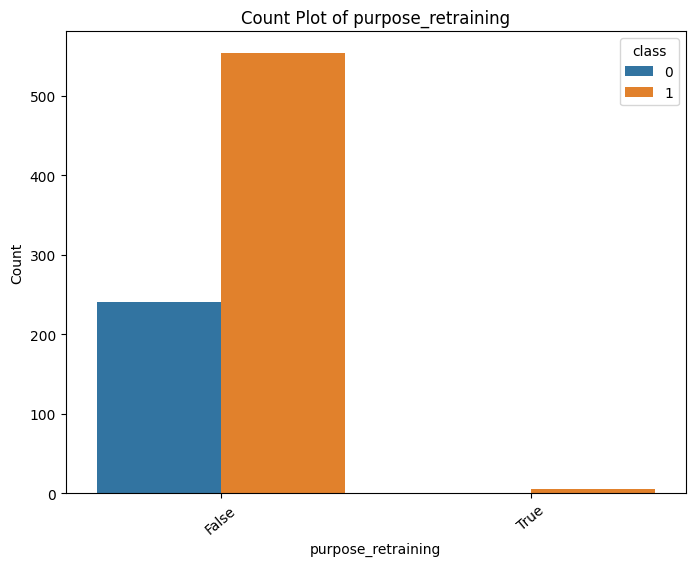

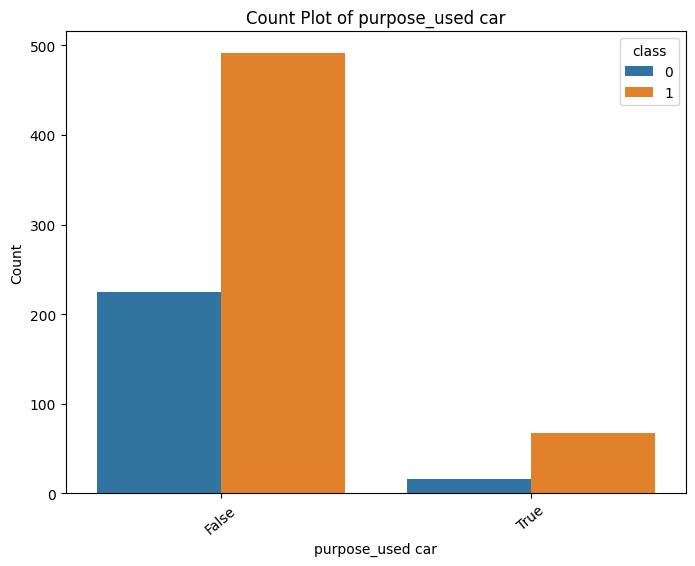

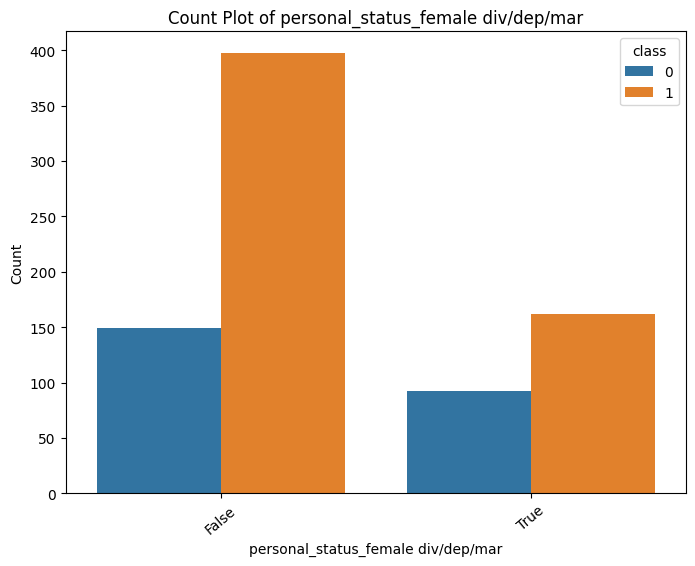

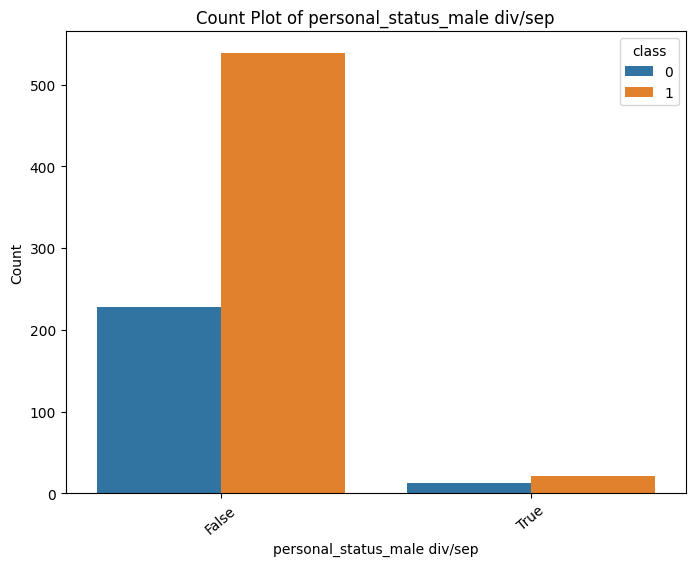

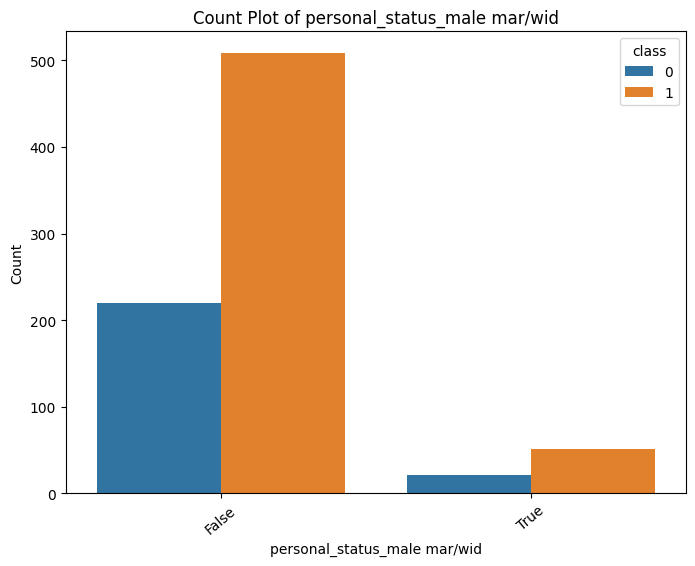

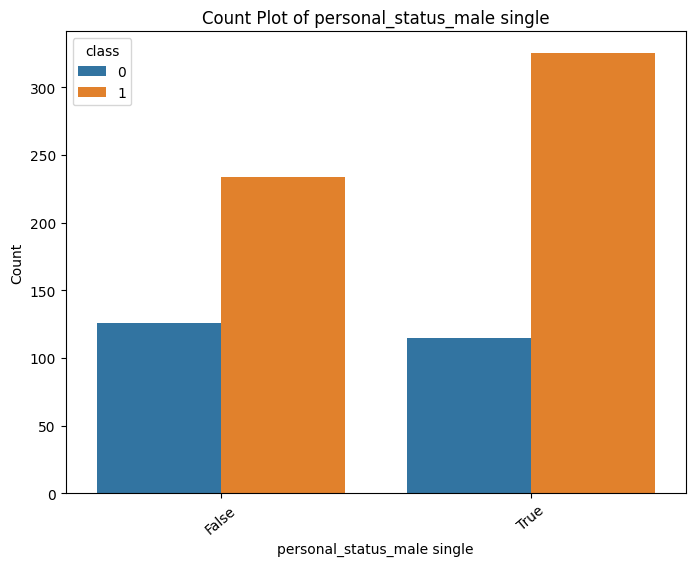

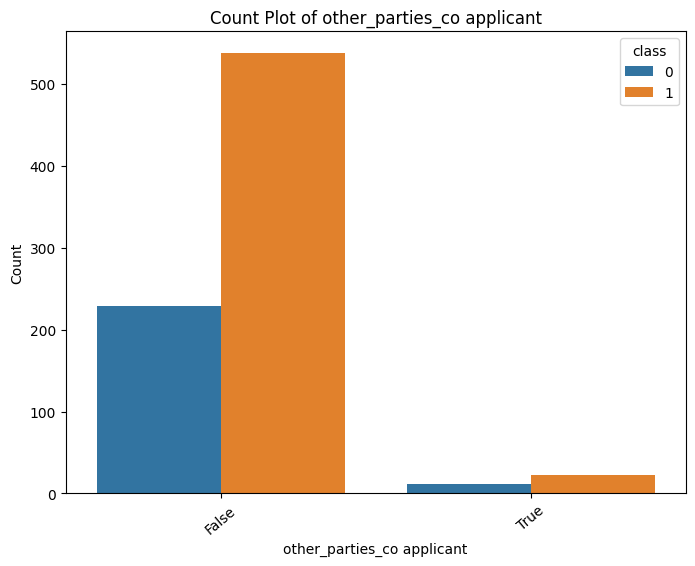

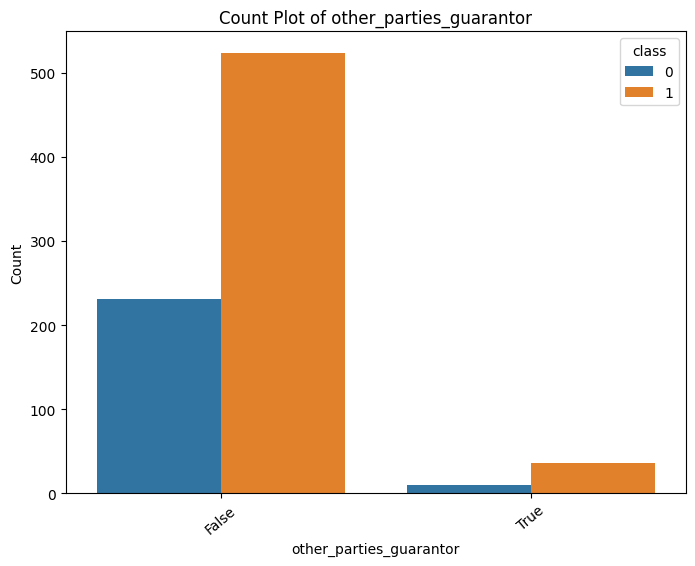

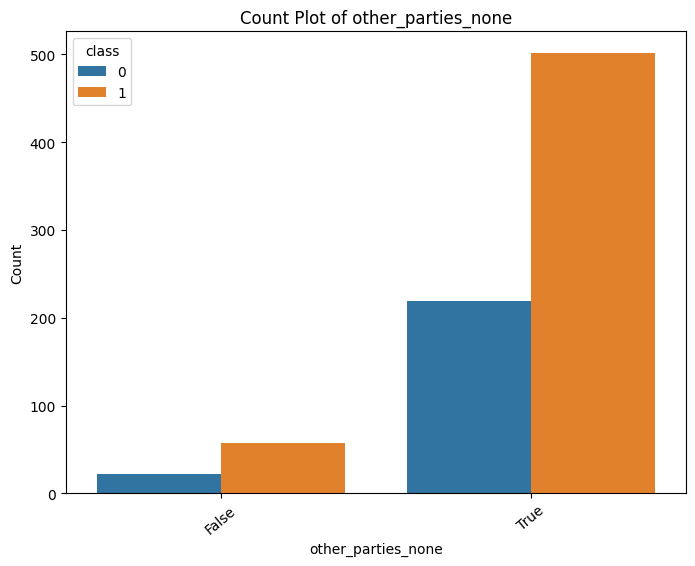

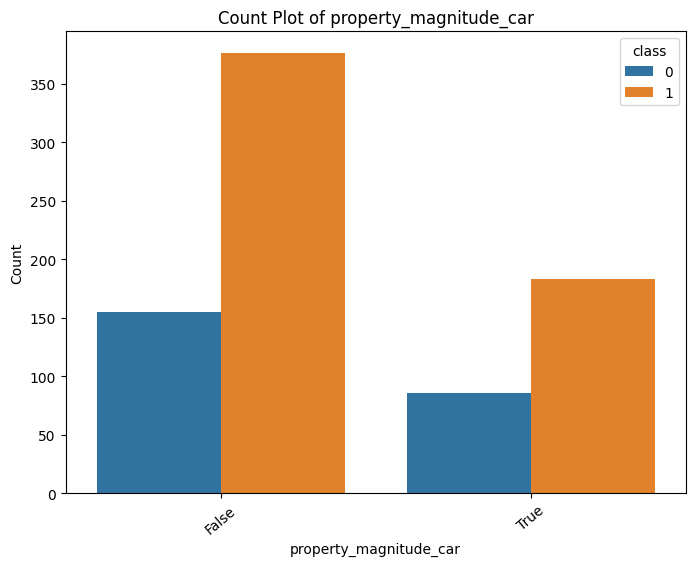

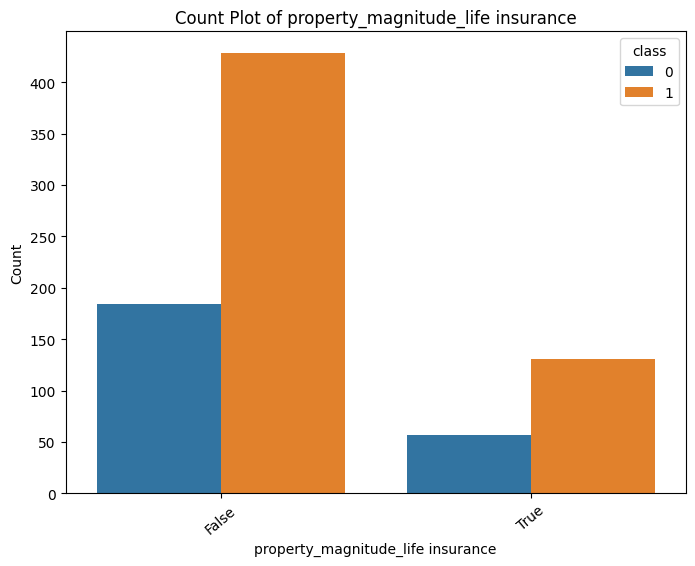

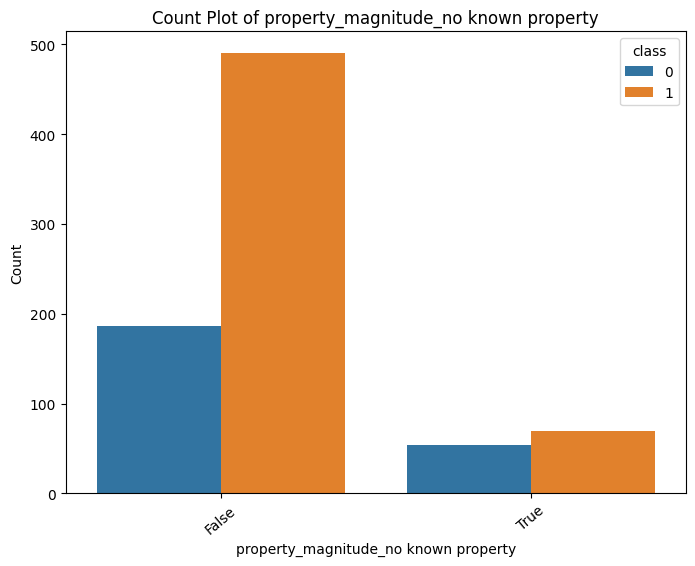

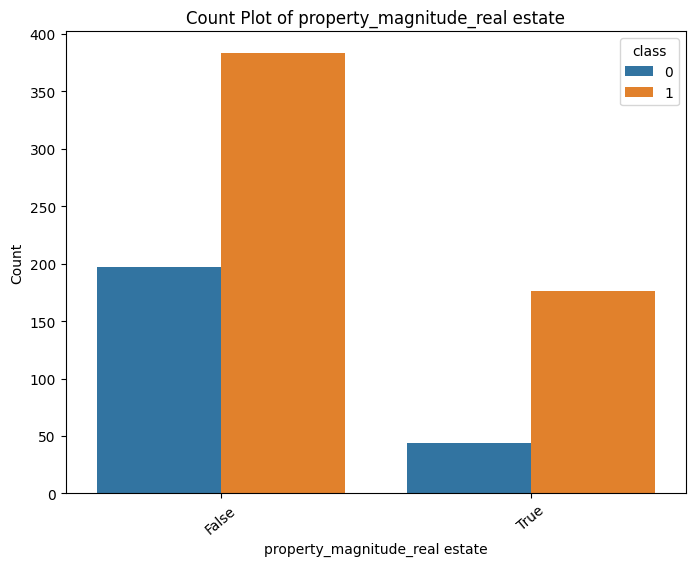

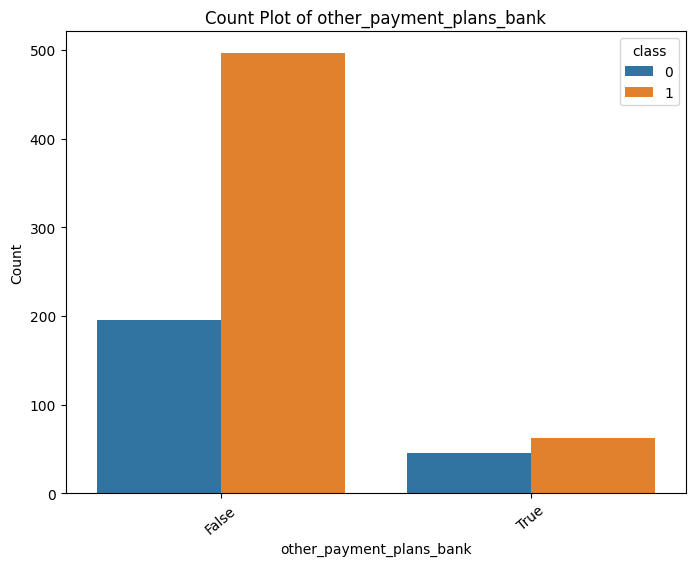

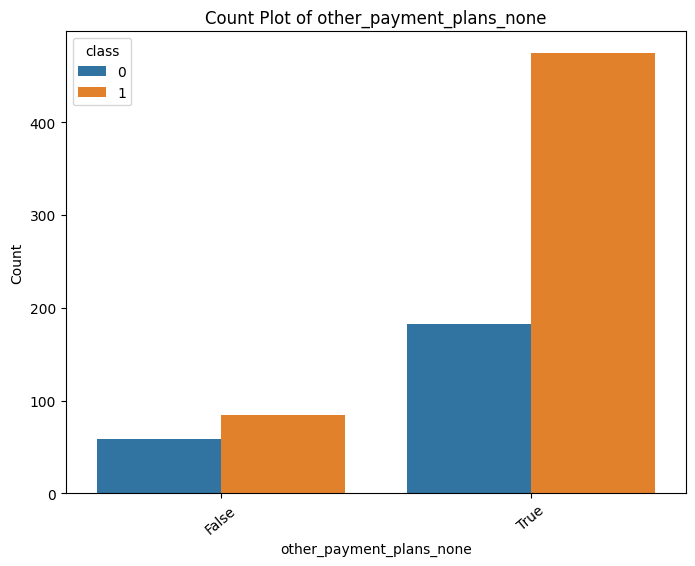

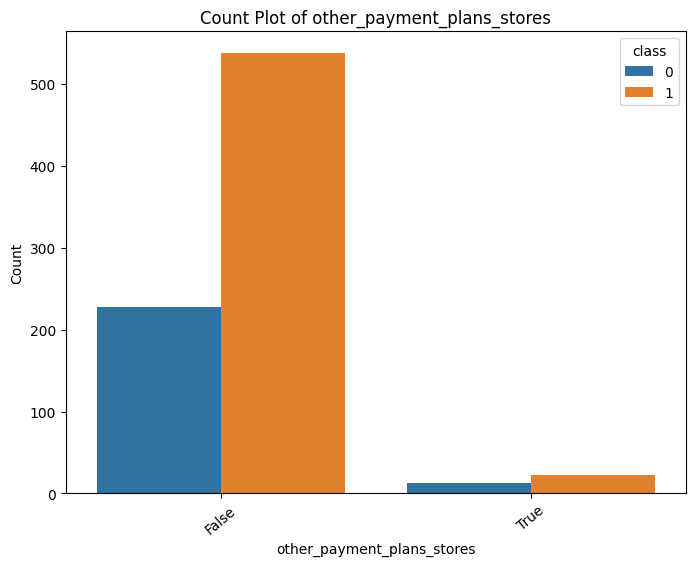

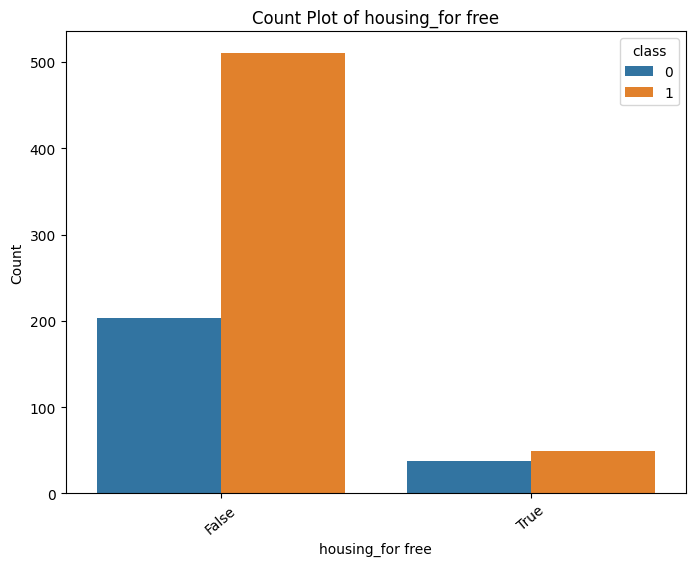

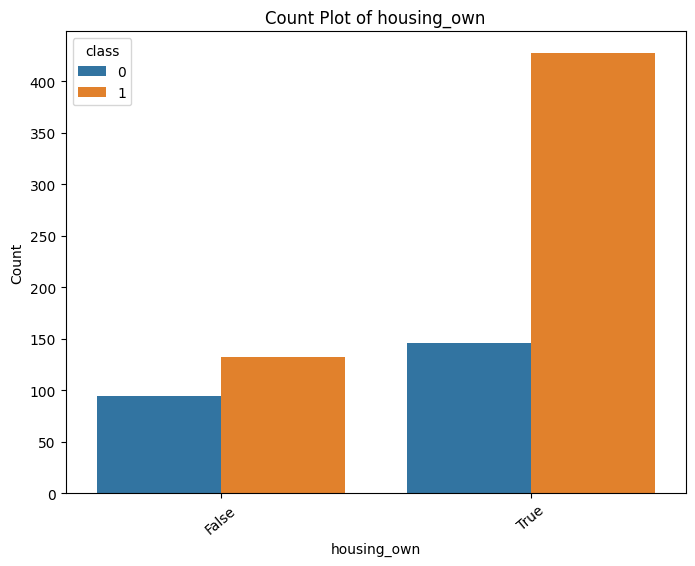

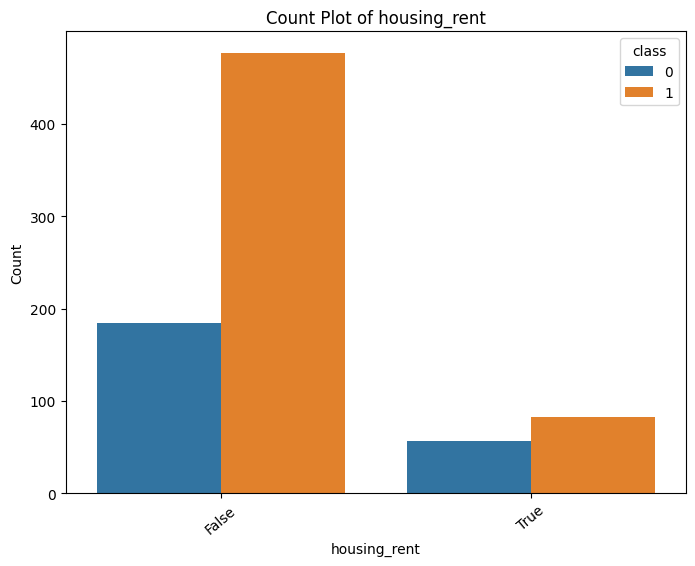

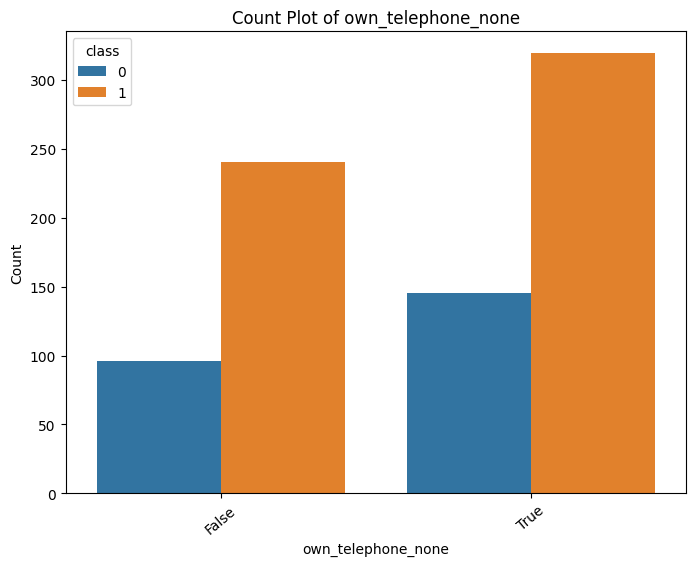

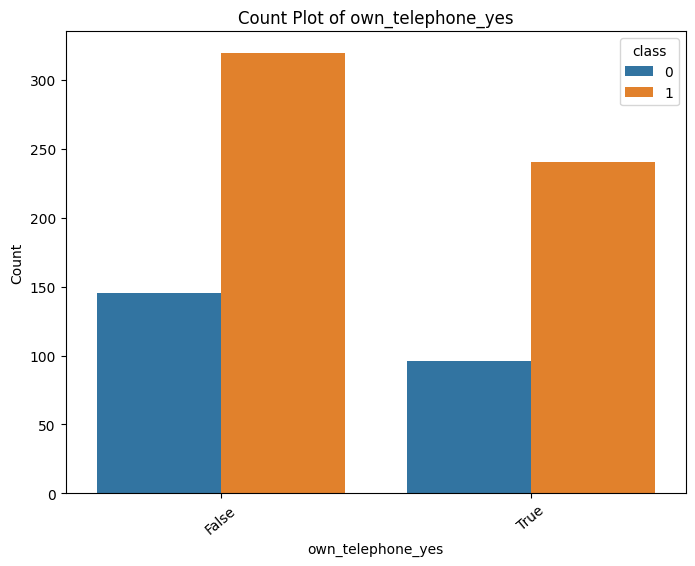

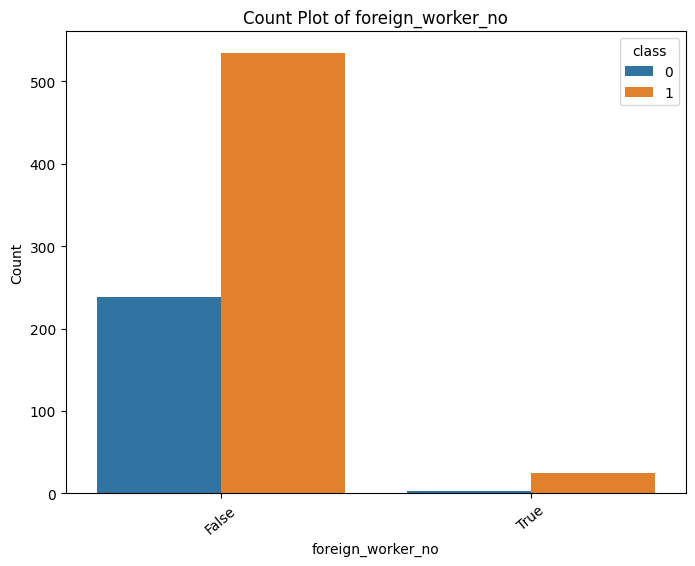

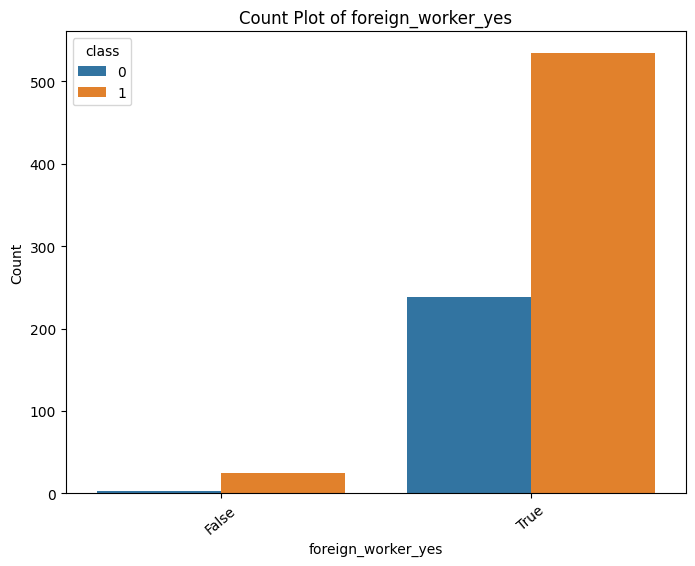

In [11]:
# visualizing categorical features using count plot
categorical_features = X_train.select_dtypes(exclude=['number'])

for feature in categorical_features.columns:
  plt.figure(figsize=(8,6))
  sns.countplot(x=X_train[feature],hue=y_train)
  plt.xlabel(feature)
  plt.xticks(rotation=40)
  plt.ylabel("Count")
  plt.title(f"Count Plot of {feature}")
  plt.show()

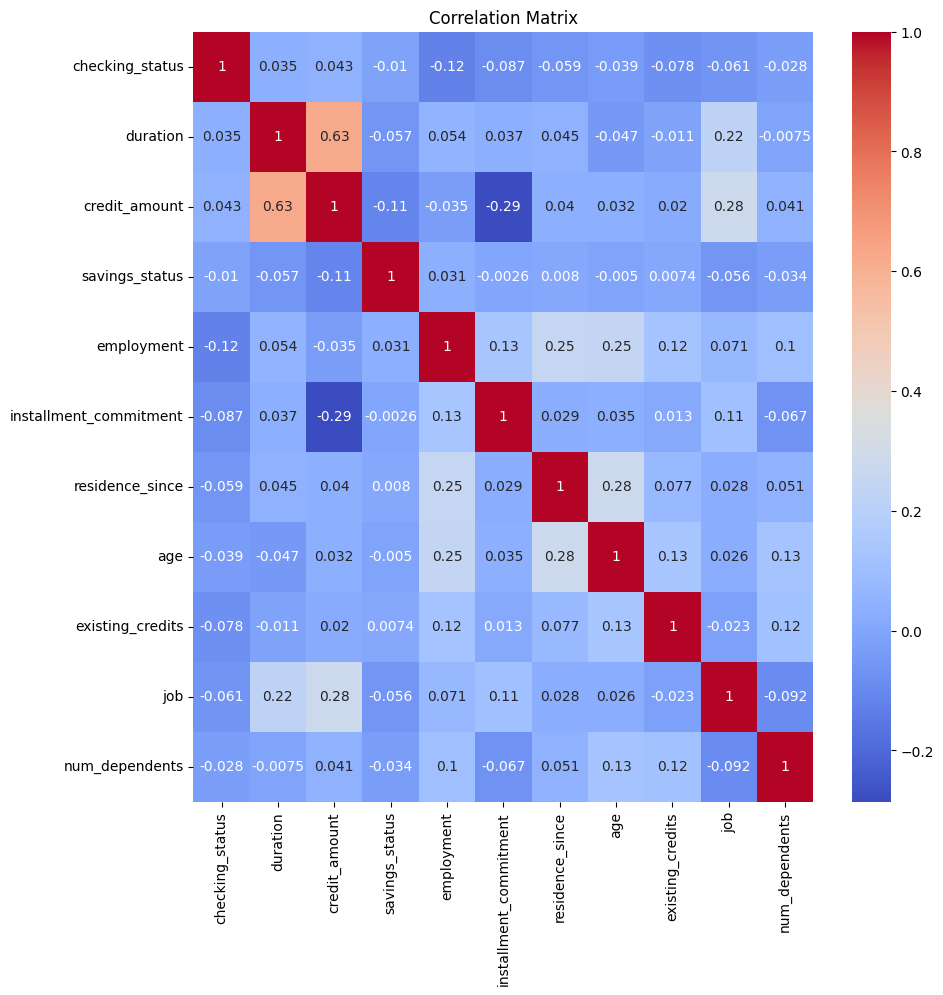

In [50]:
# Generating and visualizing correlation matrix to analyze relationships between features
correlation_matrix = numerical_features.corr(method="pearson")

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [51]:
# getting performance of regular SVM on training, validation, and test data
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Performance of Regular SVM on Test Set:\n")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("Recall Score:")
print(recall_score(y_test, y_pred))
print("Hinge Loss of Regular SVM on Test Set:")
print(hinge_loss(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print()

y_pred = svm.predict(X_val)
print("Performance of Regular SVM on Validation Set:\n")
print("Precision Score:")
print(precision_score(y_val, y_pred))
print("Recall Score:")
print(recall_score(y_val, y_pred))
print("Hinge Loss of Regular SVM on Validation Set:")
print(hinge_loss(y_val, y_pred))
print(f"Accuracy Score: {accuracy_score(y_val, y_pred)}")
print()

y_pred = svm.predict(X_train)
print("Performance of Regular SVM on Training Set:\n")
print("Precision Score:")
print(precision_score(y_train, y_pred))
print("Recall Score:")
print(recall_score(y_train, y_pred))
print("Hinge Loss of Regular SVM on Training Set:")
print(hinge_loss(y_train, y_pred))
print(f"Accuracy Score: {accuracy_score(y_train, y_pred)}")
print()

Performance of Regular SVM on Test Set:

Precision Score:
0.7441860465116279
Recall Score:
0.8888888888888888
Hinge Loss of Regular SVM on Test Set:
0.58
Accuracy Score: 0.7

Performance of Regular SVM on Validation Set:

Precision Score:
0.7951807228915663
Recall Score:
0.9565217391304348
Hinge Loss of Regular SVM on Validation Set:
0.51
Accuracy Score: 0.8

Performance of Regular SVM on Training Set:

Precision Score:
0.7813953488372093
Recall Score:
0.9016100178890877
Hinge Loss of Regular SVM on Training Set:
0.54625
Accuracy Score: 0.755



In [52]:
# Performance of Polynomial Kernel SVM of degree 3
poly_kernel_svm = SVC(kernel="poly")
poly_kernel_svm.fit(X_train, y_train)
poly_y_pred = poly_kernel_svm.predict(X_test)
print("Performance of Polynomial Kernel SVM on Test Set:\n")
print("Precision Score:")
print(precision_score(y_test, poly_y_pred))
print("Recall Score:")
print(recall_score(y_test, poly_y_pred))
print("Hinge Loss of Polynomial Kernel SVM on Test Set:")
print(hinge_loss(y_test, poly_y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, poly_y_pred)}")
print()

poly_y_pred = poly_kernel_svm.predict(X_val)
print("Performance of Polynomial Kernel SVM on Validation Set:\n")
print("Precision Score:")
print(precision_score(y_val, poly_y_pred))
print("Recall Score:")
print(recall_score(y_val, poly_y_pred))
print("Hinge Loss of Polynomial Kernel SVM on Validation Set:")
print(hinge_loss(y_val, poly_y_pred))
print(f"Accuracy Score: {accuracy_score(y_val, poly_y_pred)}")
print()

poly_y_pred = poly_kernel_svm.predict(X_train)
print("Performance of Polynomial Kernel SVM on Training Set:\n")
print("Precision Score:")
print(precision_score(y_train, poly_y_pred))
print("Recall Score:")
print(recall_score(y_train, poly_y_pred))
print("Hinge Loss of Polynomial Kernel SVM on Training Set:")
print(hinge_loss(y_train, poly_y_pred))
print(f"Accuracy Score: {accuracy_score(y_train, poly_y_pred)}")
print()

Performance of Polynomial Kernel SVM on Test Set:

Precision Score:
0.7816091954022989
Recall Score:
0.9444444444444444
Hinge Loss of Polynomial Kernel SVM on Test Set:
0.51
Accuracy Score: 0.77

Performance of Polynomial Kernel SVM on Validation Set:

Precision Score:
0.7951807228915663
Recall Score:
0.9565217391304348
Hinge Loss of Polynomial Kernel SVM on Validation Set:
0.51
Accuracy Score: 0.8

Performance of Polynomial Kernel SVM on Training Set:

Precision Score:
0.8627145085803433
Recall Score:
0.9892665474060823
Hinge Loss of Polynomial Kernel SVM on Training Set:
0.41875
Accuracy Score: 0.8825



In [53]:
# Performance of RBF Kernel SVM
rbf_svm = SVC(kernel="rbf")
rbf_svm.fit(X_train, y_train)
y_pred = rbf_svm.predict(X_test)
print("Performance of RBF SVM on Test Set:\n")
print("Precision Score:")
print(precision_score(y_test, y_pred))
print("Recall Score:")
print(recall_score(y_test, y_pred))
print("Hinge Loss of RBF SVM on Test Set:")
print(hinge_loss(y_test, y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print()

y_pred = rbf_svm.predict(X_val)
print("Performance of RBF SVM on Validation Set:\n")
print("Precision Score:")
print(precision_score(y_val, y_pred))
print("Recall Score:")
print(recall_score(y_val, y_pred))
print("Hinge Loss of RBF SVM on Validation Set:")
print(hinge_loss(y_val, y_pred))
print(f"Accuracy Score: {accuracy_score(y_val, y_pred)}")
print()

y_pred = rbf_svm.predict(X_train)
print("Performance of RBF SVM on Training Set:\n")
print("Precision Score:")
print(precision_score(y_train, y_pred))
print("Recall Score:")
print(recall_score(y_train, y_pred))
print("Hinge Loss of RBF SVM on Training Set:")
print(hinge_loss(y_train, y_pred))
print(f"Accuracy Score: {accuracy_score(y_train, y_pred)}")
print()

Performance of RBF SVM on Test Set:

Precision Score:
0.7701149425287356
Recall Score:
0.9305555555555556
Hinge Loss of RBF SVM on Test Set:
0.53
Accuracy Score: 0.75

Performance of RBF SVM on Validation Set:

Precision Score:
0.7710843373493976
Recall Score:
0.927536231884058
Hinge Loss of RBF SVM on Validation Set:
0.55
Accuracy Score: 0.76

Performance of RBF SVM on Training Set:

Precision Score:
0.8323262839879154
Recall Score:
0.9856887298747764
Hinge Loss of RBF SVM on Training Set:
0.45
Accuracy Score: 0.85125



In [54]:
# Performance of PCA transformation
pca_svm = SVC()
pca_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95)),
    ("classifier", pca_svm)
])
pca_pipeline = pca_pipeline.fit(X_train, y_train)
pca_y_pred = pca_pipeline.predict(X_train)
print("Performance of PCA SVM on Training Set:\n")
print("Precision Score:")
print(precision_score(y_train, pca_y_pred))
print("Recall Score:")
print(recall_score(y_train, pca_y_pred))
print("Hinge Loss of PCA SVM on Training Set:")
print(hinge_loss(y_train, pca_y_pred))
print(f"Accuracy Score: {accuracy_score(y_train, pca_y_pred)}")
print()

pca_y_pred = pca_pipeline.predict(X_val)
print("Performance of PCA SVM on Validation Set:\n")
print("Precision Score:")
print(precision_score(y_val, pca_y_pred))
print("Recall Score:")
print(recall_score(y_val, pca_y_pred))
print("Hinge Loss of PCA SVM on Validation Set:")
print(hinge_loss(y_val, pca_y_pred))
print(f"Accuracy Score: {accuracy_score(y_val, pca_y_pred)}")
print()

pca_y_pred = pca_pipeline.predict(X_test)
print("Performance of PCA SVM on Test Set:\n")
print("Precision Score:")
print(precision_score(y_test, pca_y_pred))
print("Recall Score:")
print(recall_score(y_test, pca_y_pred))
print("Hinge Loss of PCA SVM on Test Set:")
print(hinge_loss(y_test, pca_y_pred))
print(f"Accuracy Score: {accuracy_score(y_test, pca_y_pred)}")
print()

Performance of PCA SVM on Training Set:

Precision Score:
0.8323262839879154
Recall Score:
0.9856887298747764
Hinge Loss of PCA SVM on Training Set:
0.45
Accuracy Score: 0.85125

Performance of PCA SVM on Validation Set:

Precision Score:
0.788235294117647
Recall Score:
0.9710144927536232
Hinge Loss of PCA SVM on Validation Set:
0.51
Accuracy Score: 0.8

Performance of PCA SVM on Test Set:

Precision Score:
0.7333333333333333
Recall Score:
0.9166666666666666
Hinge Loss of PCA SVM on Test Set:
0.58
Accuracy Score: 0.7




L1 Regularization:
Lowest value of hinge loss: 0.51
Best parameters for hinge loss:
Learning Rate: 0.1, C: 100

Lowest percentage error: 28.0
Best parameters for percentage error:
Learning Rate: 0.001, C: 0.01



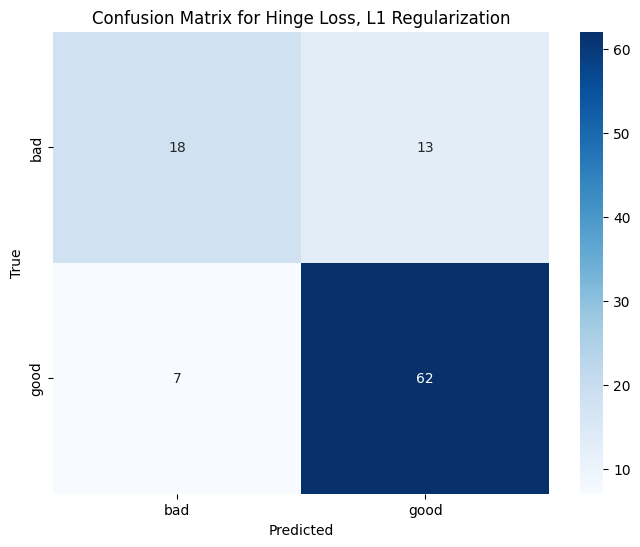

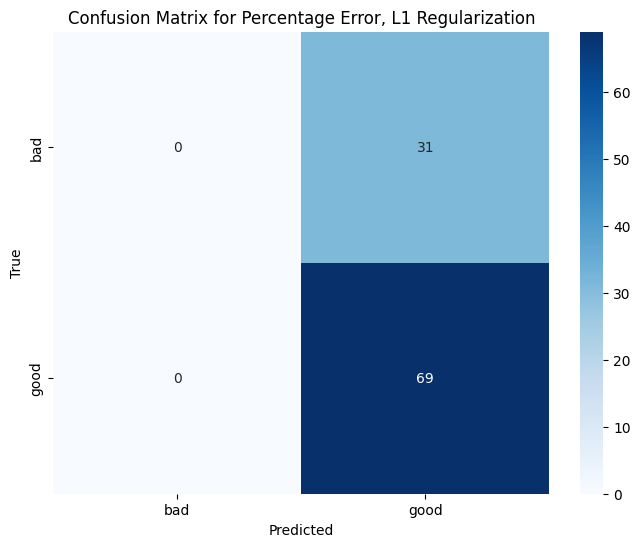



L2 Regularization:
Lowest value of hinge loss: 0.51
Best parameters for hinge loss:
Learning Rate: 0.05, C: 10

Lowest percentage error: 28.0
Best parameters for percentage error:
Learning Rate: 0.001, C: 0.01



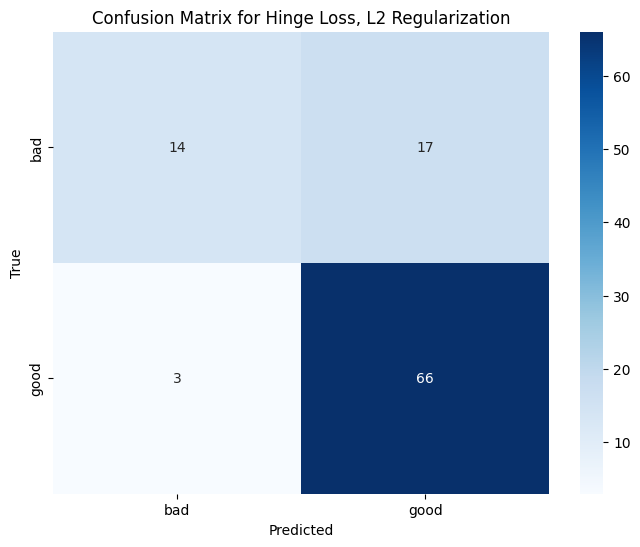

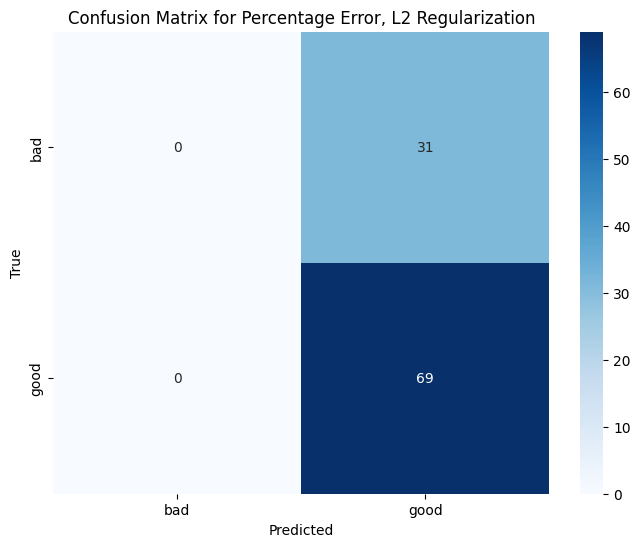

In [55]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5]
C_values = [0.01, 0.1, 0.5, 1, 10, 100, 500]
percentage_errors_l1 = []
percentage_errors_l2 = []
hinge_losses_l1 = []
hinge_losses_l2 = []

# Hyperparameter Tuning with L1 Regularization
best_params = {}
lowest_percentage_error = 100
lowest_hinge_loss = 1
best_pred_hinge = None
best_pred_error = None
for lr in learning_rates:
  for c in C_values:
    sgd_clf = SGDClassifier(loss="hinge", penalty="l1", alpha = 1/(c*len(X_train)), learning_rate="constant", eta0=lr, random_state=42)
    sgd_clf.fit(X_train, y_train)
    y_pred = sgd_clf.predict(X_val)
    curr_hinge_loss = hinge_loss(y_val, y_pred)
    # If current hinge loss is lower than the lowest, update
    if curr_hinge_loss < lowest_hinge_loss:
      lowest_hinge_loss = curr_hinge_loss
      best_params['hinge_loss'] = (lr, c)
      best_pred_hinge = y_pred
    accuracy = accuracy_score(y_pred, y_test)
    percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
    # If error for current training example is lower than the lowest, update
    if percentage_error < lowest_percentage_error:
      lowest_percentage_error = percentage_error
      best_params['percentage_error'] = (lr, c)
      best_pred_error = y_pred
print()

# Printing best hyperparameters
print("L1 Regularization:")
print(f"Lowest value of hinge loss: {lowest_hinge_loss}")
print("Best parameters for hinge loss:")
print(f"Learning Rate: {best_params['hinge_loss'][0]}, C: {best_params['hinge_loss'][1]}")
print()
print(f"Lowest percentage error: {lowest_percentage_error}")
print("Best parameters for percentage error:")
print(f"Learning Rate: {best_params['percentage_error'][0]}, C: {best_params['percentage_error'][1]}")
print()

# Generating confusing matrix for hinge loss - L1
conf_matrix_hinge_l1 = confusion_matrix(y_val, best_pred_hinge)
classes = ['bad', 'good']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_hinge_l1, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Hinge Loss, L1 Regularization')
plt.show()
print()

# Generating confusion matrix for error - L1
conf_matrix_error_l1 = confusion_matrix(y_val, best_pred_error)
classes = ['bad', 'good']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_error_l1, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Percentage Error, L1 Regularization')
plt.show()
print()

# Hyperparameter Tuning with L2 Regularization
lowest_percentage_error = 100
lowest_hinge_loss = 1
best_params = {}
best_pred_hinge = None
best_pred_error = None
for lr in learning_rates:
  for c in C_values:
    sgd_clf = SGDClassifier(loss="hinge", penalty="l2", alpha = 1/(c*len(X_train)), learning_rate="constant", eta0=lr, random_state=42)
    sgd_clf.fit(X_train, y_train)
    y_pred = sgd_clf.predict(X_val)
    curr_hinge_loss = hinge_loss(y_val, y_pred)
    # If current hinge loss found is lower than the lowest, update
    if curr_hinge_loss < lowest_hinge_loss:
      lowest_hinge_loss = curr_hinge_loss
      best_params['hinge_loss'] = (lr, c)
      best_pred_hinge = y_pred
    accuracy = accuracy_score(y_pred, y_test)
    percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
    # If error for current training example is lower than the lowest, update
    if percentage_error < lowest_percentage_error:
      lowest_percentage_error = percentage_error
      best_params['percentage_error'] = (lr, c)
      best_pred_error = y_pred
print()

print("L2 Regularization:")
print(f"Lowest value of hinge loss: {lowest_hinge_loss}")
print("Best parameters for hinge loss:")
print(f"Learning Rate: {best_params['hinge_loss'][0]}, C: {best_params['hinge_loss'][1]}")
print()
print(f"Lowest percentage error: {lowest_percentage_error}")
print("Best parameters for percentage error:")
print(f"Learning Rate: {best_params['percentage_error'][0]}, C: {best_params['percentage_error'][1]}")
print()

# Generating confusion matrix for L2 Regularization - Hinge Loss
conf_matrix_hinge_l2 = confusion_matrix(y_val, best_pred_hinge)
classes = ['bad', 'good']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_hinge_l2, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Hinge Loss, L2 Regularization')
plt.show()
print()

# Generating confusion matrix for L2 Regularization - Error
conf_matrix_error_l2 = confusion_matrix(y_val, best_pred_error)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_error_l2, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Percentage Error, L2 Regularization')
plt.show()
print()

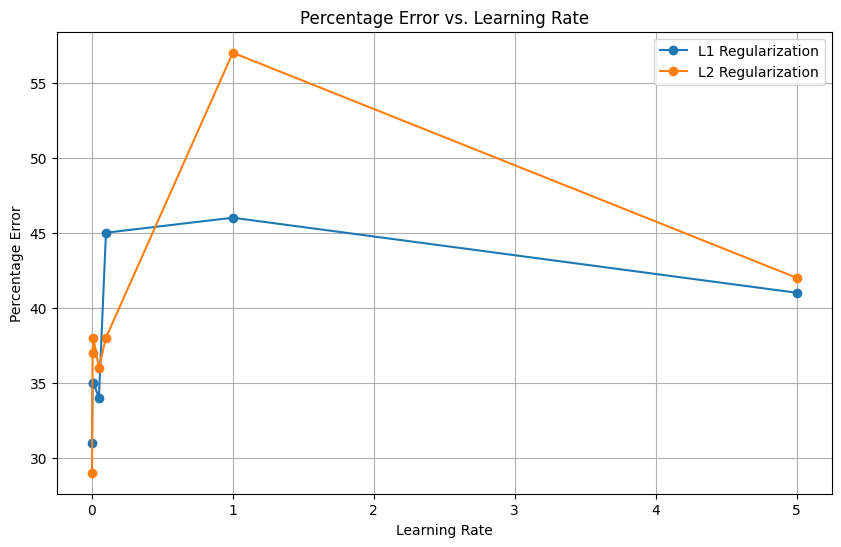

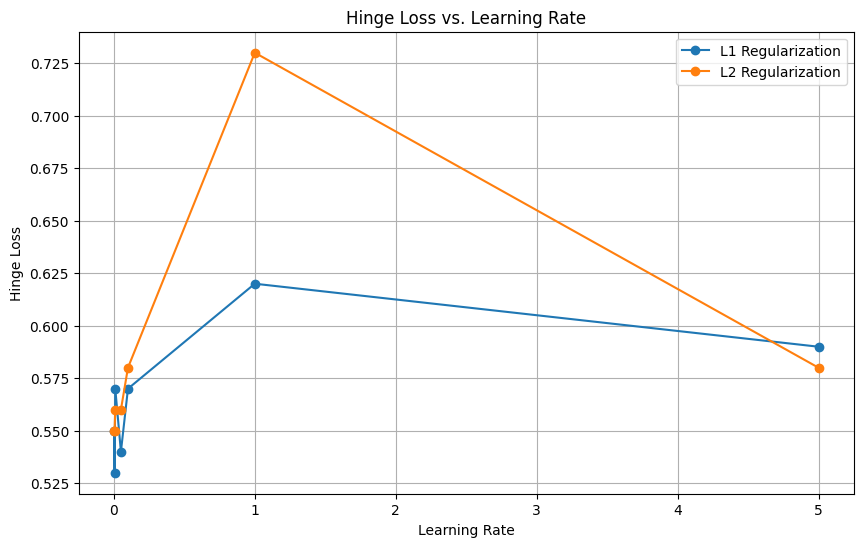

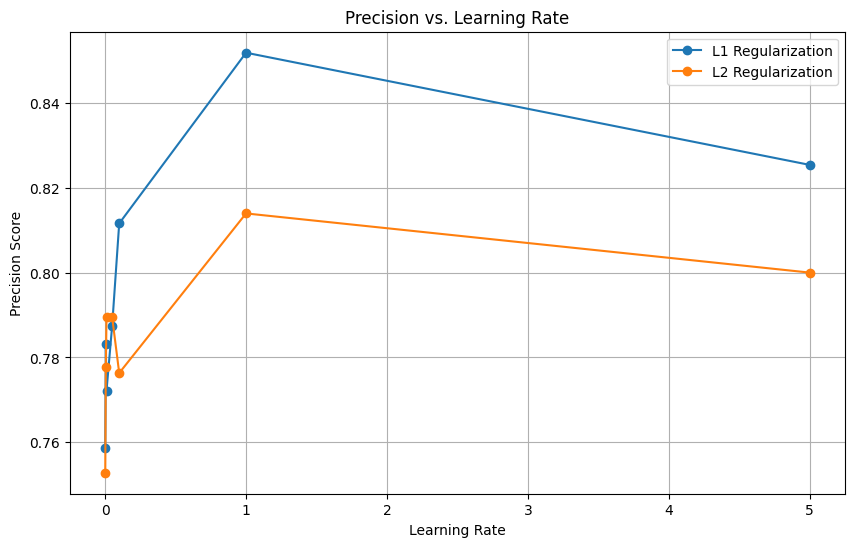

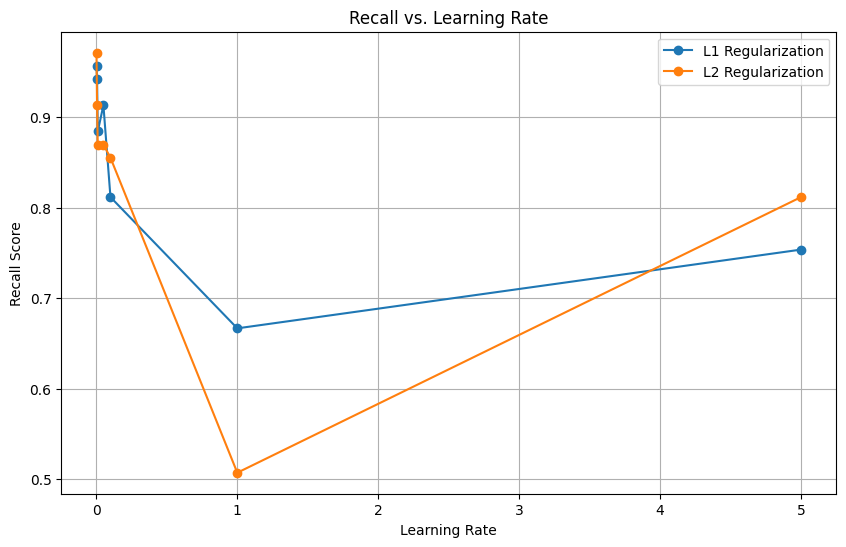

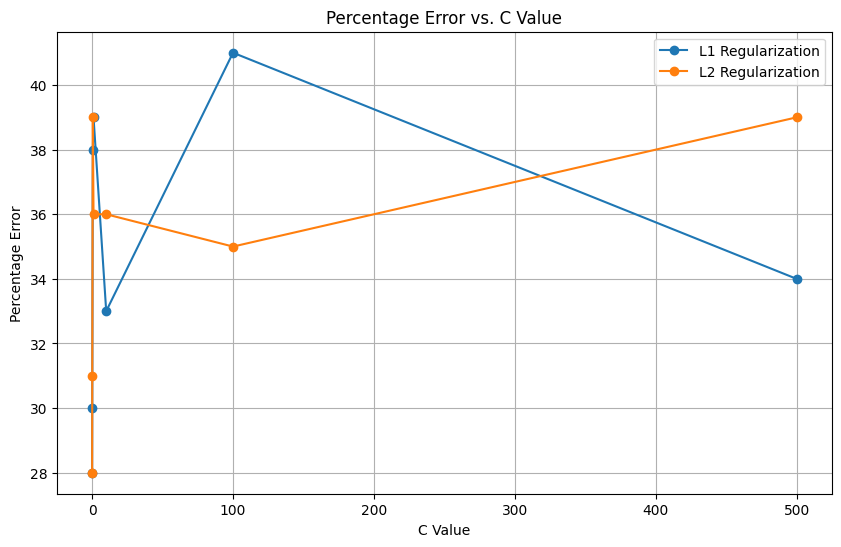

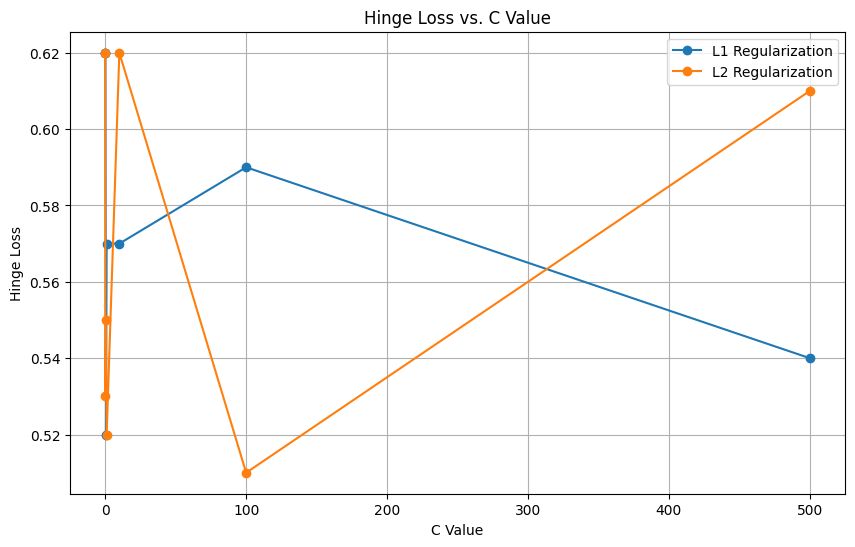

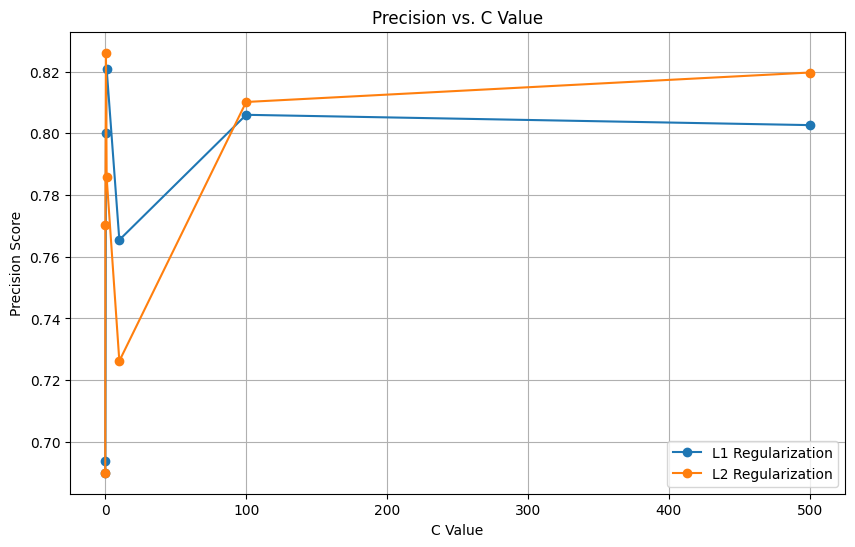

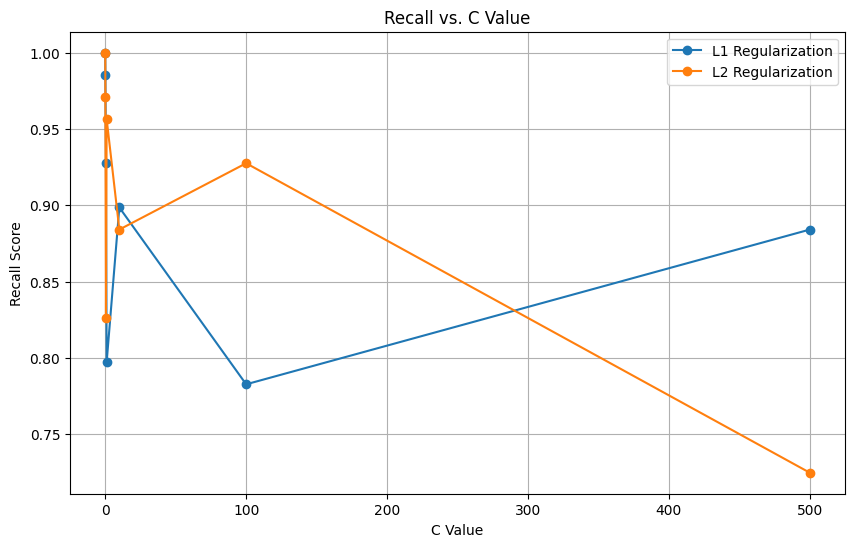

In [56]:
# Generate graphs for how hyperparameters influence hinge loss and validation error

# Learning Rates
percentage_errors_l1 = []
hinge_losses_l1 = []
precision_scores_l1 = []
recall_scores_l1 = []
for lr in learning_rates:
  sgd_clf = SGDClassifier(loss="hinge", penalty="l1", learning_rate="constant", eta0=lr, random_state=42)
  sgd_clf.fit(X_train, y_train)
  y_pred = sgd_clf.predict(X_val)
  curr_hinge_loss = hinge_loss(y_val, y_pred)
  hinge_losses_l1.append(curr_hinge_loss)
  percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
  percentage_errors_l1.append(percentage_error)
  precision_scores_l1.append(precision_score(y_val, y_pred))
  recall_scores_l1.append(recall_score(y_val, y_pred))

percentage_errors_l2 = []
hinge_losses_l2 = []
precision_scores_l2 = []
recall_scores_l2 = []
for lr in learning_rates:
  sgd_clf = SGDClassifier(loss="hinge", penalty="l2", learning_rate="constant", eta0=lr, random_state=42)
  sgd_clf.fit(X_train, y_train)
  y_pred = sgd_clf.predict(X_val)
  curr_hinge_loss = hinge_loss(y_val, y_pred)
  hinge_losses_l2.append(curr_hinge_loss)
  percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
  percentage_errors_l2.append(percentage_error)
  precision_scores_l2.append(precision_score(y_val, y_pred))
  recall_scores_l2.append(recall_score(y_val, y_pred))

# Print graphs for learning rate
# Error vs learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, percentage_errors_l1, marker='o', label='L1 Regularization')
plt.plot(learning_rates, percentage_errors_l2, marker='o', label='L2 Regularization')
plt.xlabel('Learning Rate')
plt.ylabel('Percentage Error')
plt.title('Percentage Error vs. Learning Rate')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Hinge Loss vs Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, hinge_losses_l1, marker='o', label='L1 Regularization')
plt.plot(learning_rates, hinge_losses_l2, marker='o', label='L2 Regularization')
plt.xlabel('Learning Rate')
plt.ylabel('Hinge Loss')
plt.title('Hinge Loss vs. Learning Rate')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Precision Score vs Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, precision_scores_l1, marker='o', label='L1 Regularization')
plt.plot(learning_rates, precision_scores_l2, marker='o', label='L2 Regularization')
plt.xlabel('Learning Rate')
plt.ylabel('Precision Score')
plt.title('Precision vs. Learning Rate')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Recall vs Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, recall_scores_l1, marker='o', label='L1 Regularization')
plt.plot(learning_rates, recall_scores_l2, marker='o', label='L2 Regularization')
plt.xlabel('Learning Rate')
plt.ylabel('Recall Score')
plt.title('Recall vs. Learning Rate')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Regularization Value
percentage_errors_l1 = []
hinge_losses_l1 = []
precision_scores_l1 = []
recall_scores_l1 = []
for c in C_values:
  sgd_clf = SGDClassifier(loss="hinge", penalty="l1", alpha = 1/(c*len(X_train)), random_state=42)
  sgd_clf.fit(X_train, y_train)
  y_pred = sgd_clf.predict(X_val)
  curr_hinge_loss = hinge_loss(y_val, y_pred)
  hinge_losses_l1.append(curr_hinge_loss)
  percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
  percentage_errors_l1.append(percentage_error)
  precision_scores_l1.append(precision_score(y_val, y_pred))
  recall_scores_l1.append(recall_score(y_val, y_pred))

percentage_errors_l2 = []
hinge_losses_l2 = []
precision_scores_l2 = []
recall_scores_l2 = []
for c in C_values:
  sgd_clf = SGDClassifier(loss="hinge", penalty="l2", alpha = 1/(c*len(X_train)), random_state=42)
  sgd_clf.fit(X_train, y_train)
  y_pred = sgd_clf.predict(X_val)
  curr_hinge_loss = hinge_loss(y_val, y_pred)
  hinge_losses_l2.append(curr_hinge_loss)
  percentage_error = 100 - accuracy_score(y_pred, y_test) * 100
  percentage_errors_l2.append(percentage_error)
  precision_scores_l2.append(precision_score(y_val, y_pred))
  recall_scores_l2.append(recall_score(y_val, y_pred))

# Error vs Regularization Strength
plt.figure(figsize=(10, 6))
plt.plot(C_values, percentage_errors_l1, marker='o', label='L1 Regularization')
plt.plot(C_values, percentage_errors_l2, marker='o', label='L2 Regularization')
plt.xlabel('C Value')
plt.ylabel('Percentage Error')
plt.title('Percentage Error vs. C Value')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Hinge Loss vs Regularization Strength
plt.figure(figsize=(10, 6))
plt.plot(C_values, hinge_losses_l1, marker='o', label='L1 Regularization')
plt.plot(C_values, hinge_losses_l2, marker='o', label='L2 Regularization')
plt.xlabel('C Value')
plt.ylabel('Hinge Loss')
plt.title('Hinge Loss vs. C Value')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

# Precision Score vs Regularization Strength
plt.figure(figsize=(10, 6))
plt.plot(C_values, precision_scores_l1, marker='o', label='L1 Regularization')
plt.plot(C_values, precision_scores_l2, marker='o', label='L2 Regularization')
plt.xlabel('C Value')
plt.ylabel('Precision Score')
plt.title('Precision vs. C Value')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

# Recall Score vs Regularization Strength
plt.figure(figsize=(10, 6))
plt.plot(C_values, recall_scores_l1, marker='o', label='L1 Regularization')
plt.plot(C_values, recall_scores_l2, marker='o', label='L2 Regularization')
plt.xlabel('C Value')
plt.ylabel('Recall Score')
plt.title('Recall vs. C Value')
plt.legend(["L1 Regularization", "L2 Regularization"])
plt.grid(True)
plt.show()

print()

In [57]:
# helper functions
# Confusion Matrix Structure:
#             Predicted
#             0       1
# True   0   [ TN   FP ]
#        1   [ FN   TP ]

def get_recall(confusion_matrix):
  TN, FP, FN, TP = confusion_matrix.ravel() # returns 1D copy
  recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
  return round(recall,2)

def get_precision(confusion_matrix):
  TN, FP, FN, TP = confusion_matrix.ravel() # returns 1D copy
  precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
  return round(precision,2)

def visualize_ROC_plot(y_true, y_predict_prob, class_mapping=None, title='ROC Curve'):
  if class_mapping:
      y_true_numeric = y_true.replace(class_mapping)
  else:
      y_true_numeric = y_true

  # Compute ROC curve and AUC (area under curve)
  fpr, tpr, _ = metrics.roc_curve(y_true_numeric, y_predict_prob)
  auc = metrics.roc_auc_score(y_true_numeric, y_predict_prob)

  # Plot
  plt.figure()
  plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc='lower right')
  plt.show()

  return auc

def get_confusion_matrix(y_true, y_pred):
  cnf_matrix = metrics.confusion_matrix(y_true, y_pred)
  return cnf_matrix

def display_metrics(y_true, y_pred, cnf_matrix, target_names):
  print(metrics.classification_report(y_true, y_pred, target_names=target_names))
  accuracy = metrics.classification_report(y_true, y_pred, target_names=target_names)[219:223]
  print(f"Accuracy: {accuracy}")
  print(f"Recall: {get_recall(cnf_matrix)}")
  print(f"Precision: {get_precision(cnf_matrix)}")

def visualize_confusion_matrix(cnf_matrix, class_names, title="Confusion Matrix"):
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)

  # Create heatmap using seaborn
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm", fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title(title, y=1.05)  # y-coordinate for title
  plt.xlabel('Predicted label')
  ax.xaxis.set_label_position("bottom")
  plt.ylabel('True label')



In [20]:
## [C] Training: Logistic Regression (no regularization)
# use "lbfgs" solver (optimization algo) bc it can support no regularization unlike other solvers
logreg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)    # train the model on our training set; computes best weights to minimize -ve log-likelihood function
y_predict = logreg.predict(X_test)  # make predictions on test set (to calculate test accuracy)
y_predict_train = logreg.predict(X_train)  # make predictions on training set (to calculate training accuracy)
# print(type(y_test))
# print(type(y_predict[0]))
# print(type(y_test.iloc[0]))
# SECTION [C] DONE ✅

In [21]:
## [D] Evaluation: use test set
# Confusion Matrix
cnf_matrix = get_confusion_matrix(y_test, y_predict)
cnf_matrix_train = get_confusion_matrix(y_train, y_predict_train)

# Structure of Confusion Matrix:
# * Top-left-bottom-right Diagonal = correct predictions
# * 0 for "bad", 1 for "good" credit risk
#             Predicted
#             0       1
# True   0   [ TN   FP ]
#        1   [ FN   TP ]

# Evaluation Metrics
target_names = ['bad credit risk', 'good credit risk']
print("Metrics on test set:")
print(f"Confusion Matrix (on test set):\n {cnf_matrix}")
display_metrics(y_test, y_predict, cnf_matrix, target_names=target_names)

print("--------------------------------------------------------")

print("Metrics on training set:")
print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
display_metrics(y_train, y_predict_train, cnf_matrix_train, target_names=target_names)

# Accuracy = proportion of correct predictions
# Precision = proportion of true pos among everything predicted true = (TP) / (TP + FP)
# Recall = proportion of true pos among everything actually true = (TP) / (TP + FN)

# SECTION [D] DONE ✅

Metrics on test set:
Confusion Matrix (on test set):
 [[ 7 21]
 [10 62]]
                  precision    recall  f1-score   support

 bad credit risk       0.41      0.25      0.31        28
good credit risk       0.75      0.86      0.80        72

        accuracy                           0.69       100
       macro avg       0.58      0.56      0.56       100
    weighted avg       0.65      0.69      0.66       100

Accuracy: 0.69
Recall: 0.86
Precision: 0.75
--------------------------------------------------------
Metrics on training set:
Confusion Matrix (on training set):
 [[107 134]
 [ 56 503]]
                  precision    recall  f1-score   support

 bad credit risk       0.66      0.44      0.53       241
good credit risk       0.79      0.90      0.84       559

        accuracy                           0.76       800
       macro avg       0.72      0.67      0.69       800
    weighted avg       0.75      0.76      0.75       800

Accuracy: 0.76
Recall: 0.9
Precision: 0

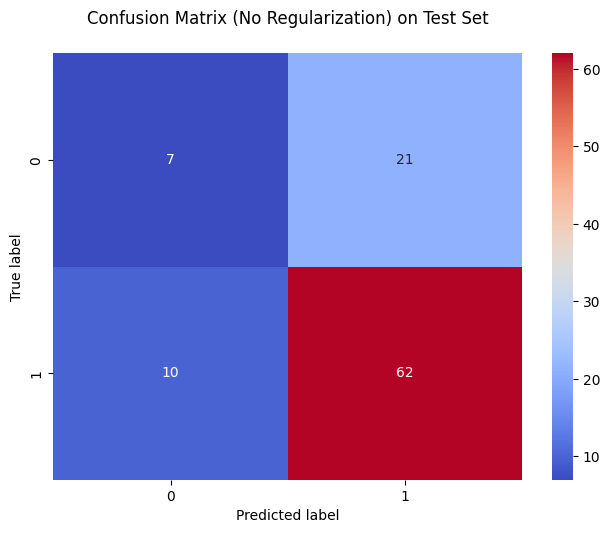

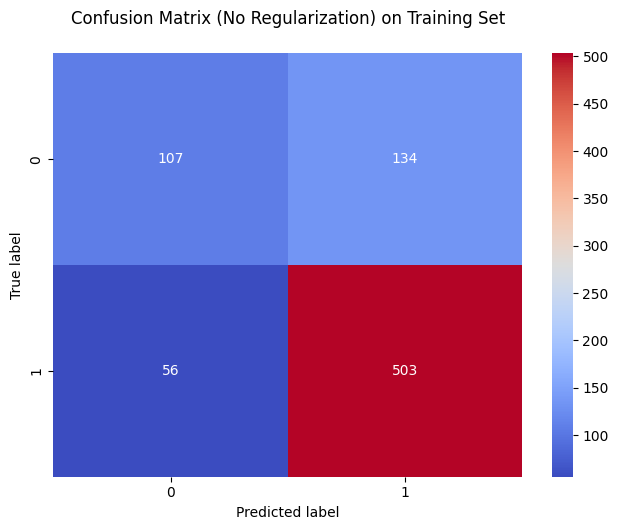

In [22]:
## [E] Visualization
# Confusion Matrices
class_names=[0,1]

visualize_confusion_matrix(cnf_matrix, class_names, "Confusion Matrix (No Regularization) on Test Set")
visualize_confusion_matrix(cnf_matrix_train, class_names, "Confusion Matrix (No Regularization) on Training Set")

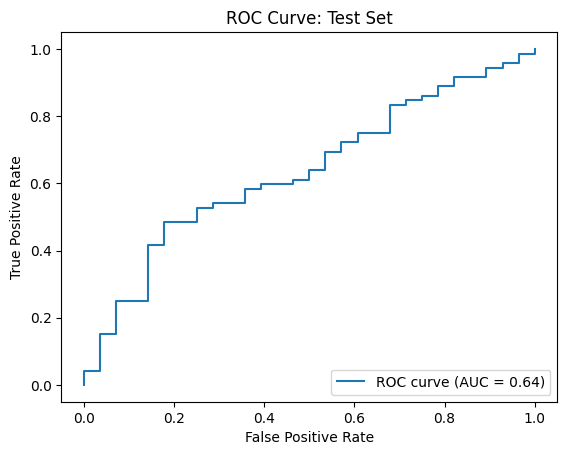

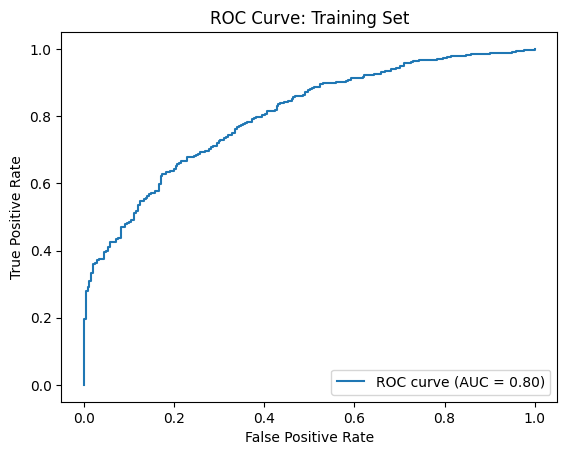

0.801475664160215

In [23]:
# [E] Visualization - continued
# ROC Curve: how good is a binary-classifier model?
# For different threshold values, graph their...
# x-axis: false positive rate
# y-axis: true positive rate
# auc = area under curve; 1 indicates perfect classifier; < 0.5 is bad (worse than random guessing)

class_mapping = {'bad': 0, 'good': 1}
y_predict_prob = logreg.predict_proba(X_test)[::,1]
y_predict_prob_train = logreg.predict_proba(X_train)[::,1]

visualize_ROC_plot(y_test, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Test Set")
visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")

# SECTION [E] DONE ✅

Number of features after Polynomial transformation: 19600
Metrics on test set:
Confusion Matrix (on test set):
 [[16 12]
 [11 61]]
                  precision    recall  f1-score   support

 bad credit risk       0.59      0.57      0.58        28
good credit risk       0.84      0.85      0.84        72

        accuracy                           0.77       100
       macro avg       0.71      0.71      0.71       100
    weighted avg       0.77      0.77      0.77       100

Accuracy: 0.77
Recall: 0.85
Precision: 0.84
Metrics on training set:
Confusion Matrix (on training set):
 [[241   0]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       1.00      1.00      1.00       241
good credit risk       1.00      1.00      1.00       559

        accuracy                           1.00       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      1.00      1.00       800

Accuracy: 1.00
Recall: 1.0
Precision: 

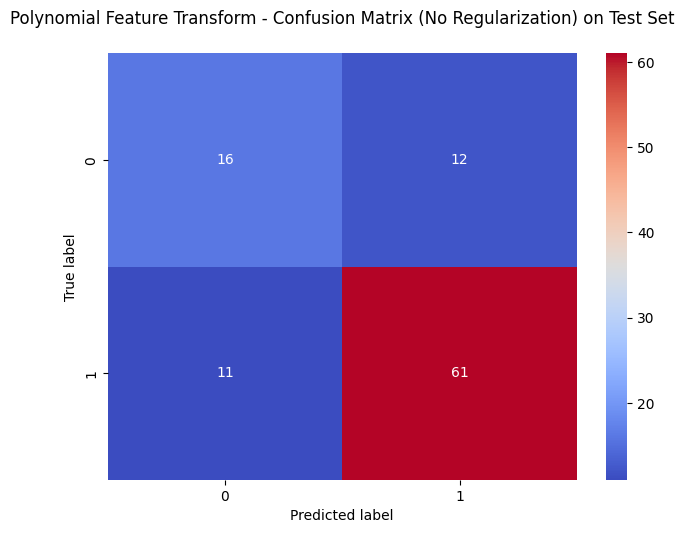

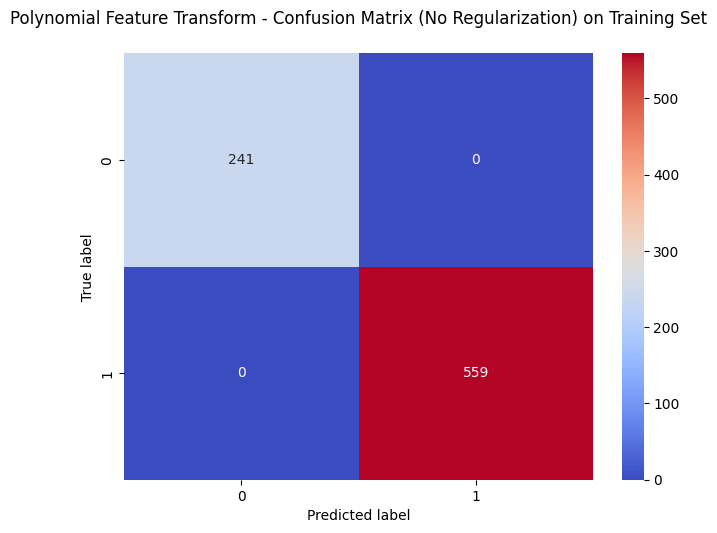

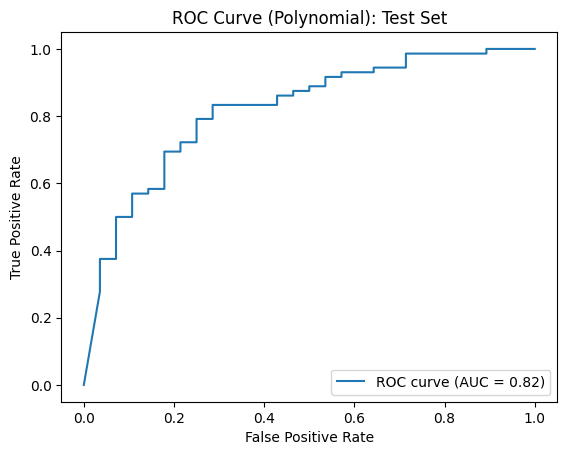

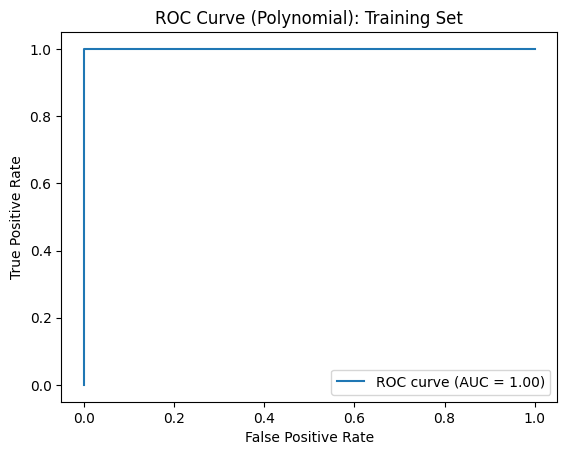

1.0

In [24]:
## [F] Feature Transformations (at least 3 types)
# [F1] Polynomial transform, degree 3
# Train model
from sklearn.preprocessing import PolynomialFeatures

# Polynomial feature transformation
poly = PolynomialFeatures(degree=3)
X_train_polynomial = poly.fit_transform(X_train)
X_test_polynomial = poly.transform(X_test)
print(f"Number of features after Polynomial transformation: {X_train_polynomial.shape[1]}")

# Train logistic regression model on polynomial features
logreg_polynomial = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
logreg_polynomial.fit(X_train_polynomial, y_train)

# Make predictions on the test set
y_predict_polynomial = logreg_polynomial.predict(X_test_polynomial)
y_predict_polynomial_train = logreg_polynomial.predict(X_train_polynomial)

# Confusion Matrix
cnf_matrix_polynomial = get_confusion_matrix(y_test, y_predict_polynomial)
visualize_confusion_matrix(cnf_matrix_polynomial, class_names=[0, 1], title='Polynomial Feature Transform - Confusion Matrix (No Regularization) on Test Set')
cnf_matrix_polynomial_train = get_confusion_matrix(y_train, y_predict_polynomial_train)
visualize_confusion_matrix(cnf_matrix_polynomial_train, class_names=[0, 1], title='Polynomial Feature Transform - Confusion Matrix (No Regularization) on Training Set')

# Evaluation Metrics
target_names = ['bad credit risk', 'good credit risk']
print("Metrics on test set:")
print(f"Confusion Matrix (on test set):\n {cnf_matrix_polynomial}")
display_metrics(y_test, y_predict_polynomial, cnf_matrix_polynomial, target_names=target_names)

print("Metrics on training set:")
print(f"Confusion Matrix (on training set):\n {cnf_matrix_polynomial_train}")
display_metrics(y_train, y_predict_polynomial_train, cnf_matrix_polynomial_train, target_names=target_names)

# ROC Curve
class_mapping = {'bad': 0, 'good': 1}
y_predict_prob = logreg_polynomial.predict_proba(X_test_polynomial)[::,1]
y_predict_prob_train = logreg_polynomial.predict_proba(X_train_polynomial)[::,1]

visualize_ROC_plot(y_test, y_predict_prob, class_mapping=class_mapping, title="ROC Curve (Polynomial): Test Set")
visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve (Polynomial): Training Set")

Number of features after PCA transformation: 23
Metrics on test set:
                  precision    recall  f1-score   support

 bad credit risk       0.39      0.25      0.30        28
good credit risk       0.74      0.85      0.79        72

        accuracy                           0.68       100
       macro avg       0.57      0.55      0.55       100
    weighted avg       0.64      0.68      0.66       100

Accuracy: 0.68
Recall: 0.85
Precision: 0.74
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.62      0.35      0.45       241
good credit risk       0.76      0.91      0.83       559

        accuracy                           0.74       800
       macro avg       0.69      0.63      0.64       800
    weighted avg       0.72      0.74      0.71       800

Accuracy: 0.74
Recall: 0.91
Precision: 0.76


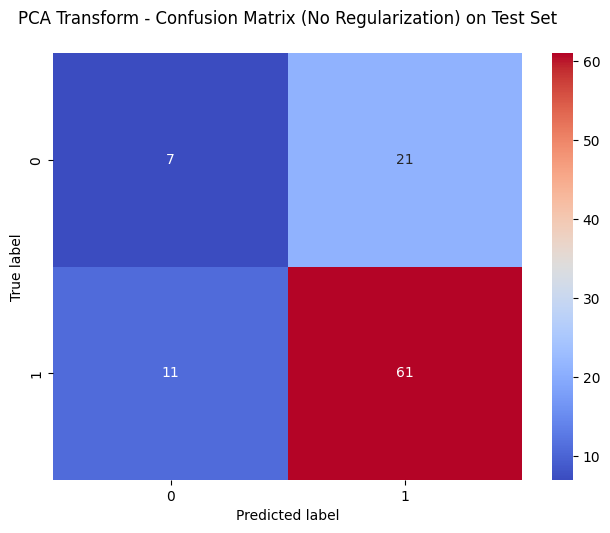

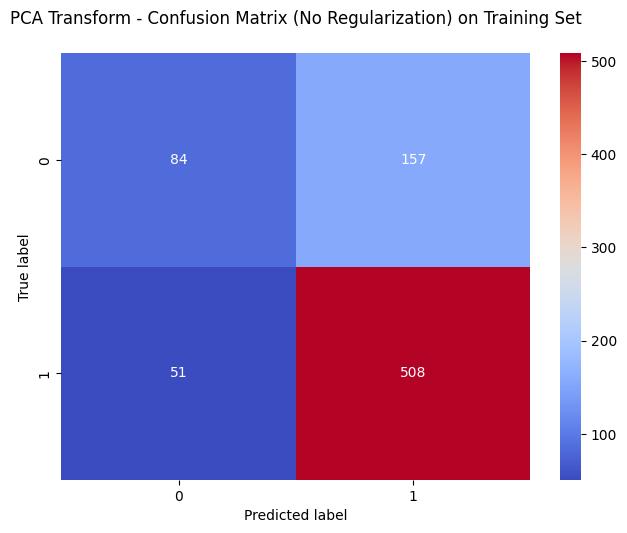

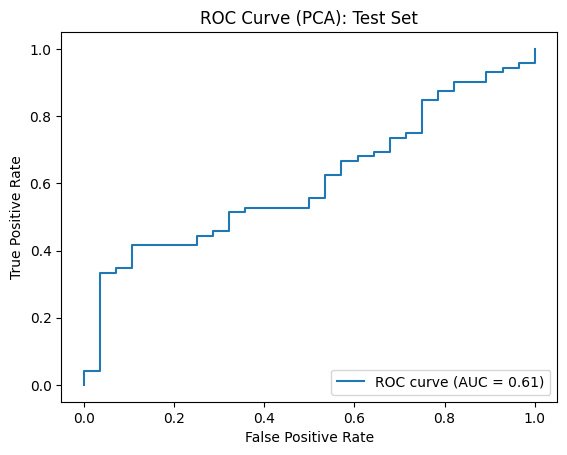

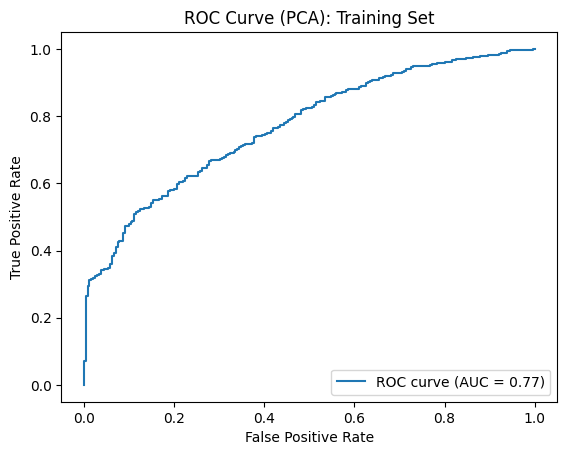

0.769238192088718

In [25]:
# [F2] PCA (principal component analysis)
# Train model with PCA transformation
from sklearn.decomposition import PCA

# Initialize PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance in the data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Number of features after PCA transformation
print(f"Number of features after PCA transformation: {X_train_pca.shape[1]}")

# Train logistic regression model on PCA-transformed features
logreg_pca = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
logreg_pca.fit(X_train_pca, y_train)

# Make predictions on the test and training set
y_predict_pca = logreg_pca.predict(X_test_pca)
y_predict_pca_train = logreg_pca.predict(X_train_pca)

# Confusion Matrix for test set
cnf_matrix_pca = get_confusion_matrix(y_test, y_predict_pca)
visualize_confusion_matrix(cnf_matrix_pca, class_names=[0, 1], title='PCA Transform - Confusion Matrix (No Regularization) on Test Set')

# Confusion Matrix for training set
cnf_matrix_pca_train = get_confusion_matrix(y_train, y_predict_pca_train)
visualize_confusion_matrix(cnf_matrix_pca_train, class_names=[0, 1], title='PCA Transform - Confusion Matrix (No Regularization) on Training Set')

# Evaluation Metrics for test set
target_names = ['bad credit risk', 'good credit risk']
print("Metrics on test set:")
display_metrics(y_test, y_predict_pca, cnf_matrix_pca, target_names=target_names)

# Evaluation Metrics for training set
print("Metrics on training set:")
display_metrics(y_train, y_predict_pca_train, cnf_matrix_pca_train, target_names=target_names)

# ROC Curve for test set
class_mapping = {'bad': 0, 'good': 1}
y_predict_prob_pca = logreg_pca.predict_proba(X_test_pca)[::,1]
y_predict_prob_pca_train = logreg_pca.predict_proba(X_train_pca)[::,1]

visualize_ROC_plot(y_test, y_predict_prob_pca, class_mapping=class_mapping, title="ROC Curve (PCA): Test Set")
visualize_ROC_plot(y_train, y_predict_prob_pca_train, class_mapping=class_mapping, title="ROC Curve (PCA): Training Set")

Metrics on test set:
                  precision    recall  f1-score   support

 bad credit risk       0.62      0.46      0.53        28
good credit risk       0.81      0.89      0.85        72

        accuracy                           0.77       100
       macro avg       0.71      0.68      0.69       100
    weighted avg       0.76      0.77      0.76       100

Accuracy: 0.77
Recall: 0.89
Precision: 0.81
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       1.00      1.00      1.00       241
good credit risk       1.00      1.00      1.00       559

        accuracy                           1.00       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      1.00      1.00       800

Accuracy: 1.00
Recall: 1.0
Precision: 1.0


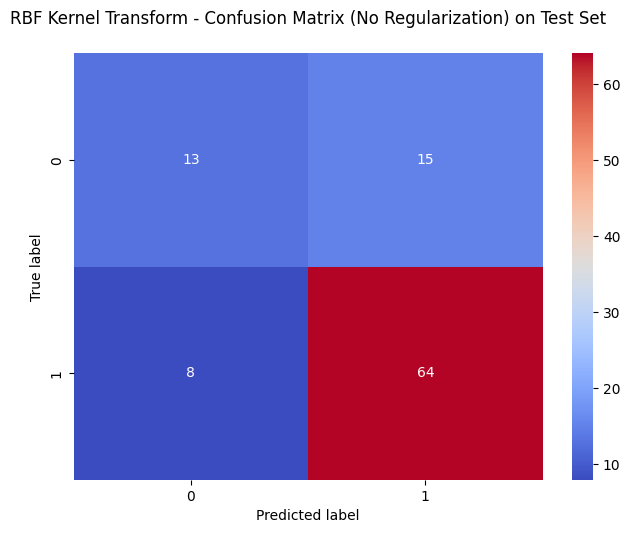

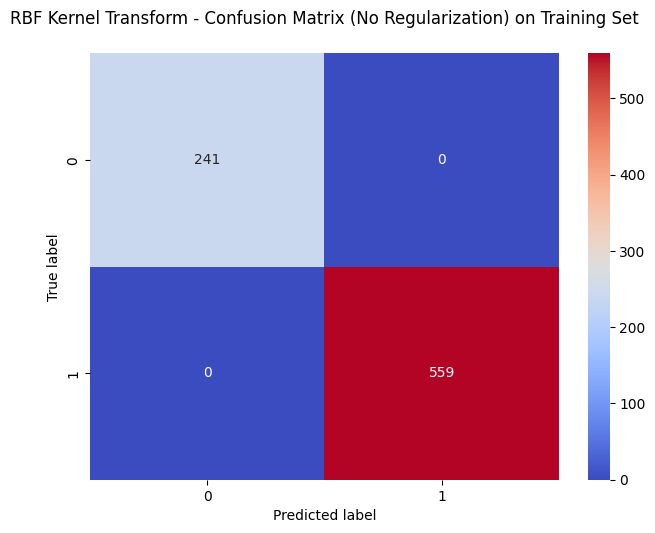

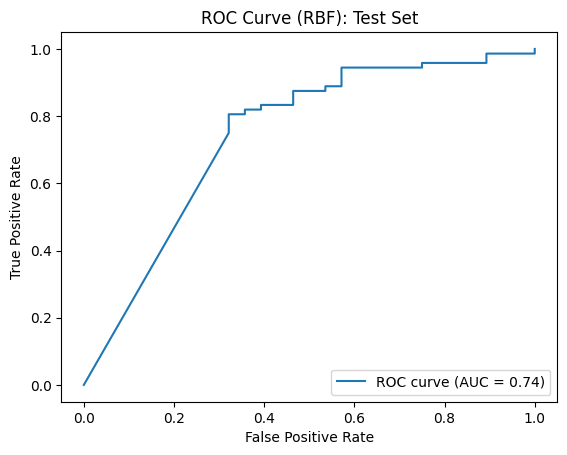

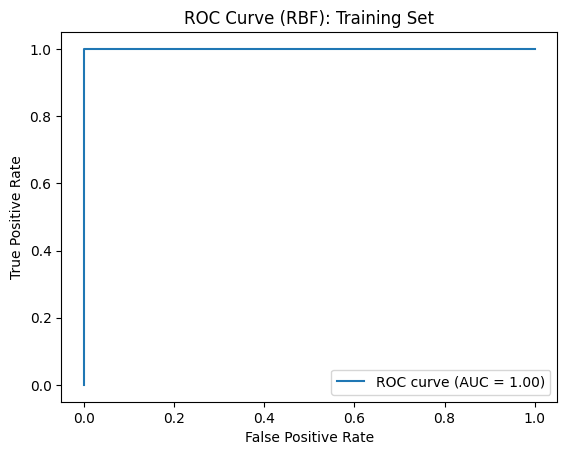

1.0

In [26]:
# [F3] Radial-Basis Function Kernel Transform (RBF)
from sklearn.metrics.pairwise import rbf_kernel

# Gamma parameter for RBF kernel
gamma = 0.1

# Apply RBF kernel
X_train_rbf = rbf_kernel(X_train, X_train, gamma=gamma)  # RBF kernel on training data
X_test_rbf = rbf_kernel(X_test, X_train, gamma=gamma)  # RBF kernel between test and training data

# Train logistic regression model on RBF-transformed features
logreg_rbf = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
logreg_rbf.fit(X_train_rbf, y_train)

# Make predictions on the test and training set
y_predict_rbf = logreg_rbf.predict(X_test_rbf)
y_predict_rbf_train = logreg_rbf.predict(X_train_rbf)

# Confusion Matrix for test set
cnf_matrix_rbf = get_confusion_matrix(y_test, y_predict_rbf)
visualize_confusion_matrix(cnf_matrix_rbf, class_names=[0, 1], title='RBF Kernel Transform - Confusion Matrix (No Regularization) on Test Set')

# Confusion Matrix for training set
cnf_matrix_rbf_train = get_confusion_matrix(y_train, y_predict_rbf_train)
visualize_confusion_matrix(cnf_matrix_rbf_train, class_names=[0, 1], title='RBF Kernel Transform - Confusion Matrix (No Regularization) on Training Set')

# Evaluation Metrics for test set
target_names = ['bad credit risk', 'good credit risk']
print("Metrics on test set:")
display_metrics(y_test, y_predict_rbf, cnf_matrix_rbf, target_names=target_names)

# Evaluation Metrics for training set
print("Metrics on training set:")
display_metrics(y_train, y_predict_rbf_train, cnf_matrix_rbf_train, target_names=target_names)

# ROC Curve for test set
class_mapping = {'bad': 0, 'good': 1}
y_predict_prob_rbf = logreg_rbf.predict_proba(X_test_rbf)[::, 1]
y_predict_prob_rbf_train = logreg_rbf.predict_proba(X_train_rbf)[::, 1]

visualize_ROC_plot(y_test, y_predict_prob_rbf, class_mapping=class_mapping, title="ROC Curve (RBF): Test Set")
visualize_ROC_plot(y_train, y_predict_prob_rbf_train, class_mapping=class_mapping, title="ROC Curve (RBF): Training Set")

---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1e-06..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
       macro avg       0.35      0.50      0.41       800
    weighted avg       0.49      0.70      0.57       800



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Accuracy: 0.70
Recall: 1.0
Precision: 0.7


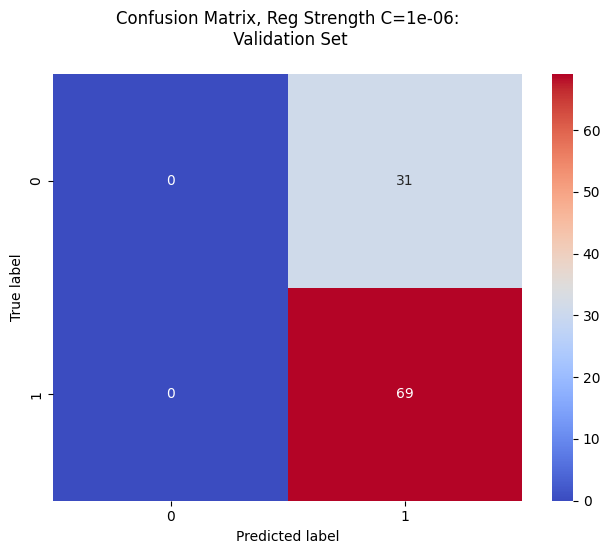

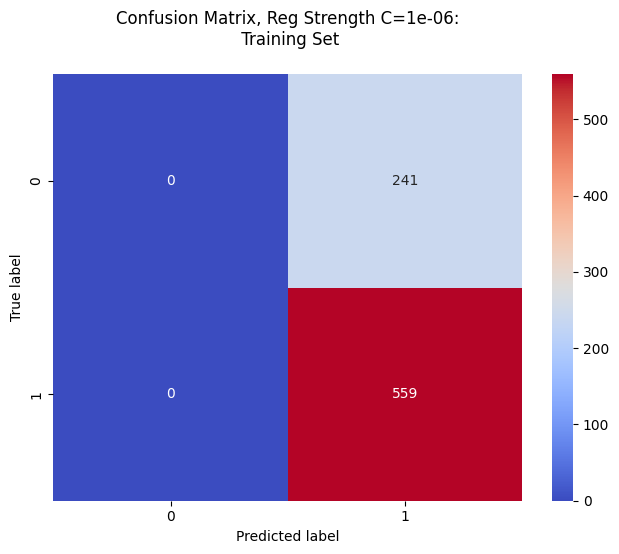

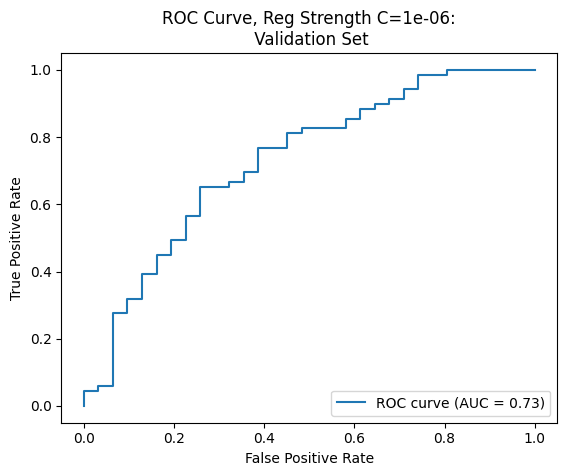

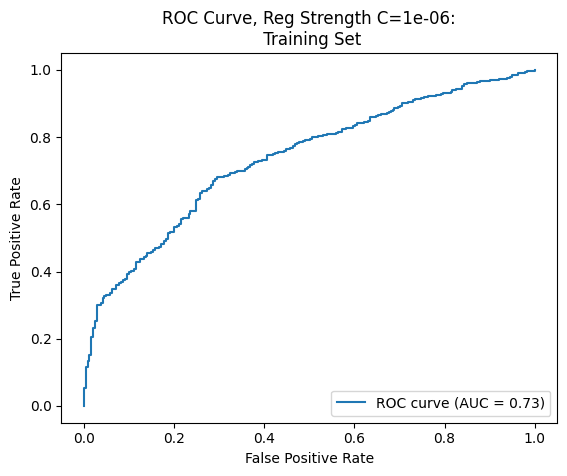

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 0.0001..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
       macro avg       0.35      0.50      0.41       800
    weighted avg       0.49      0.70      0.57       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

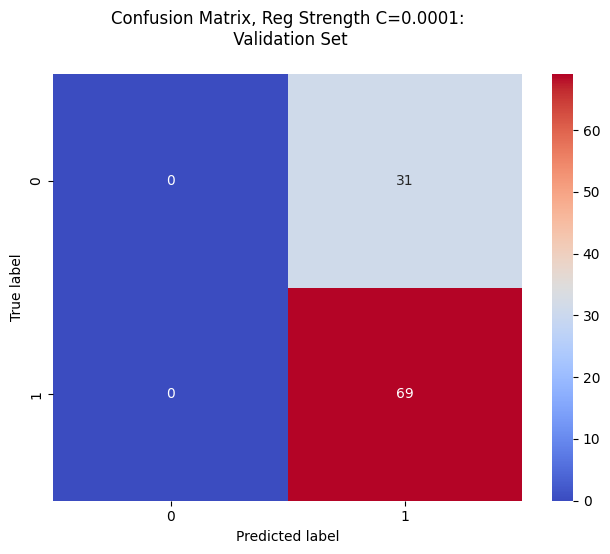

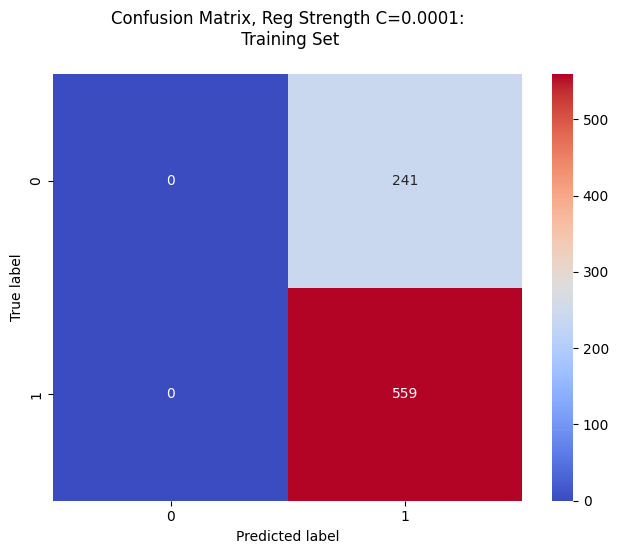

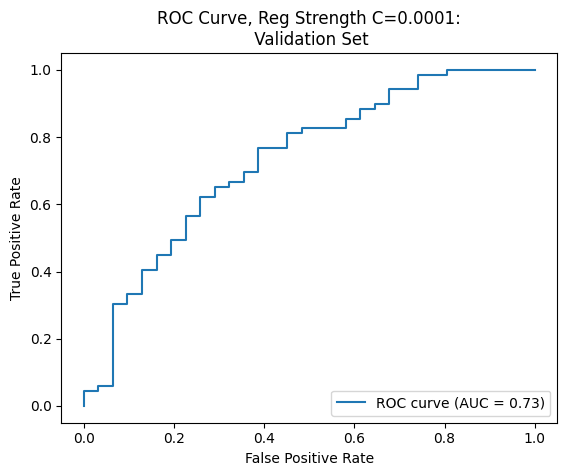

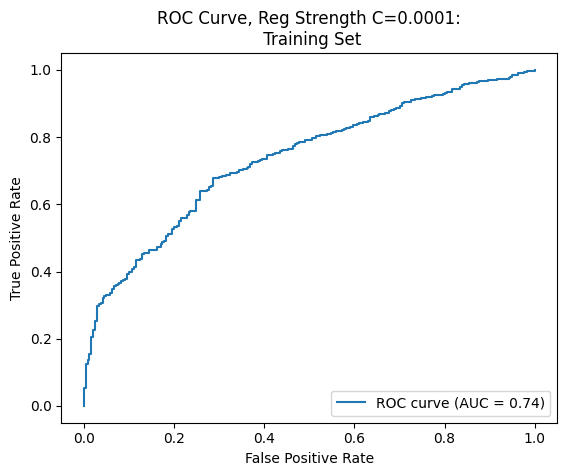

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 0.01..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       1.00      0.23      0.37        31
good credit risk       0.74      1.00      0.85        69

        accuracy                           0.76       100
       macro avg       0.87      0.61      0.61       100
    weighted avg       0.82      0.76      0.70       100

Accuracy: 0.76
Recall: 1.0
Precision: 0.74
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.67      0.13      0.22       241
good credit risk       0.72      0.97      0.83       559

        accuracy                           0.72       800
       macro avg       0.70      0.55      0.52       800
    weighted avg       0.71      0.72      0.64       80

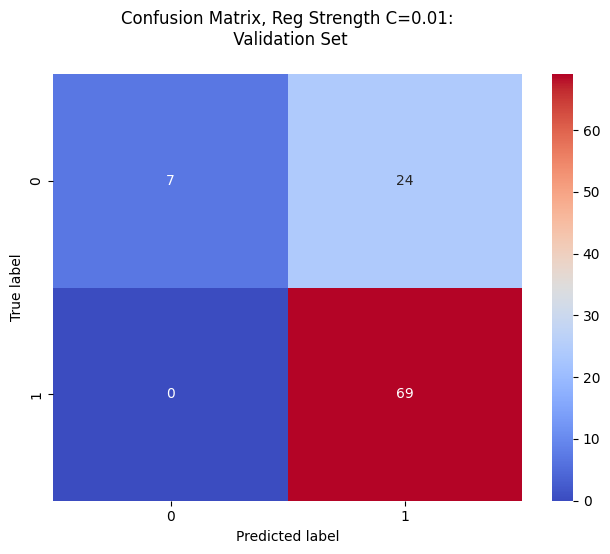

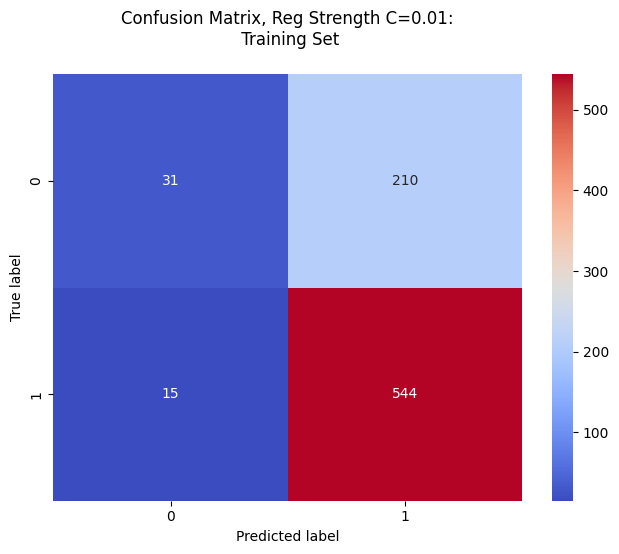

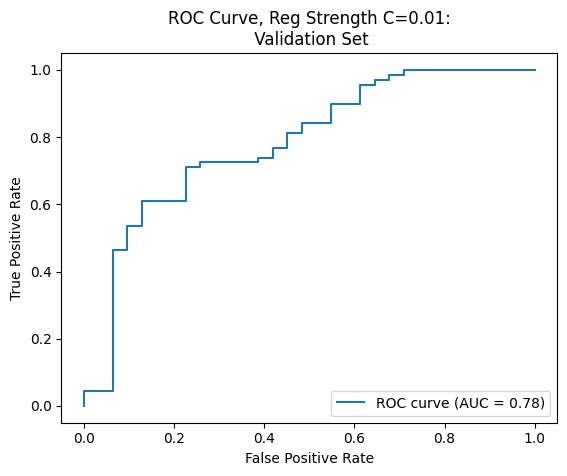

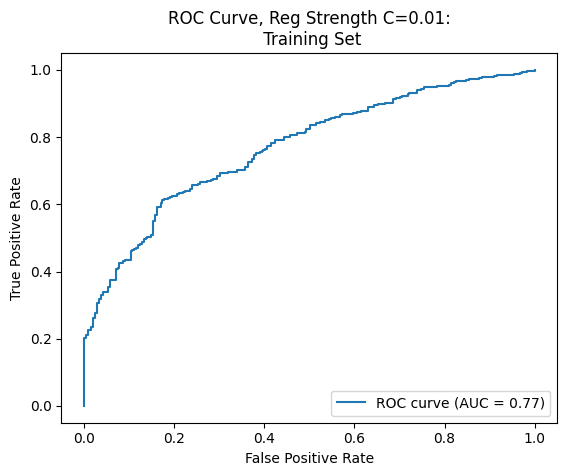

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.75      0.48      0.59        31
good credit risk       0.80      0.93      0.86        69

        accuracy                           0.79       100
       macro avg       0.78      0.71      0.72       100
    weighted avg       0.78      0.79      0.78       100

Accuracy: 0.79
Recall: 0.93
Precision: 0.8
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.66      0.42      0.52       241
good credit risk       0.78      0.91      0.84       559

        accuracy                           0.76       800
       macro avg       0.72      0.66      0.68       800
    weighted avg       0.75      0.76      0.74       800



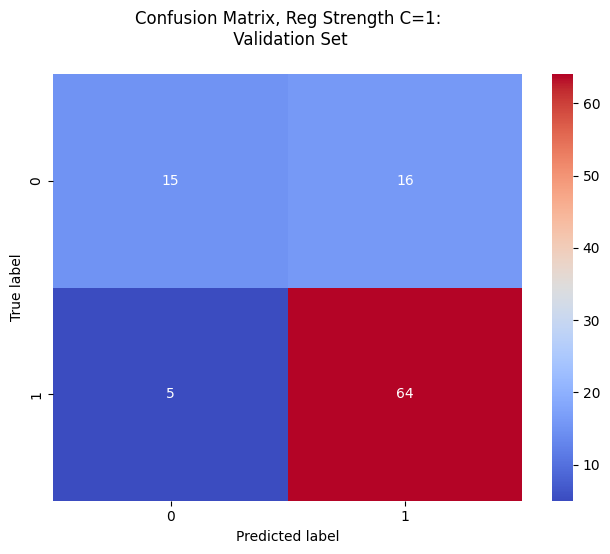

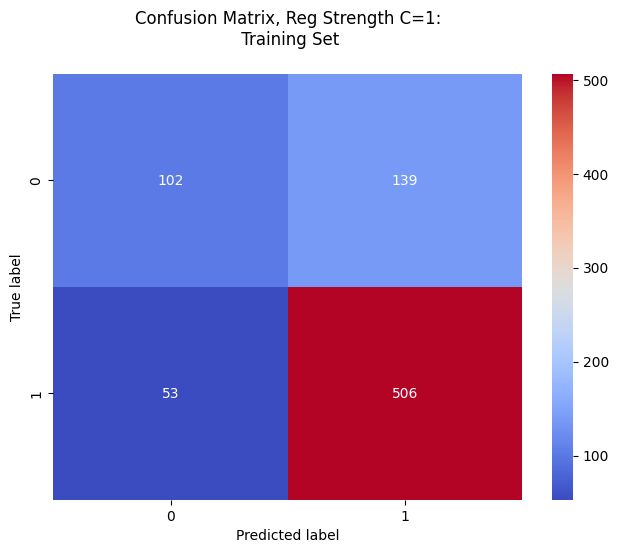

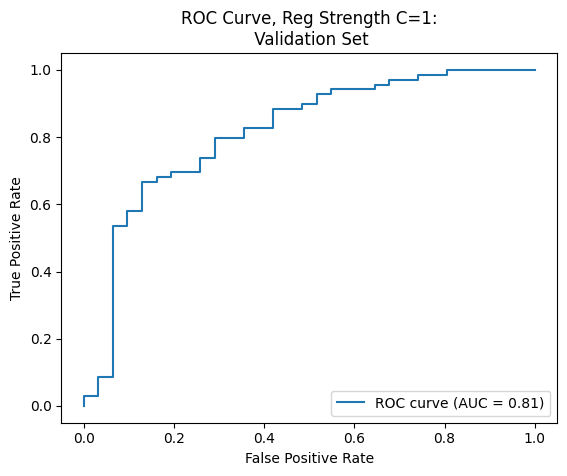

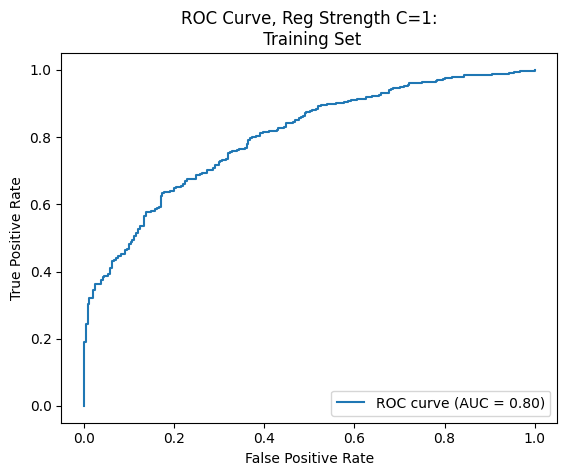

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 100..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.71      0.48      0.58        31
good credit risk       0.80      0.91      0.85        69

        accuracy                           0.78       100
       macro avg       0.76      0.70      0.71       100
    weighted avg       0.77      0.78      0.77       100

Accuracy: 0.78
Recall: 0.91
Precision: 0.8
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.66      0.44      0.53       241
good credit risk       0.79      0.90      0.84       559

        accuracy                           0.76       800
       macro avg       0.72      0.67      0.69       800
    weighted avg       0.75      0.76      0.75       800

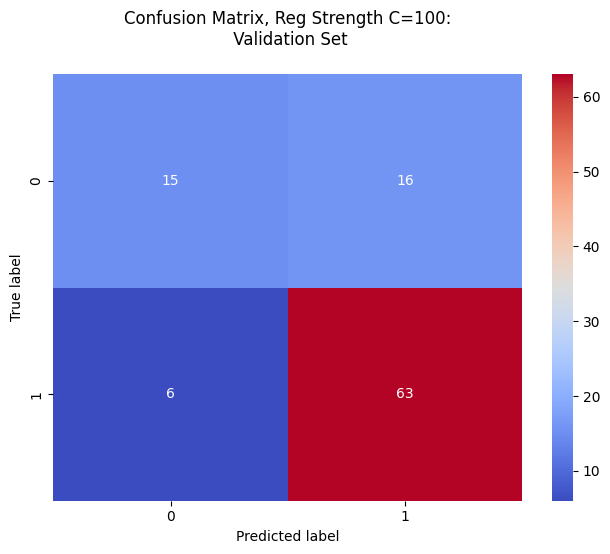

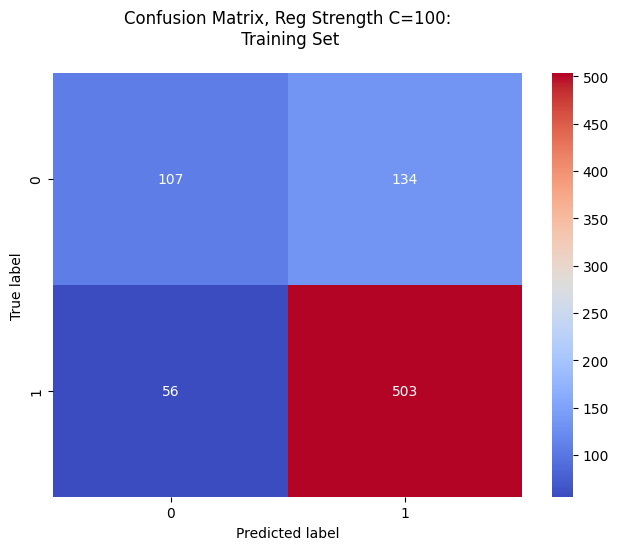

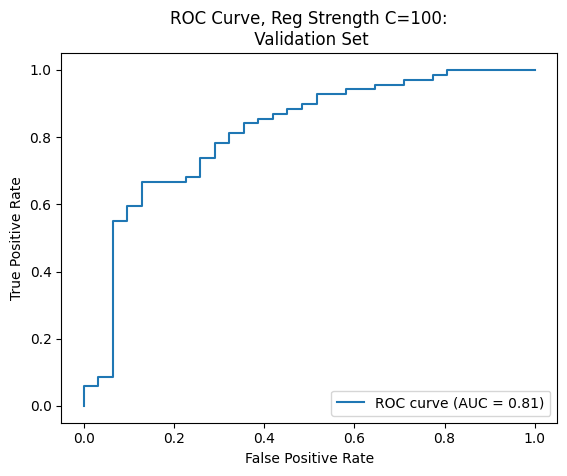

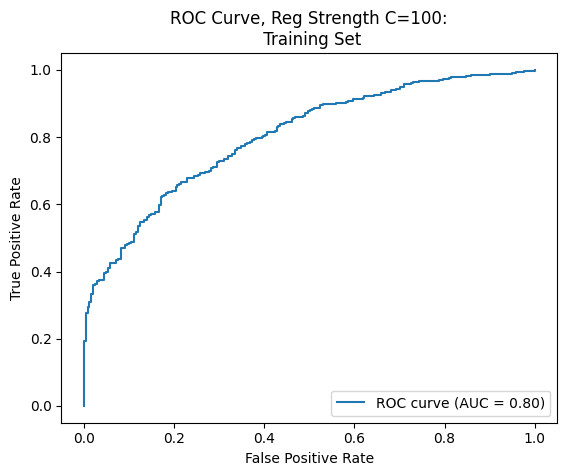

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 10000..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.71      0.48      0.58        31
good credit risk       0.80      0.91      0.85        69

        accuracy                           0.78       100
       macro avg       0.76      0.70      0.71       100
    weighted avg       0.77      0.78      0.77       100

Accuracy: 0.78
Recall: 0.91
Precision: 0.8
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.66      0.44      0.53       241
good credit risk       0.79      0.90      0.84       559

        accuracy                           0.76       800
       macro avg       0.72      0.67      0.69       800
    weighted avg       0.75      0.76      0.75       8

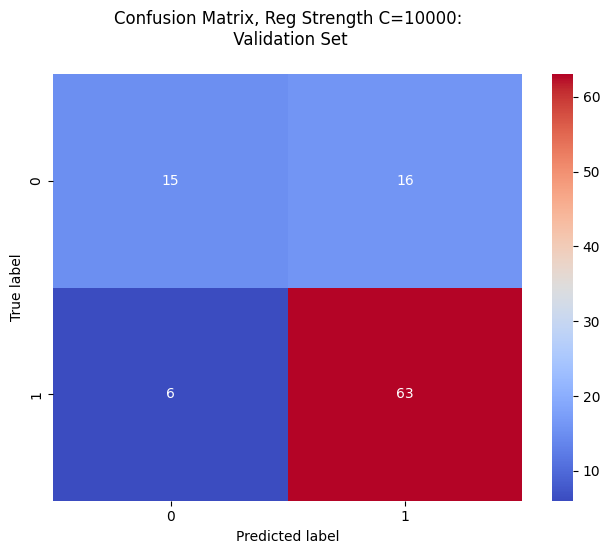

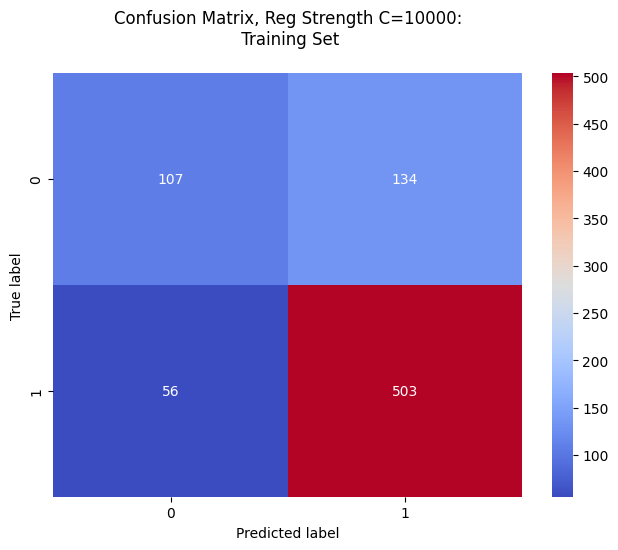

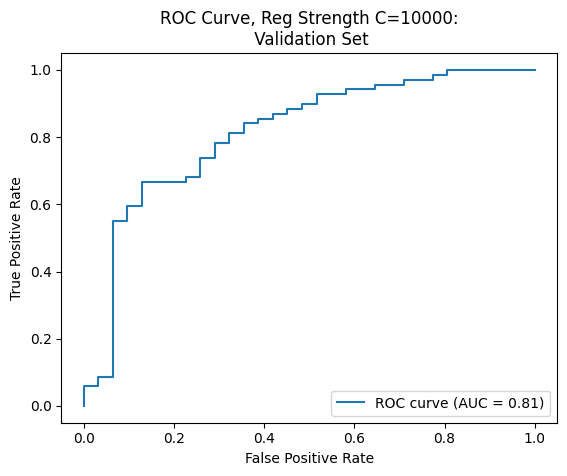

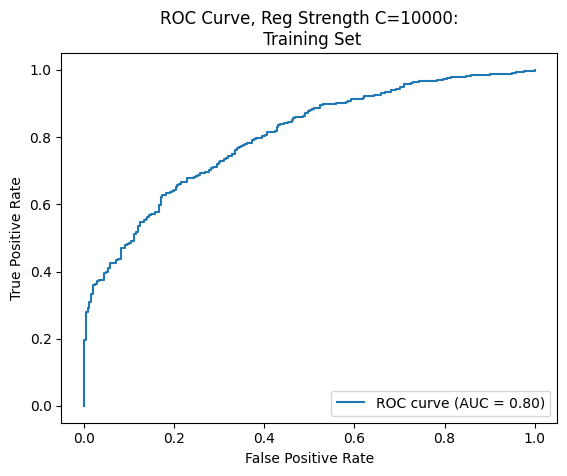

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1000000..................
Metrics on validation set:
                  precision    recall  f1-score   support

 bad credit risk       0.71      0.48      0.58        31
good credit risk       0.80      0.91      0.85        69

        accuracy                           0.78       100
       macro avg       0.76      0.70      0.71       100
    weighted avg       0.77      0.78      0.77       100

Accuracy: 0.78
Recall: 0.91
Precision: 0.8
Metrics on training set:
                  precision    recall  f1-score   support

 bad credit risk       0.66      0.44      0.53       241
good credit risk       0.79      0.90      0.84       559

        accuracy                           0.76       800
       macro avg       0.72      0.67      0.69       800
    weighted avg       0.75      0.76      0.75      

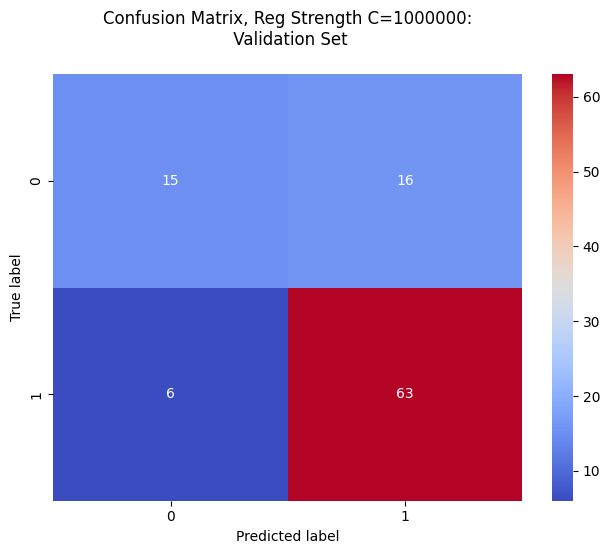

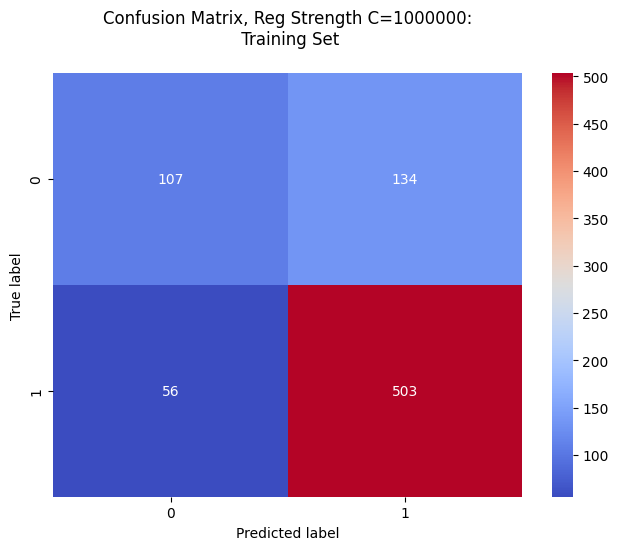

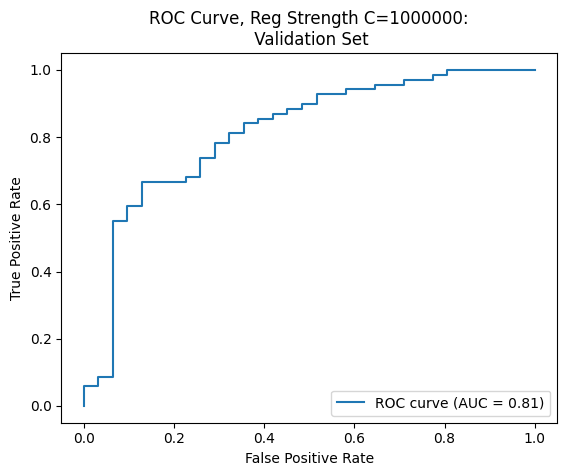

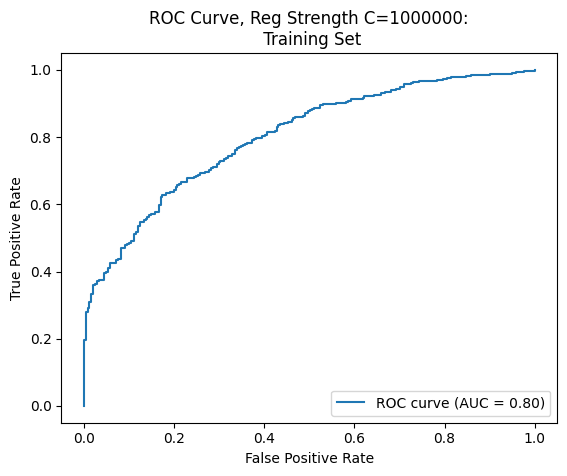

---------------------------------------------------------------------
The best reg_C is 1, with auc = 0.8143992519869098 on the validation set.


In [27]:
# [G] Regularization (at least 6 values)

reg_C_vals = [ 10**x for x in range(-6,7,2) ]
best_reg_C = None
best_auc = -1

# Try different values for regularization strength and see how it performs using * VALIDATION * set
# At the end, choose the best and evaluate model performance on test set
for reg_C in reg_C_vals:
  print("---------------------------------------------------------------------")
  print(f"Trying Regularisation Inverse Strength C = {reg_C}..................")
  logreg_regularized = LogisticRegression(penalty='l2', C=reg_C, solver='lbfgs', max_iter=1000)
  logreg_regularized.fit(X_train, y_train)
  y_predict_regularized = logreg_regularized.predict(X_val)
  y_predict_regularized_train = logreg_regularized.predict(X_train)
  y_predict_prob_reg = logreg_regularized.predict_proba(X_val)[::, 1]
  y_predict_prob_reg_train = logreg_regularized.predict_proba(X_train)[::, 1]

  # Display metrics
  cnf_matrix_regularized = get_confusion_matrix(y_val, y_predict_regularized)
  cnf_matrix_regularized_train = get_confusion_matrix(y_train, y_predict_regularized_train)
  visualize_confusion_matrix(cnf_matrix_regularized, class_names=[0, 1], title=f'Confusion Matrix, Reg Strength C={reg_C}:\n Validation Set')
  visualize_confusion_matrix(cnf_matrix_regularized_train, class_names=[0, 1], title=f'Confusion Matrix, Reg Strength C={reg_C}:\n Training Set')

  print("Metrics on validation set:")
  display_metrics(y_val, y_predict_regularized, cnf_matrix_regularized, target_names=target_names)
  print("Metrics on training set:")
  display_metrics(y_train, y_predict_regularized_train, cnf_matrix_regularized_train, target_names=target_names)
  auc = visualize_ROC_plot(y_val, y_predict_prob_reg, class_mapping=class_mapping, title=f"ROC Curve, Reg Strength C={reg_C}:\n Validation Set")
  visualize_ROC_plot(y_train, y_predict_prob_reg_train, class_mapping=class_mapping, title=f"ROC Curve, Reg Strength C={reg_C}:\n Training Set")
  if auc > best_auc:
    best_auc = auc
    best_reg_C = reg_C
  print("---------------------------------------------------------------------")

print(f"The best reg_C is {best_reg_C}, with auc = {best_auc} on the validation set.")


                  precision    recall  f1-score   support

 bad credit risk       0.38      0.21      0.27        28
good credit risk       0.74      0.86      0.79        72

        accuracy                           0.68       100
       macro avg       0.56      0.54      0.53       100
    weighted avg       0.64      0.68      0.65       100

Accuracy: 0.68
Recall: 0.86
Precision: 0.74


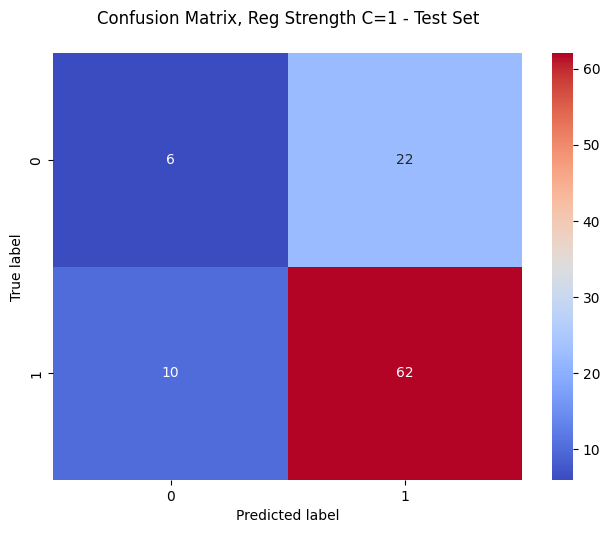

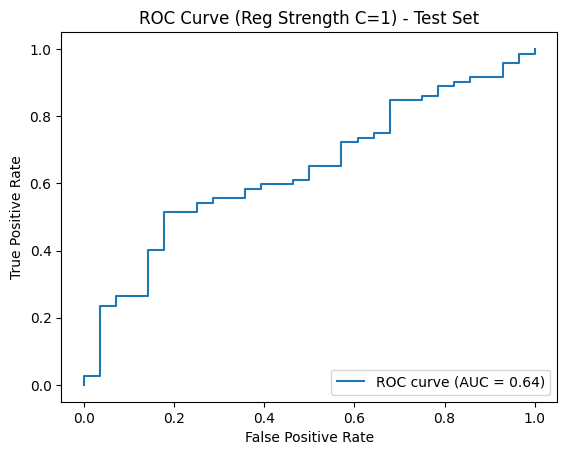

0.6393849206349207

In [28]:
# [G] regularization - cont

# Train the logistic regression model with the best regularization strength (no feature transform)
logreg_regularized = LogisticRegression(penalty='l2', C=best_reg_C, solver='lbfgs', max_iter=1000)
logreg_regularized.fit(X_train, y_train)
y_predict_regularized = logreg_regularized.predict(X_test)

# Evaluate final performance (no feature transform)
cnf_matrix_regularized = get_confusion_matrix(y_test, y_predict_regularized)
visualize_confusion_matrix(cnf_matrix_regularized, class_names=[0, 1], title=f"Confusion Matrix, Reg Strength C={best_reg_C} - Test Set")

display_metrics(y_test, y_predict_regularized, cnf_matrix_regularized, target_names=target_names)
y_predict_prob = logreg_regularized.predict_proba(X_test)[::, 1]
visualize_ROC_plot(y_test, y_predict_prob, class_mapping=class_mapping, title=f"ROC Curve (Reg Strength C={best_reg_C}) - Test Set")


# SECTION [G] DONE ✅ (Everything Finished)

The best reg_C is 1
Final Polynomial deg 3 feature transform: 
                  precision    recall  f1-score   support

 bad credit risk       0.55      0.61      0.58        28
good credit risk       0.84      0.81      0.82        72

        accuracy                           0.75       100
       macro avg       0.69      0.71      0.70       100
    weighted avg       0.76      0.75      0.75       100

Accuracy: 0.75
Recall: 0.81
Precision: 0.84


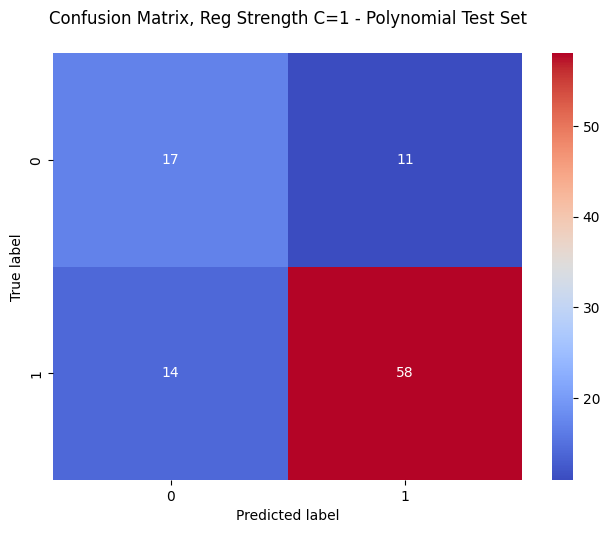

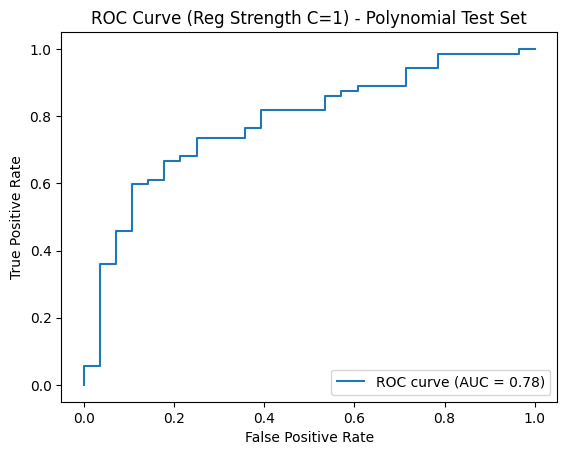

Final PCA feature transform: 
                  precision    recall  f1-score   support

 bad credit risk       0.41      0.25      0.31        28
good credit risk       0.75      0.86      0.80        72

        accuracy                           0.69       100
       macro avg       0.58      0.56      0.56       100
    weighted avg       0.65      0.69      0.66       100

Accuracy: 0.69
Recall: 0.86
Precision: 0.75


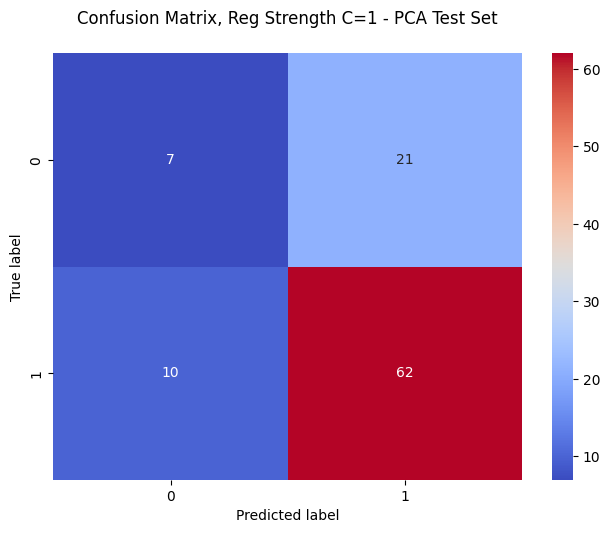

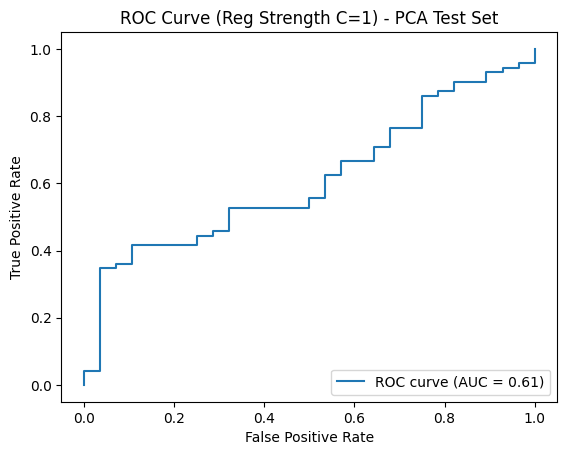

Final RBF kernel feature transform: 
                  precision    recall  f1-score   support

 bad credit risk       0.47      0.25      0.33        28
good credit risk       0.75      0.89      0.82        72

        accuracy                           0.71       100
       macro avg       0.61      0.57      0.57       100
    weighted avg       0.67      0.71      0.68       100

Accuracy: 0.71
Recall: 0.89
Precision: 0.75


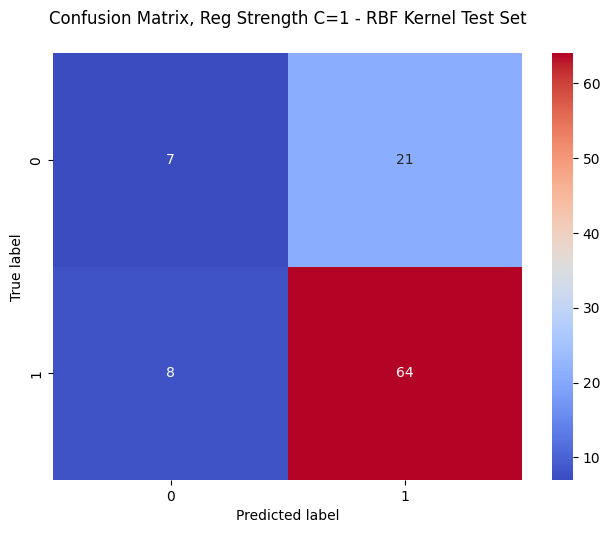

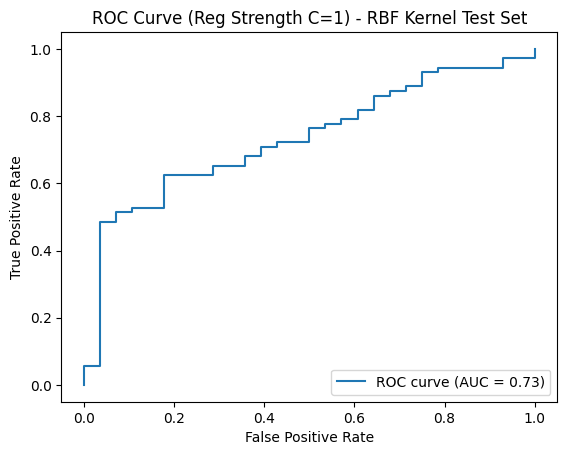

0.7341269841269841

In [29]:
# [G] Regularization with feature transformations - trained with the best regularization param

print(f"The best reg_C is {best_reg_C}")

# [F1] Polynomial Transform
logreg_regularized_poly = LogisticRegression(penalty='l2', C=best_reg_C, solver='lbfgs', max_iter=1000)
logreg_regularized_poly.fit(X_train_polynomial, y_train)
y_predict_regularized_poly = logreg_regularized_poly.predict(X_test_polynomial)

cnf_matrix_regularized_poly = get_confusion_matrix(y_test, y_predict_regularized_poly)
visualize_confusion_matrix(cnf_matrix_regularized_poly, class_names=[0, 1], title=f"Confusion Matrix, Reg Strength C={best_reg_C} - Polynomial Test Set")

print("Final Polynomial deg 3 feature transform: ")
display_metrics(y_test, y_predict_regularized_poly, cnf_matrix_regularized_poly, target_names=target_names)
y_predict_prob_poly = logreg_regularized_poly.predict_proba(X_test_polynomial)[::, 1]
visualize_ROC_plot(y_test, y_predict_prob_poly, class_mapping=class_mapping, title=f"ROC Curve (Reg Strength C={best_reg_C}) - Polynomial Test Set")

# [F2] PCA Transform
logreg_regularized_pca = LogisticRegression(penalty='l2', C=best_reg_C, solver='lbfgs', max_iter=1000)
logreg_regularized_pca.fit(X_train_pca, y_train)
y_predict_regularized_pca = logreg_regularized_pca.predict(X_test_pca)

cnf_matrix_regularized_pca = get_confusion_matrix(y_test, y_predict_regularized_pca)
visualize_confusion_matrix(cnf_matrix_regularized_pca, class_names=[0, 1], title=f"Confusion Matrix, Reg Strength C={best_reg_C} - PCA Test Set")

print("Final PCA feature transform: ")
display_metrics(y_test, y_predict_regularized_pca, cnf_matrix_regularized_pca, target_names=target_names)
y_predict_prob_pca = logreg_regularized_pca.predict_proba(X_test_pca)[::, 1]
visualize_ROC_plot(y_test, y_predict_prob_pca, class_mapping=class_mapping, title=f"ROC Curve (Reg Strength C={best_reg_C}) - PCA Test Set")

# [F3] RBF Kernel Transform
logreg_regularized_rbf = LogisticRegression(penalty='l2', C=best_reg_C, solver='lbfgs', max_iter=1000)
logreg_regularized_rbf.fit(X_train_rbf, y_train)
y_predict_regularized_rbf = logreg_regularized_rbf.predict(X_test_rbf)

cnf_matrix_regularized_rbf = get_confusion_matrix(y_test, y_predict_regularized_rbf)
visualize_confusion_matrix(cnf_matrix_regularized_rbf, class_names=[0, 1], title=f"Confusion Matrix, Reg Strength C={best_reg_C} - RBF Kernel Test Set")

print("Final RBF kernel feature transform: ")
display_metrics(y_test, y_predict_regularized_rbf, cnf_matrix_regularized_rbf, target_names=target_names)
y_predict_prob_rbf = logreg_regularized_rbf.predict_proba(X_test_rbf)[::, 1]
visualize_ROC_plot(y_test, y_predict_prob_rbf, class_mapping=class_mapping, title=f"ROC Curve (Reg Strength C={best_reg_C}) - RBF Kernel Test Set")


In [30]:
# Final Best for Logistic Regression
# Feature Transform: Polynomial degree 3
# reg C = 1

In [33]:
## Training: Neural Network, sigmoid as activation function (no regularization)
# Use MLPClassifier with the sigmoid activation function
hidden_layers_amounts = [2, 10, 15, 30]
num_hidden_layers = hidden_layers_amounts[0]
model = MLPClassifier(hidden_layer_sizes=(num_hidden_layers,), activation='logistic', solver='adam', max_iter=1000)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_predict_train = model.predict(X_train)
# print(y_predict[:5])
# print(y_test[:5])
# SECTION [C] DONE ✅

In [34]:
## Evaluation: use test set
# Confusion Matrix
cnf_matrix = get_confusion_matrix(y_test, y_predict)
cnf_matrix_train = get_confusion_matrix(y_train, y_predict_train)

# Structure of Confusion Matrix:
# * Top-left-bottom-right Diagonal = correct predictions
# * 0 for "bad", 1 for "good" credit risk
#             Predicted
#             0       1
# True   0   [ TN   FP ]
#        1   [ FN   TP ]

# Evaluation Metrics
target_names = ['bad credit risk', 'good credit risk']
print("Metrics on test set:")
print(f"Confusion Matrix (on test set):\n {cnf_matrix}")
display_metrics(y_test, y_predict, cnf_matrix, target_names=target_names)

print("--------------------------------------------------------")

print("Metrics on training set:")
print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
display_metrics(y_train, y_predict_train, cnf_matrix_train, target_names=target_names)

# SECTION [D] DONE ✅

Metrics on test set:
Confusion Matrix (on test set):
 [[ 5 23]
 [ 9 63]]
                  precision    recall  f1-score   support

 bad credit risk       0.36      0.18      0.24        28
good credit risk       0.73      0.88      0.80        72

        accuracy                           0.68       100
       macro avg       0.54      0.53      0.52       100
    weighted avg       0.63      0.68      0.64       100

Accuracy: 0.68
Recall: 0.88
Precision: 0.73
--------------------------------------------------------
Metrics on training set:
Confusion Matrix (on training set):
 [[104 137]
 [ 58 501]]
                  precision    recall  f1-score   support

 bad credit risk       0.64      0.43      0.52       241
good credit risk       0.79      0.90      0.84       559

        accuracy                           0.76       800
       macro avg       0.71      0.66      0.68       800
    weighted avg       0.74      0.76      0.74       800

Accuracy: 0.76
Recall: 0.9
Precision: 0

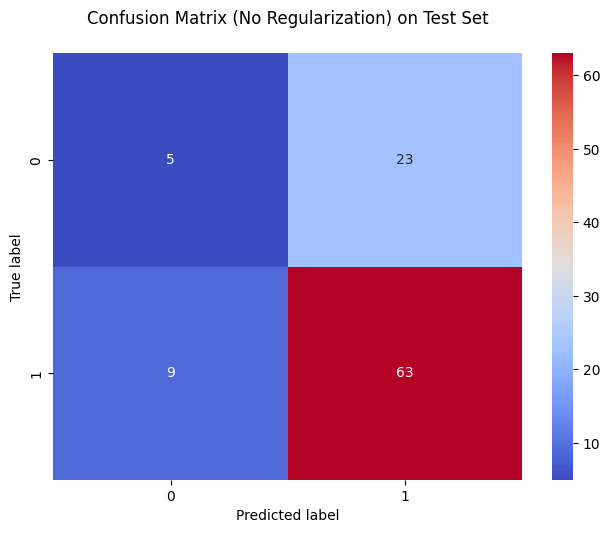

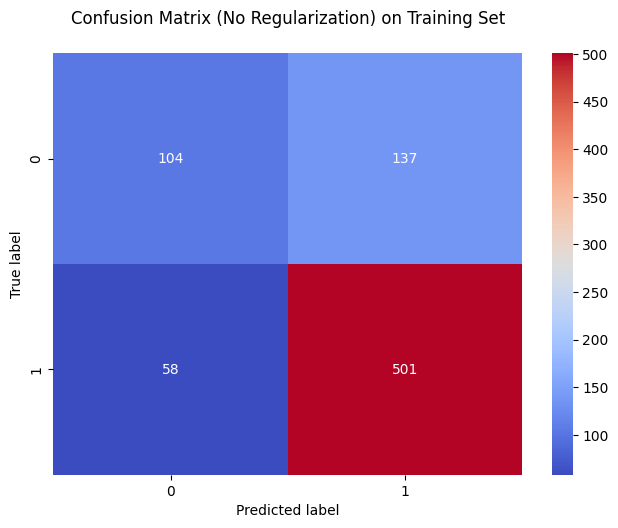

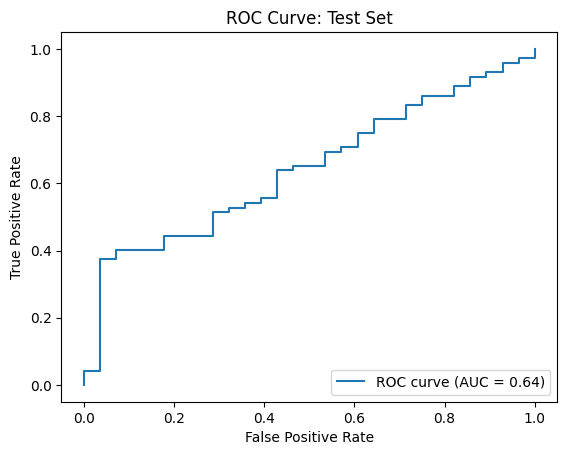

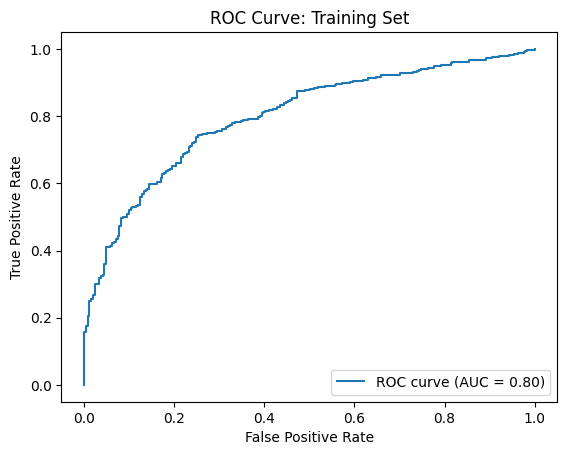

0.7987514752930174

In [35]:
## [E] Visualization
# Confusion Matrix
class_names=[0,1]

visualize_confusion_matrix(cnf_matrix, class_names, "Confusion Matrix (No Regularization) on Test Set")
visualize_confusion_matrix(cnf_matrix_train, class_names, "Confusion Matrix (No Regularization) on Training Set")

class_mapping = {'bad': 0, 'good': 1}
y_predict_prob = model.predict_proba(X_test)[::,1]
y_predict_prob_train = model.predict_proba(X_train)[::,1]

visualize_ROC_plot(y_test, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Test Set")
visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")

# SECTION [E] DONE ✅

---------------------------------------------------------------------
Trying 10 hidden layers............................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[16 15]
 [ 9 60]]
                  precision    recall  f1-score   support

 bad credit risk       0.64      0.52      0.57        31
good credit risk       0.80      0.87      0.83        69

        accuracy                           0.76       100
       macro avg       0.72      0.69      0.70       100
    weighted avg       0.75      0.76      0.75       100

Accuracy: 0.76
Recall: 0.87
Precision: 0.8
Metrics on training set:
Confusion Matrix (on training set):
 [[149  92]
 [ 40 519]]
                  precision    recall  f1-score   support

 bad credit risk       0.79      0.62      0.69       241
good credit risk       0.85      0.93      0.89       559

        accuracy                           0.83       800
       macro avg       0.82      0.77      0.79       800
    weighted avg       0.83      0.83      0.83       800

Accuracy: 0.83
Recall: 0.93
Precision: 0.85
-----------------------------------------

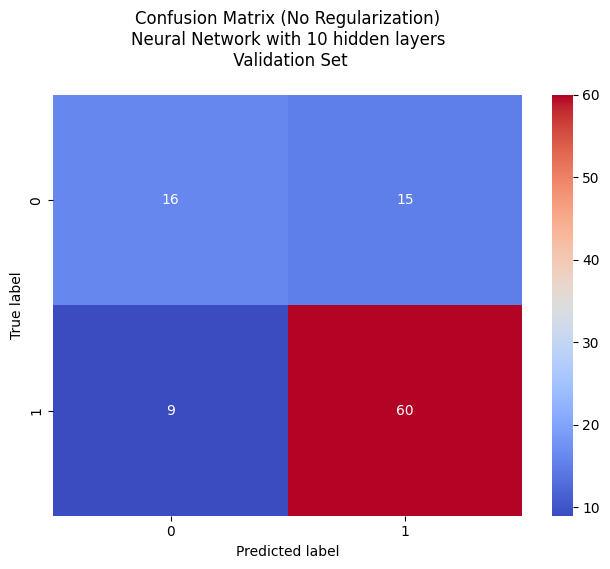

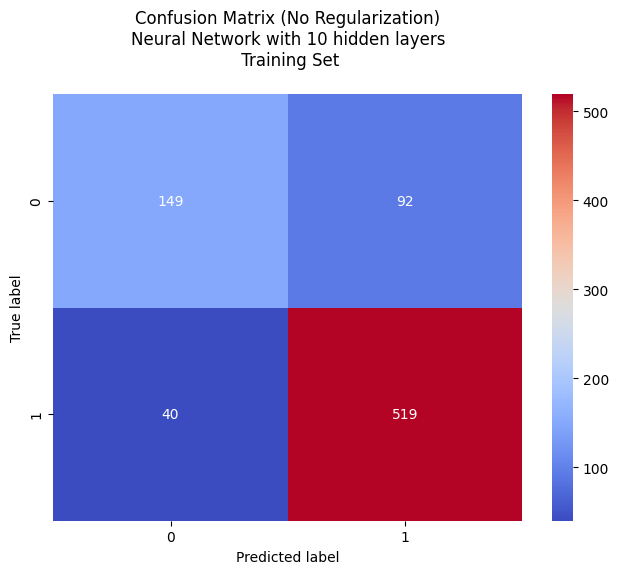

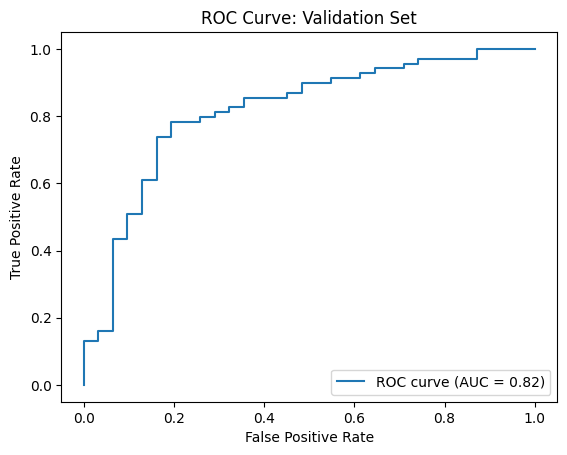

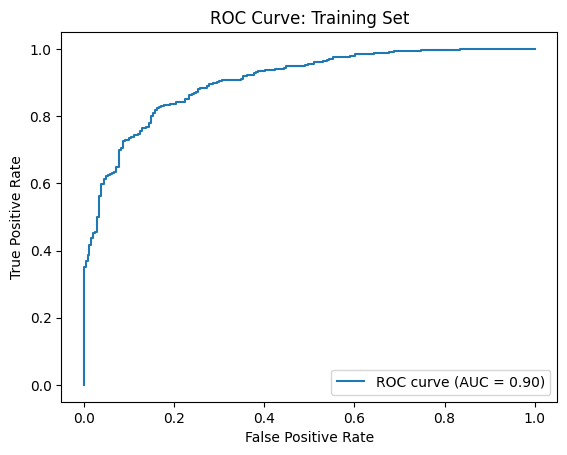

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying 15 hidden layers............................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[19 12]
 [ 8 61]]
                  precision    recall  f1-score   support

 bad credit risk       0.70      0.61      0.66        31
good credit risk       0.84      0.88      0.86        69

        accuracy                           0.80       100
       macro avg       0.77      0.75      0.76       100
    weighted avg       0.79      0.80      0.80       100

Accuracy: 0.80
Recall: 0.88
Precision: 0.84
Metrics on training set:
Confusion Matrix (on training set):
 [[168  73]
 [ 30 529]]
                  precision    recall  f1-score   support

 bad credit risk       0.85      0.70      0.77       241
good credit risk       0.88      0.95      0.91       559

        accuracy                           0.87       800
       macro avg       0.86      0.82      0.84       800
    weighted avg       0.87      0.87      0.87       800

Accuracy: 0.87
Recall: 0.95
Precision: 0.88
----------------------------------------

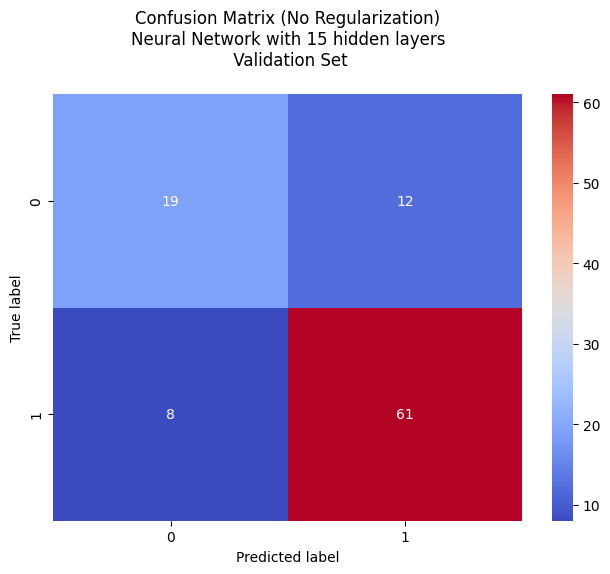

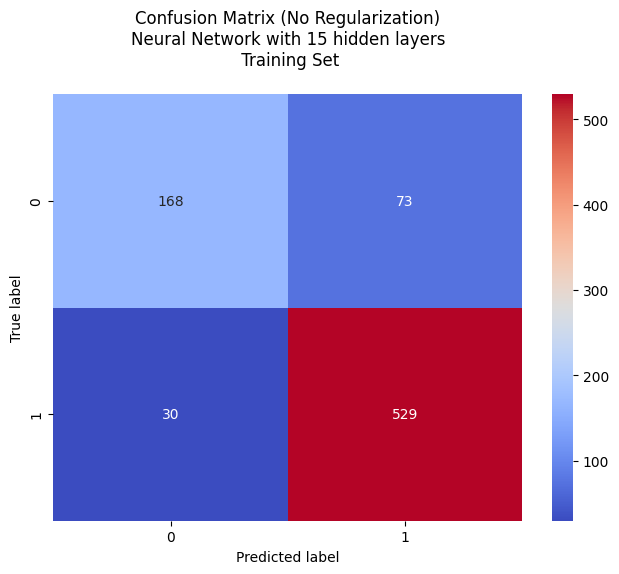

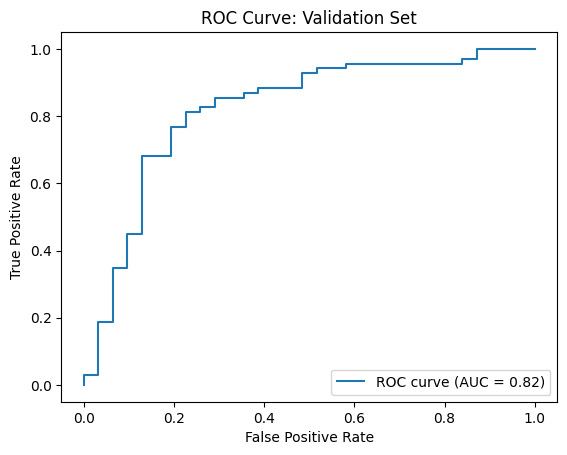

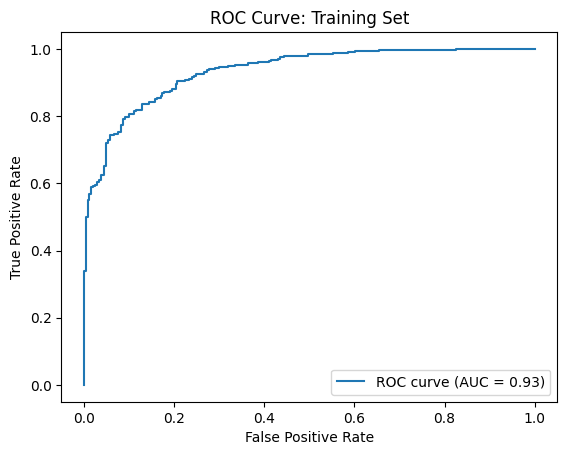

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying 30 hidden layers............................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[17 14]
 [ 9 60]]
                  precision    recall  f1-score   support

 bad credit risk       0.65      0.55      0.60        31
good credit risk       0.81      0.87      0.84        69

        accuracy                           0.77       100
       macro avg       0.73      0.71      0.72       100
    weighted avg       0.76      0.77      0.76       100

Accuracy: 0.77
Recall: 0.87
Precision: 0.81
Metrics on training set:
Confusion Matrix (on training set):
 [[190  51]
 [ 19 540]]
                  precision    recall  f1-score   support

 bad credit risk       0.91      0.79      0.84       241
good credit risk       0.91      0.97      0.94       559

        accuracy                           0.91       800
       macro avg       0.91      0.88      0.89       800
    weighted avg       0.91      0.91      0.91       800

Accuracy: 0.91
Recall: 0.97
Precision: 0.91
----------------------------------------

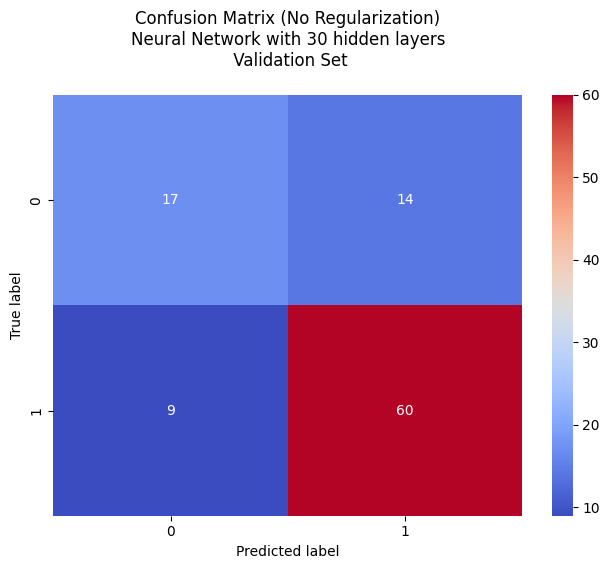

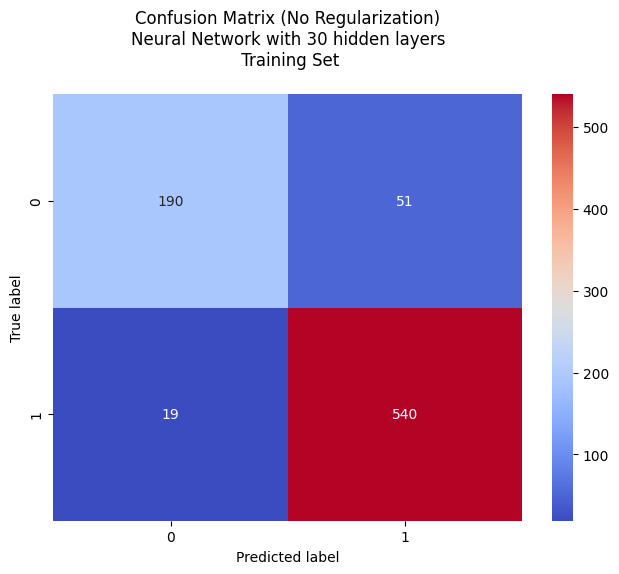

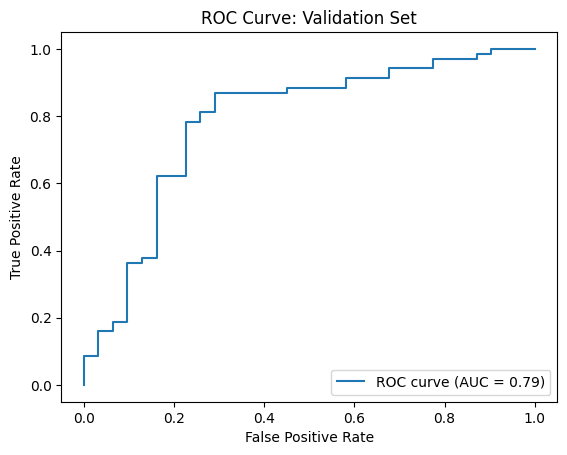

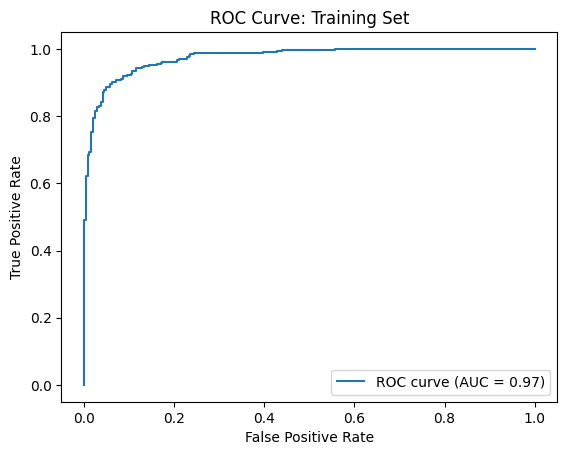

---------------------------------------------------------------------
The best number of hidden layers is 15 with auc = 0.8209443665264142 on validation set.


In [36]:
## [F] Different architectures (at least 3 types)
# Try different amounts of hidden layers in the neural network
# Use validation set! (# of hidden layers is a hyperparameter)
# Previously:
  # hidden_layers_amounts = [2, 10, 15, 30]
  # num_hidden_layers = hidden_layers_amounts[0]

best_hidden_layers = 2
best_auc_for_hidden_layers = -1

for i in range(1, len(hidden_layers_amounts)):
  num_hidden_layers = hidden_layers_amounts[i]
  print("---------------------------------------------------------------------")
  print(f"Trying {num_hidden_layers} hidden layers............................")
  model = MLPClassifier(hidden_layer_sizes=(num_hidden_layers,), activation='logistic', solver='adam', max_iter=1000)
  model.fit(X_train, y_train)
  y_predict = model.predict(X_val)
  y_predict_train = model.predict(X_train)

  # Metrics
  cnf_matrix = get_confusion_matrix(y_val, y_predict)
  cnf_matrix_train = get_confusion_matrix(y_train, y_predict_train)

  print("Metrics on validation set:")
  print(f"Confusion Matrix (on validation set):\n {cnf_matrix}")
  display_metrics(y_val, y_predict, cnf_matrix, target_names=target_names)

  print("Metrics on training set:")
  print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
  display_metrics(y_train, y_predict_train, cnf_matrix_train, target_names=target_names)

  print("--------------------------------------------------------")

  # Visualize
  visualize_confusion_matrix(cnf_matrix, class_names, f"Confusion Matrix (No Regularization)\nNeural Network with {num_hidden_layers} hidden layers\n Validation Set")
  visualize_confusion_matrix(cnf_matrix_train, class_names, f"Confusion Matrix (No Regularization)\nNeural Network with {num_hidden_layers} hidden layers\n Training Set")
  y_predict_prob = model.predict_proba(X_val)[::,1]
  y_predict_prob_train = model.predict_proba(X_train)[::,1]

  auc = visualize_ROC_plot(y_val, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Validation Set")
  visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")

  if auc > best_auc_for_hidden_layers:
    best_auc_for_hidden_layers = auc
    best_hidden_layers = num_hidden_layers

  print("---------------------------------------------------------------------")

print(f"The best number of hidden layers is {best_hidden_layers} with auc = {best_auc_for_hidden_layers} on validation set.")

# SECTION [F] DONE ✅

---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1e-06..................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[19 12]
 [ 6 63]]
                  precision    recall  f1-score   support

 bad credit risk       0.76      0.61      0.68        31
good credit risk       0.84      0.91      0.88        69

        accuracy                           0.82       100
       macro avg       0.80      0.76      0.78       100
    weighted avg       0.82      0.82      0.81       100

Accuracy: 0.82
Recall: 0.91
Precision: 0.84
Metrics on training set:
Confusion Matrix (on training set):
 [[155  86]
 [ 37 522]]
                  precision    recall  f1-score   support

 bad credit risk       0.81      0.64      0.72       241
good credit risk       0.86      0.93      0.89       559

        accuracy                           0.85       800
       macro avg       0.83      0.79      0.81       800
    weighted avg       0.84      0.85      0.84       800

Accuracy: 0.85
Recall: 0.93
Precision: 0.86


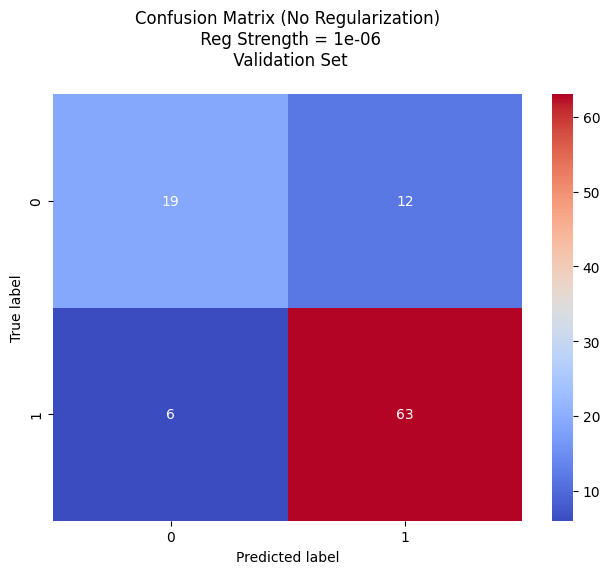

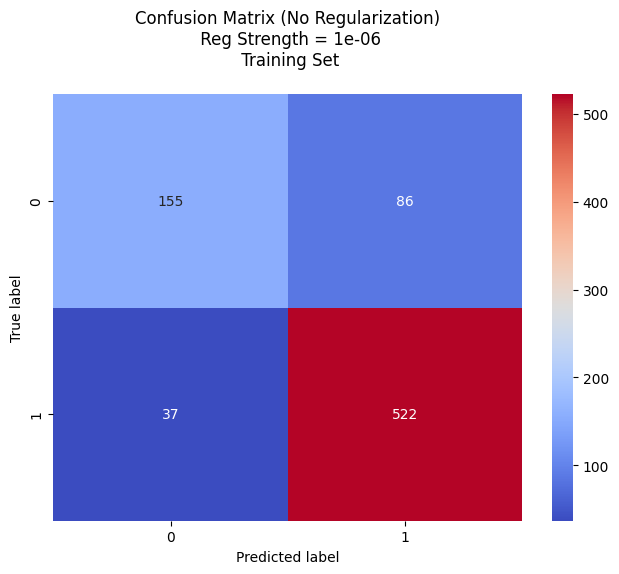

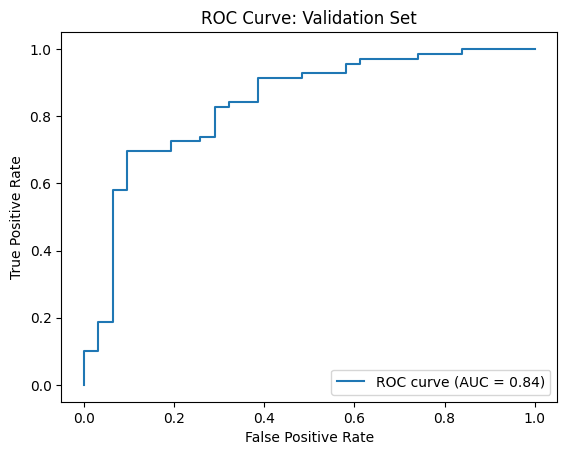

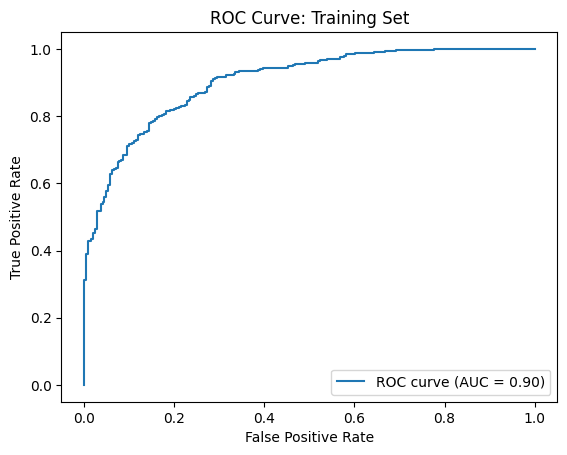

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 0.0001..................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[17 14]
 [ 7 62]]
                  precision    recall  f1-score   support

 bad credit risk       0.71      0.55      0.62        31
good credit risk       0.82      0.90      0.86        69

        accuracy                           0.79       100
       macro avg       0.76      0.72      0.74       100
    weighted avg       0.78      0.79      0.78       100

Accuracy: 0.79
Recall: 0.9
Precision: 0.82
Metrics on training set:
Confusion Matrix (on training set):
 [[150  91]
 [ 43 516]]
                  precision    recall  f1-score   support

 bad credit risk       0.78      0.62      0.69       241
good credit risk       0.85      0.92      0.89       559

        accuracy                           0.83       800
       macro avg       0.81      0.77      0.79       800
    weighted avg       0.83      0.83      0.83       800

Accuracy: 0.83
Recall: 0.92
Precision: 0.85


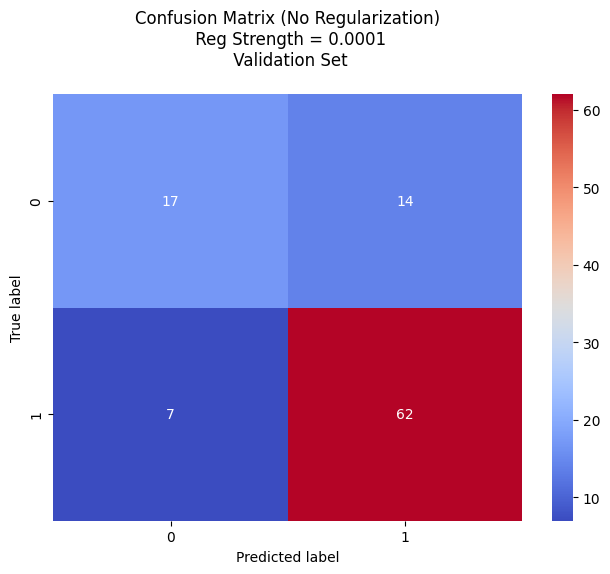

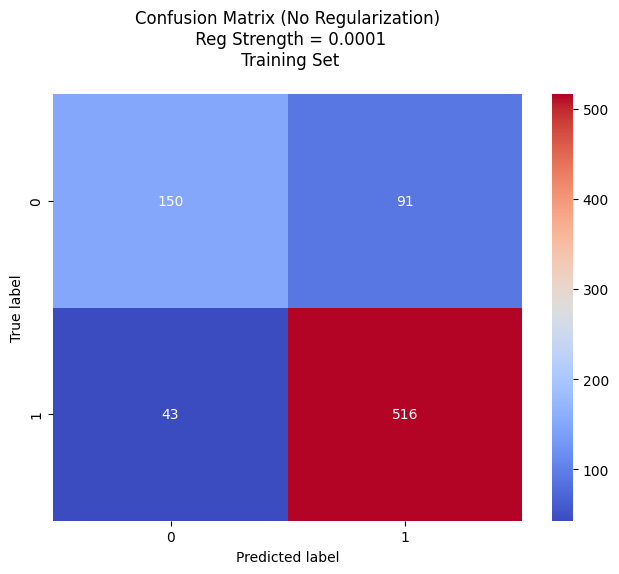

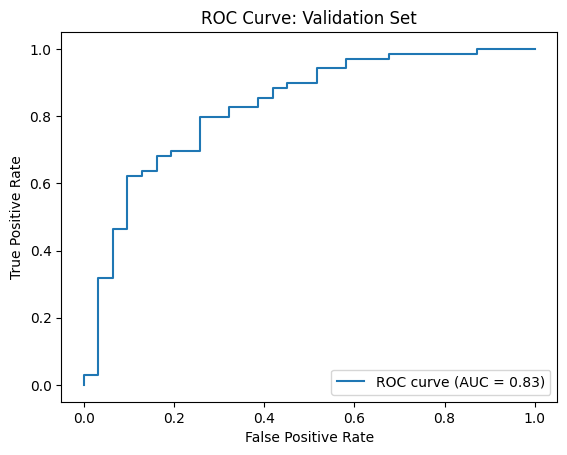

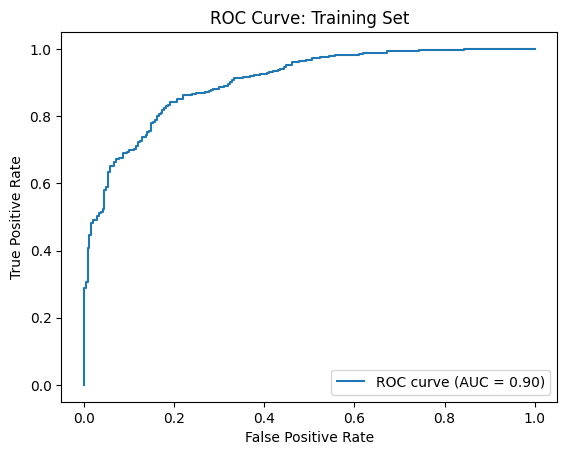

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 0.01..................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[18 13]
 [ 8 61]]
                  precision    recall  f1-score   support

 bad credit risk       0.69      0.58      0.63        31
good credit risk       0.82      0.88      0.85        69

        accuracy                           0.79       100
       macro avg       0.76      0.73      0.74       100
    weighted avg       0.78      0.79      0.78       100

Accuracy: 0.79
Recall: 0.88
Precision: 0.82
Metrics on training set:
Confusion Matrix (on training set):
 [[152  89]
 [ 42 517]]
                  precision    recall  f1-score   support

 bad credit risk       0.78      0.63      0.70       241
good credit risk       0.85      0.92      0.89       559

        accuracy                           0.84       800
       macro avg       0.82      0.78      0.79       800
    weighted avg       0.83      0.84      0.83       800

Accuracy: 0.84
Recall: 0.92
Precision: 0.85


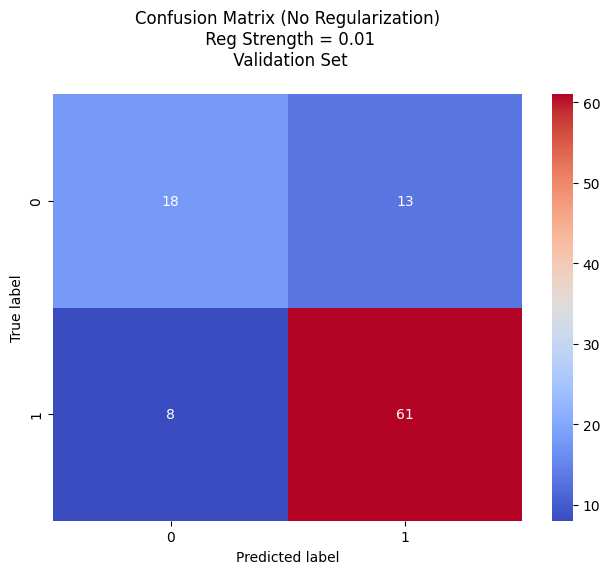

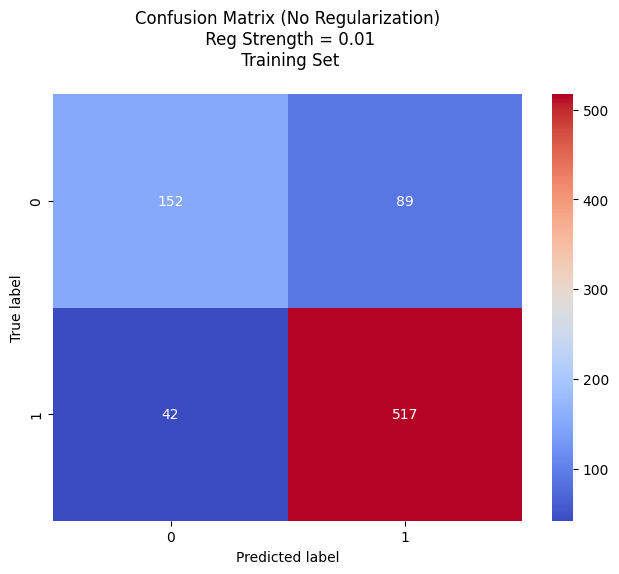

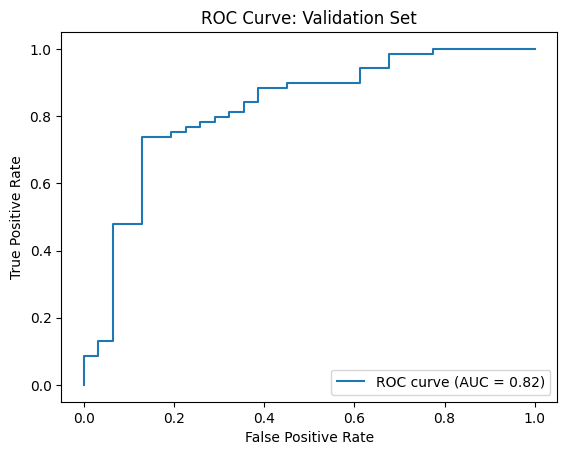

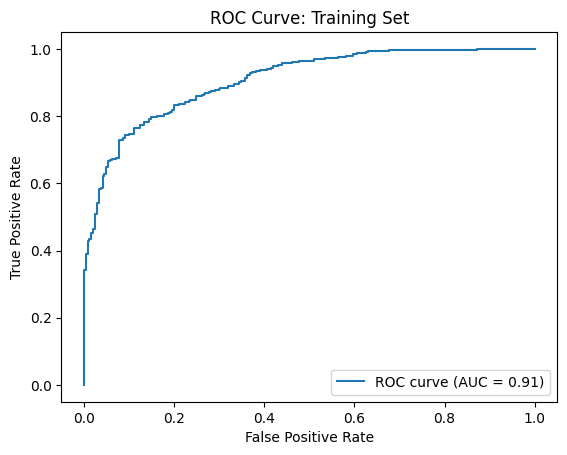

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1..................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[11 20]
 [ 4 65]]
                  precision    recall  f1-score   support

 bad credit risk       0.73      0.35      0.48        31
good credit risk       0.76      0.94      0.84        69

        accuracy                           0.76       100
       macro avg       0.75      0.65      0.66       100
    weighted avg       0.75      0.76      0.73       100

Accuracy: 0.76
Recall: 0.94
Precision: 0.76
Metrics on training set:
Confusion Matrix (on training set):
 [[ 74 167]
 [ 40 519]]
                  precision    recall  f1-score   support

 bad credit risk       0.65      0.31      0.42       241
good credit risk       0.76      0.93      0.83       559

        accuracy                           0.74       80

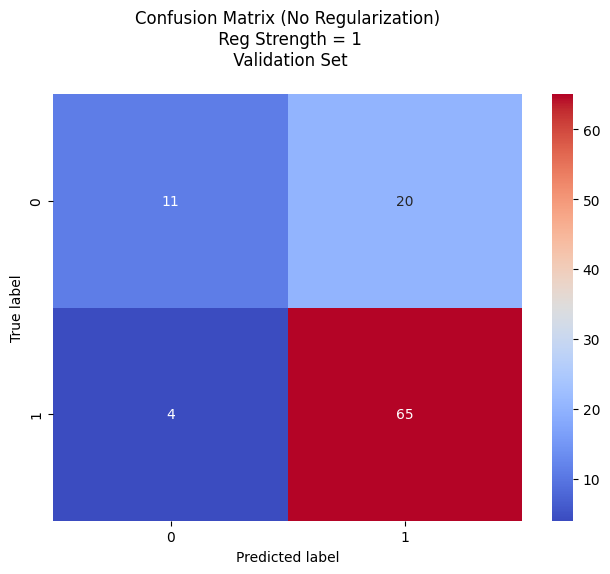

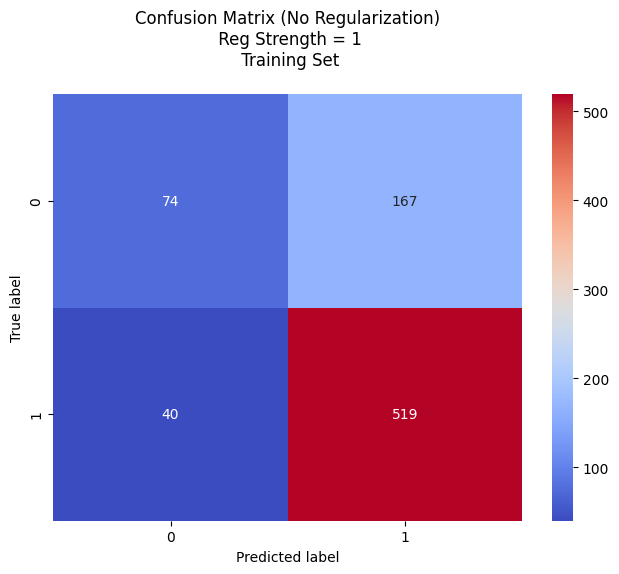

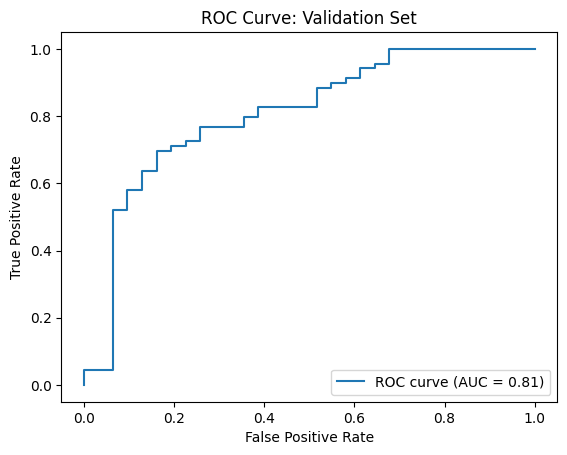

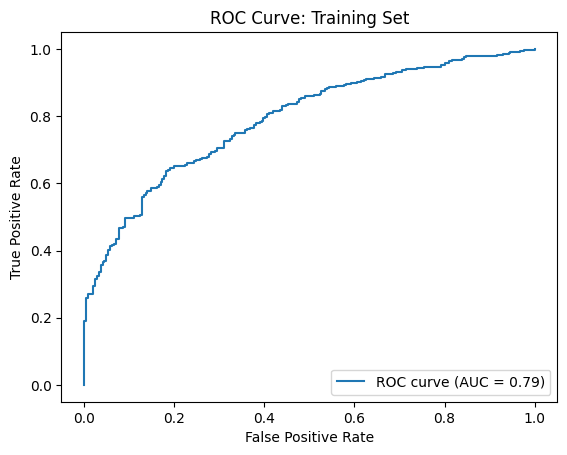

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 100..................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       8

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

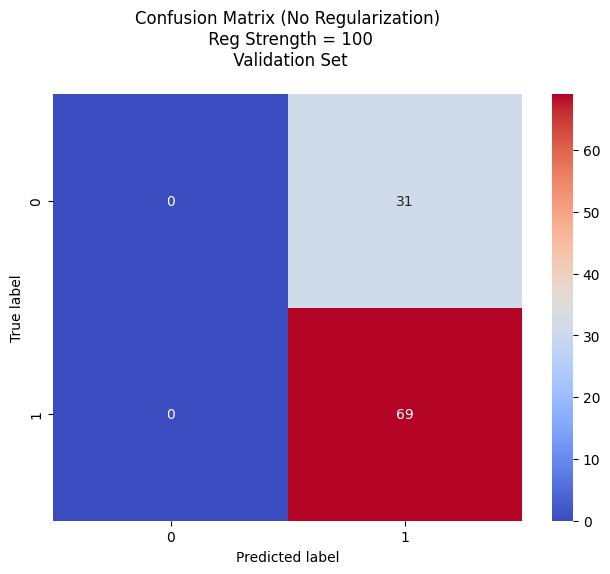

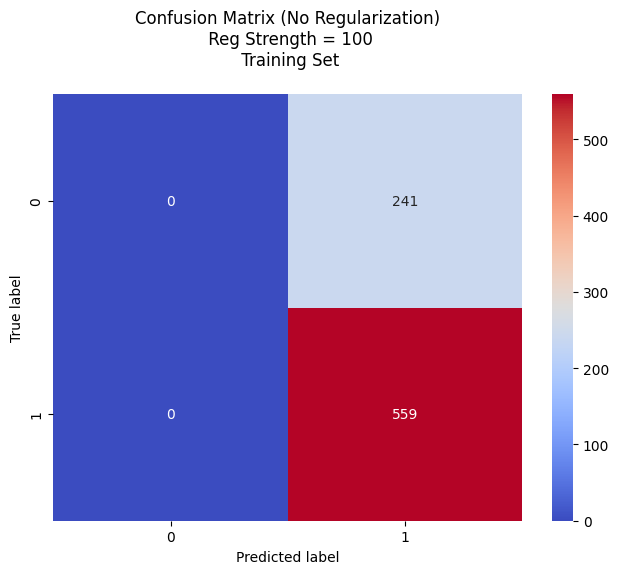

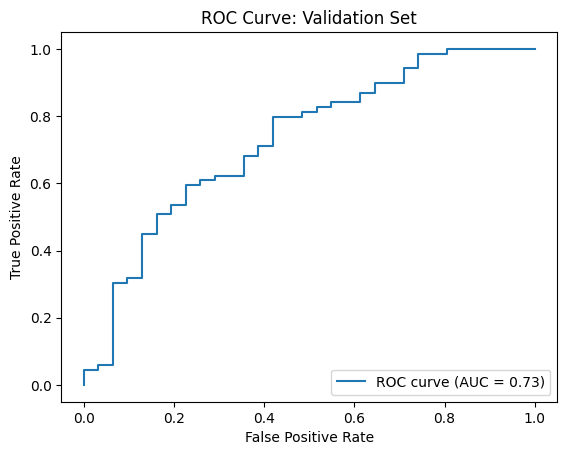

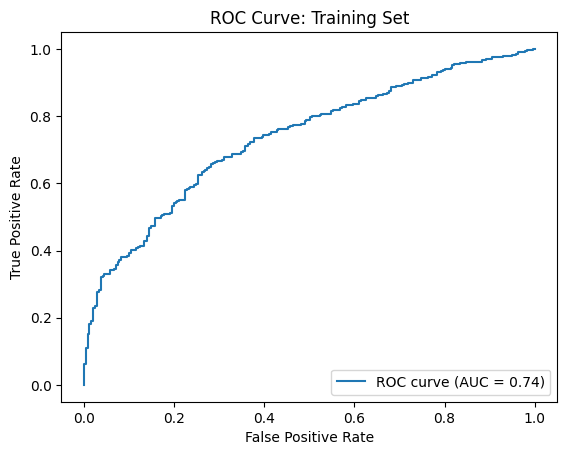

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 10000..................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

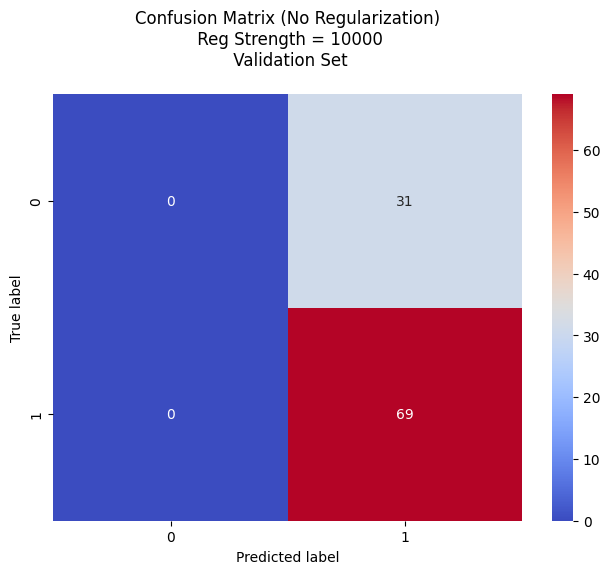

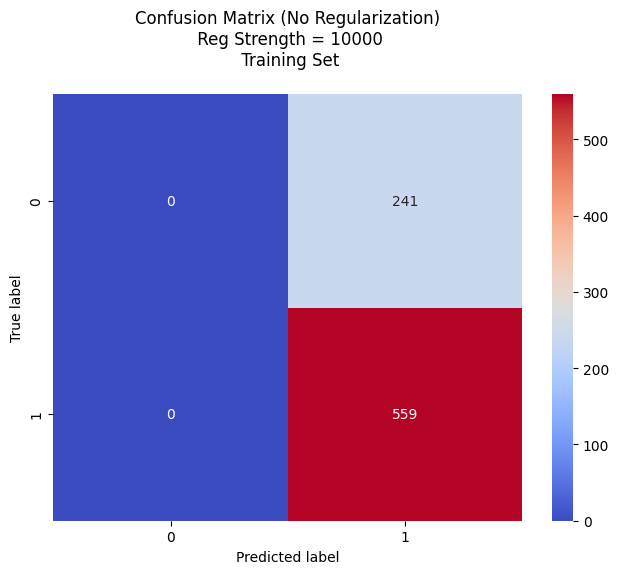

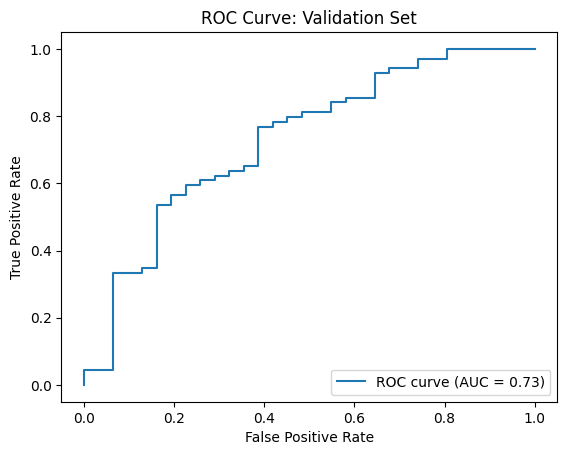

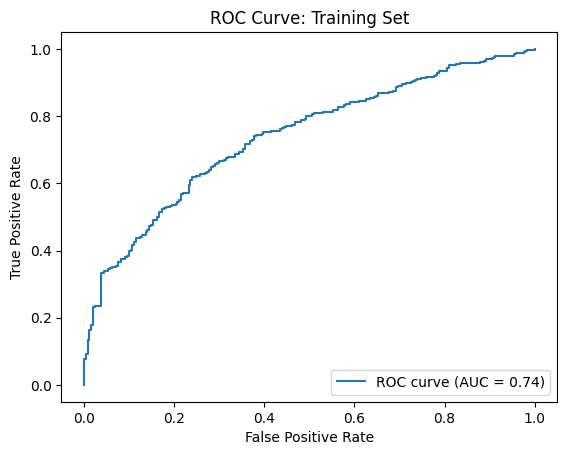

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying Regularisation Inverse Strength C = 1000000..................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

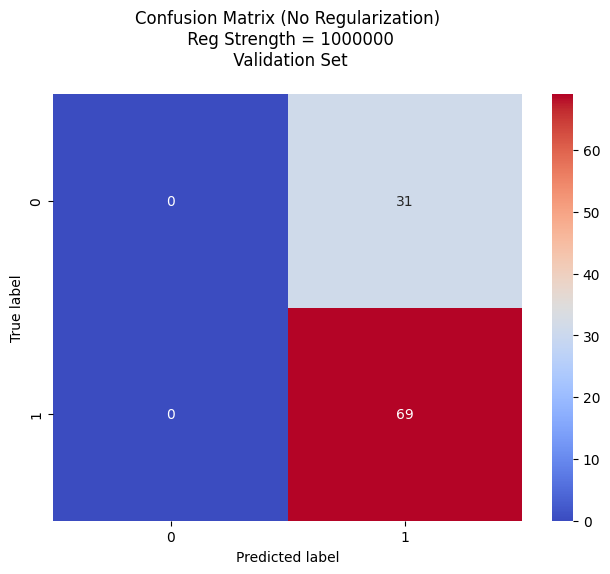

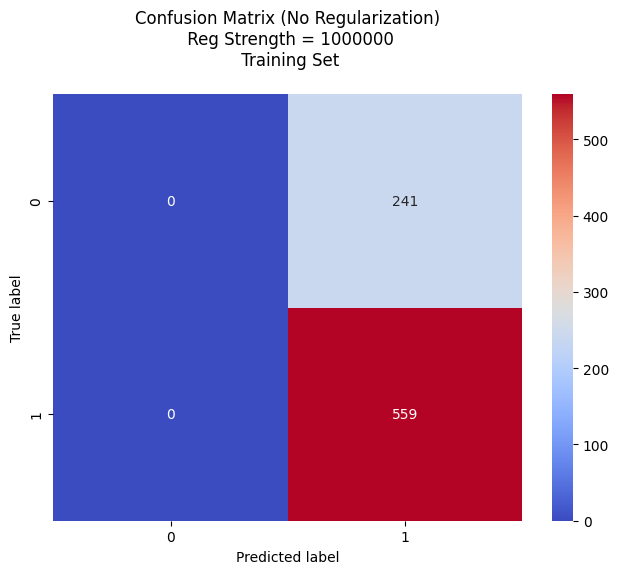

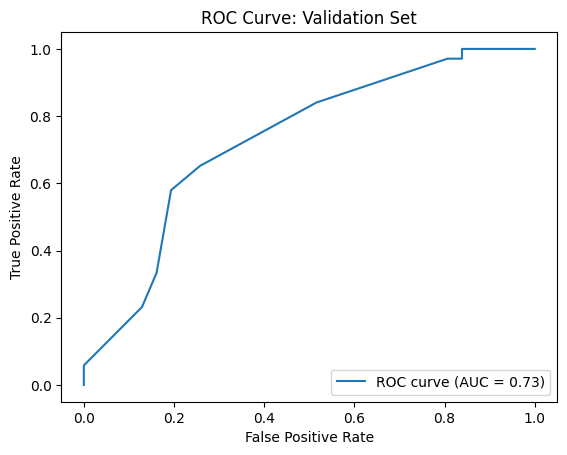

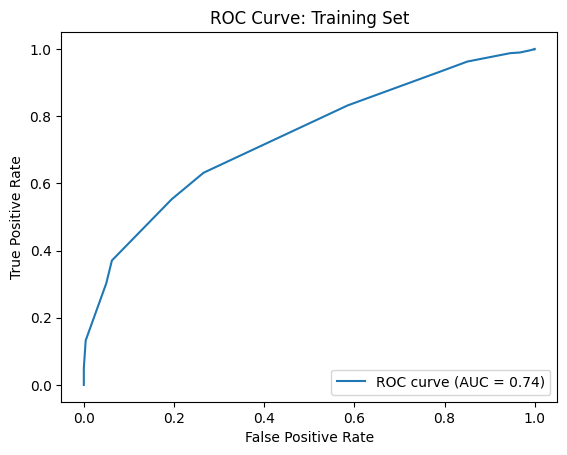

---------------------------------------------------------------------
The best reg_C is 1e-06 with auc = 0.8377746610565685 on validation set.


In [37]:
# [G] Regularization (at least 6 values)
reg_strengths = [ 10**x for x in range(-6,7,2) ]
best_reg_strength = None
best_auc = -1

# Try different values for regularization strength and see how it performs using * VALIDATION * set
# At the end, choose the best and evaluate model performance on testing set
# Use hidden layes = 15 bc it was found to be the best among those we tested
for reg_strength in reg_strengths:
  print("---------------------------------------------------------------------")
  print(f"Trying Regularisation Inverse Strength C = {reg_strength}..................")
  model_regularized = MLPClassifier(hidden_layer_sizes=(10,), alpha=reg_strength, activation='logistic', solver='adam', max_iter=1000)
  model_regularized.fit(X_train, y_train)
  y_predict_regularized = model_regularized.predict(X_val)
  y_predict_regularized_train = model_regularized.predict(X_train)

  # Metrics
  cnf_matrix = get_confusion_matrix(y_val, y_predict_regularized)
  cnf_matrix_train = get_confusion_matrix(y_train, y_predict_regularized_train)

  print("Metrics on validation set:")
  print(f"Confusion Matrix (on validation set):\n {cnf_matrix}")
  display_metrics(y_val, y_predict_regularized, cnf_matrix, target_names=target_names)

  print("Metrics on training set:")
  print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
  display_metrics(y_train, y_predict_regularized_train, cnf_matrix_train, target_names=target_names)


  # Visualize
  visualize_confusion_matrix(cnf_matrix, class_names, f"Confusion Matrix (No Regularization)\n Reg Strength = {reg_strength}\n Validation Set")
  visualize_confusion_matrix(cnf_matrix_train, class_names, f"Confusion Matrix (No Regularization)\n Reg Strength = {reg_strength}\n Training Set")
  y_predict_prob = model_regularized.predict_proba(X_val)[::,1]
  y_predict_prob_train = model_regularized.predict_proba(X_train)[::,1]

  auc = visualize_ROC_plot(y_val, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Validation Set")
  visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")

  if auc > best_auc:
    best_auc = auc
    best_reg_strength = reg_strength

  print("---------------------------------------------------------------------")

print(f"The best reg_C is {best_reg_strength} with auc = {best_auc} on validation set.")

The best reg_C is 1e-06


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Confusion Matrix, Reg Strength C=1e-06:
 [[11 17]
 [11 61]]
                  precision    recall  f1-score   support

 bad credit risk       0.50      0.39      0.44        28
good credit risk       0.78      0.85      0.81        72

        accuracy                           0.72       100
       macro avg       0.64      0.62      0.63       100
    weighted avg       0.70      0.72      0.71       100



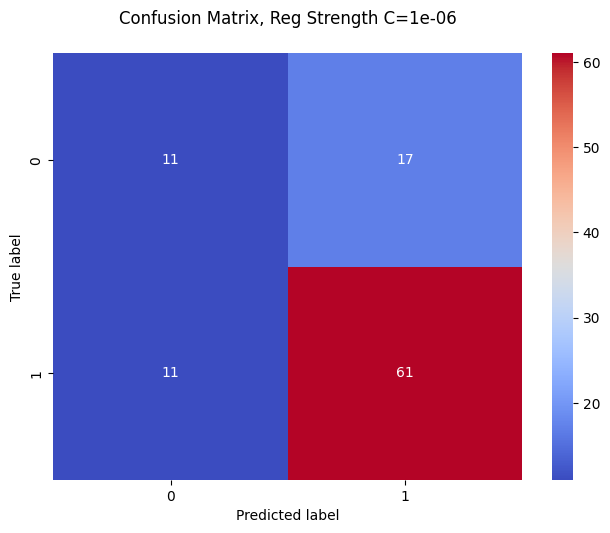

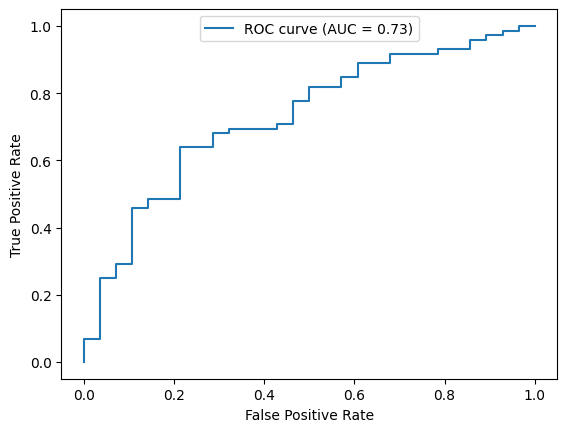

In [38]:
# [G] - regularization cont.
print(f"The best reg_C is {best_reg_strength}")

# Train the model (15 hidden layers) one last time with best regularization strength and test on test set
model_final = MLPClassifier(hidden_layer_sizes=(15,), alpha=best_reg_strength, activation='logistic', solver='adam', max_iter=1000)
model_final.fit(X_train, y_train)
y_predict_final = model_final.predict(X_test)

# Confusion Matrix
cnf_matrix_final = metrics.confusion_matrix(y_test, y_predict_final)
print(f"Confusion Matrix, Reg Strength C={best_reg_strength}:\n {cnf_matrix_final}")

# Evaluation Metrics
print(metrics.classification_report(y_test, y_predict_final, target_names=target_names))

# Visualize
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_final), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title(f"Confusion Matrix, Reg Strength C={best_reg_strength}", y=1.05)
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Visualize ROC curve
plt.figure()
y_predict_final_prob = model_final.predict_proba(X_test)[::,1]
y_test_numeric = y_test.replace({'bad': 0, 'good': 1})
fpr, tpr, _ = metrics.roc_curve(y_test_numeric,  y_predict_final_prob)
auc = metrics.roc_auc_score(y_test_numeric, y_predict_final_prob)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=9)
plt.show()

# SECTION [G] DONE ✅ (Everything Finished)

---------------------------------------------------------------------
Trying learning rate = 1e-05............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
       macro avg       0.35      0.50      0.41       800
    weighted avg 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

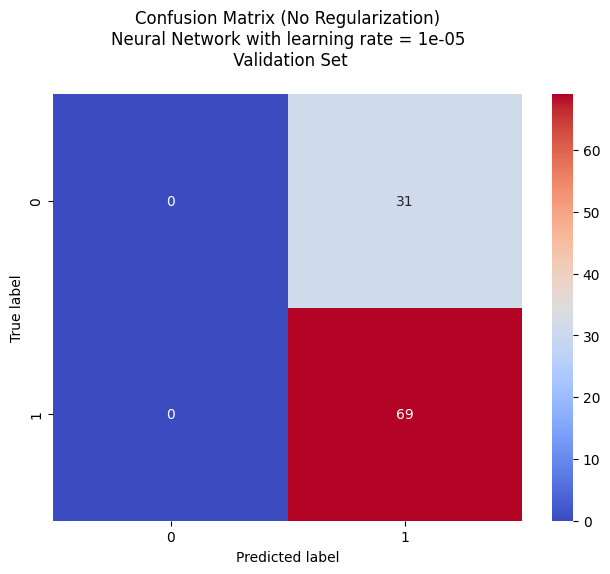

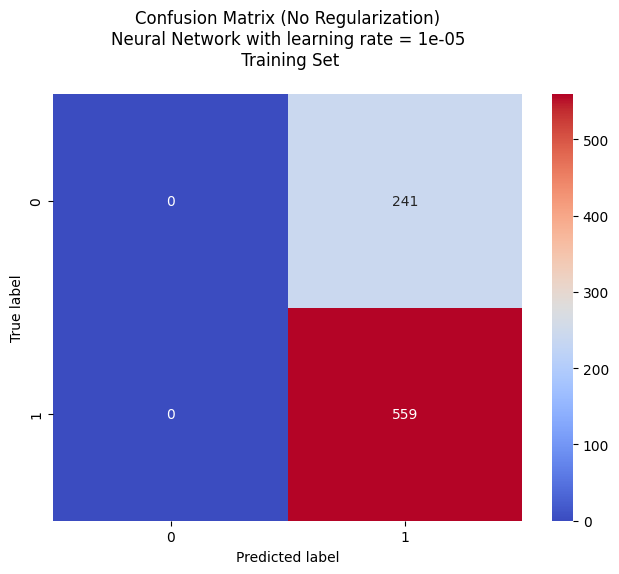

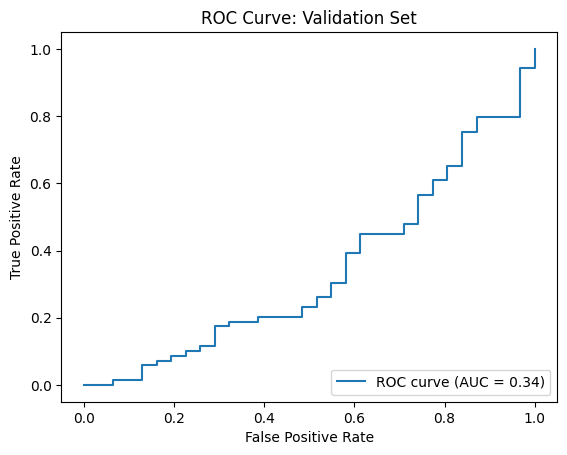

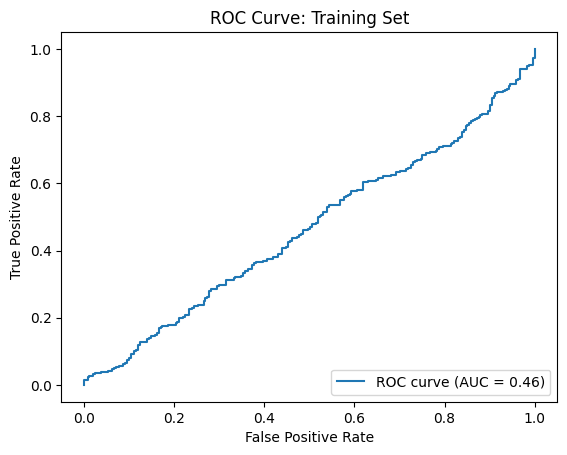

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 0.001............................


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on validation set:
Confusion Matrix (on validation set):
 [[18 13]
 [10 59]]
                  precision    recall  f1-score   support

 bad credit risk       0.64      0.58      0.61        31
good credit risk       0.82      0.86      0.84        69

        accuracy                           0.77       100
       macro avg       0.73      0.72      0.72       100
    weighted avg       0.76      0.77      0.77       100

Accuracy: 0.77
Recall: 0.86
Precision: 0.82
Metrics on training set:
Confusion Matrix (on training set):
 [[140 101]
 [ 43 516]]
                  precision    recall  f1-score   support

 bad credit risk       0.77      0.58      0.66       241
good credit risk       0.84      0.92      0.88       559

        accuracy                           0.82       800
       macro avg       0.80      0.75      0.77       800
    weighted avg       0.81      0.82      0.81       800

Accuracy: 0.82
Recall: 0.92
Precision: 0.84
----------------------------------------

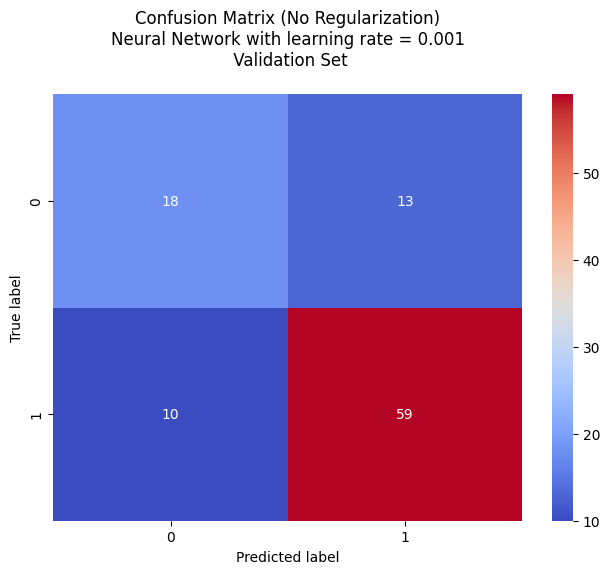

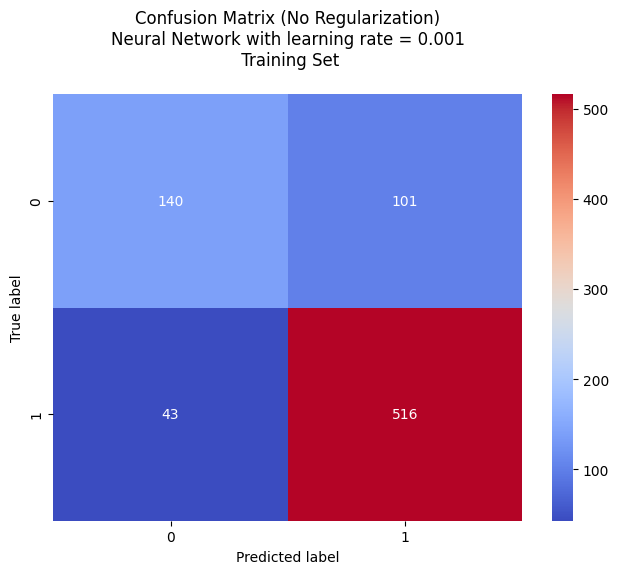

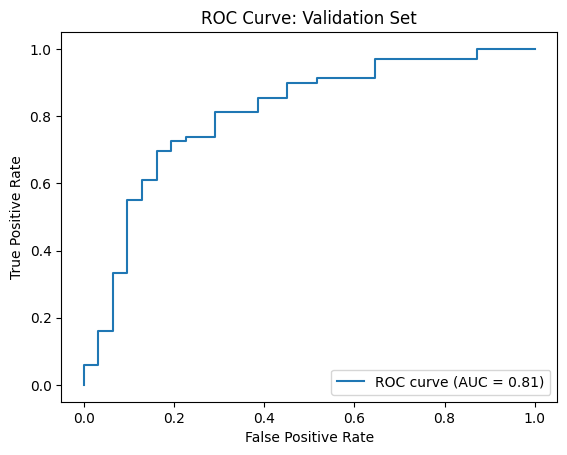

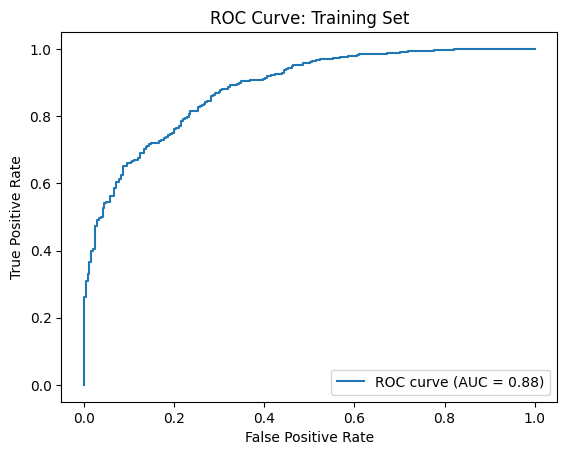

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 0.1............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[16 15]
 [17 52]]
                  precision    recall  f1-score   support

 bad credit risk       0.48      0.52      0.50        31
good credit risk       0.78      0.75      0.76        69

        accuracy                           0.68       100
       macro avg       0.63      0.63      0.63       100
    weighted avg       0.69      0.68      0.68       100

Accuracy: 0.68
Recall: 0.75
Precision: 0.78
Metrics on training set:
Confusion Matrix (on training set):
 [[236   5]
 [  6 553]]
                  precision    recall  f1-score   support

 bad credit risk       0.98      0.98      0.98       241
good credit risk       0.99      0.99      0.99       559

        accuracy                           0.99       800
      

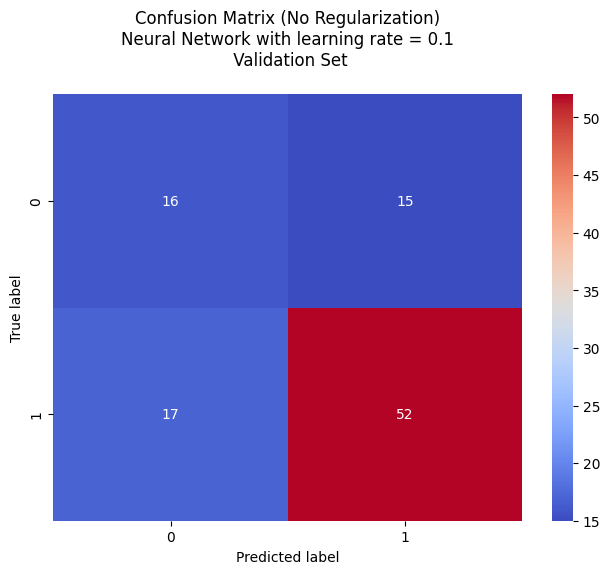

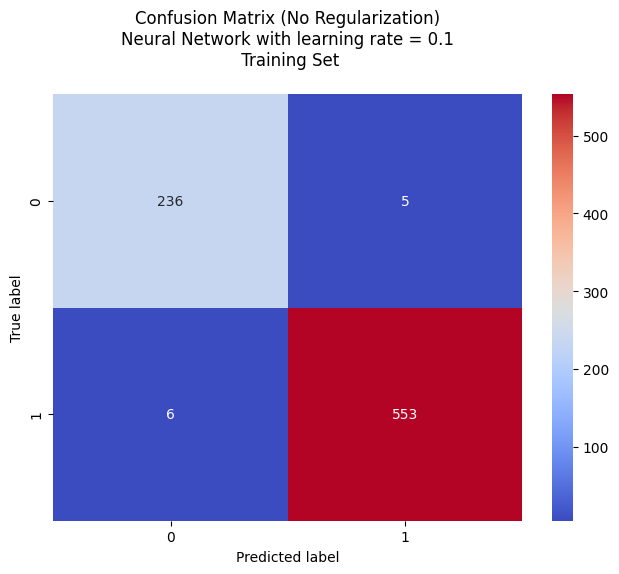

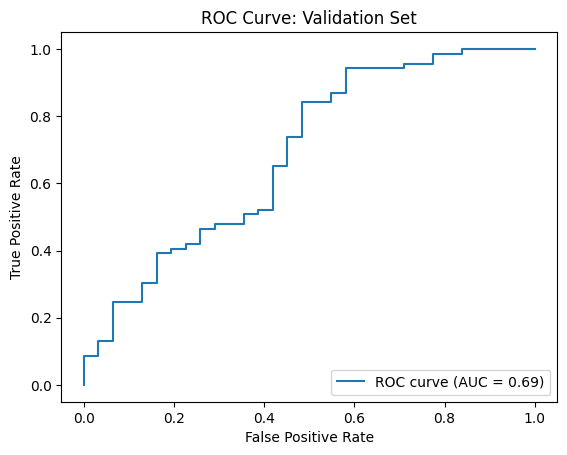

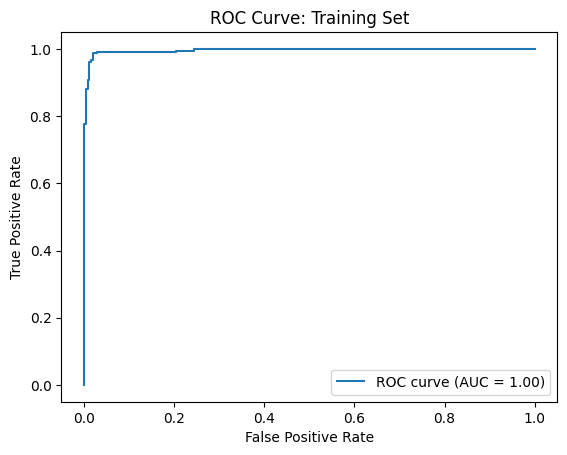

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 10............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 2 67]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.68      0.97      0.80        69

        accuracy                           0.67       100
       macro avg       0.34      0.49      0.40       100
    weighted avg       0.47      0.67      0.55       100

Accuracy: 0.67
Recall: 0.97
Precision: 0.68
Metrics on training set:
Confusion Matrix (on training set):
 [[  8 233]
 [  5 554]]
                  precision    recall  f1-score   support

 bad credit risk       0.62      0.03      0.06       241
good credit risk       0.70      0.99      0.82       559

        accuracy                           0.70       800
       

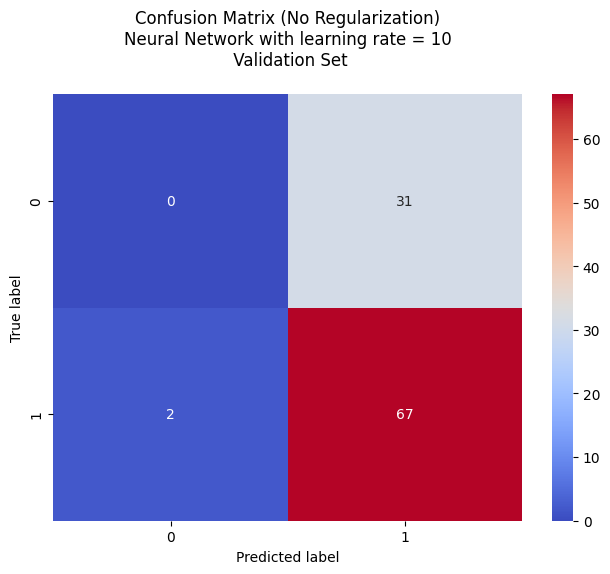

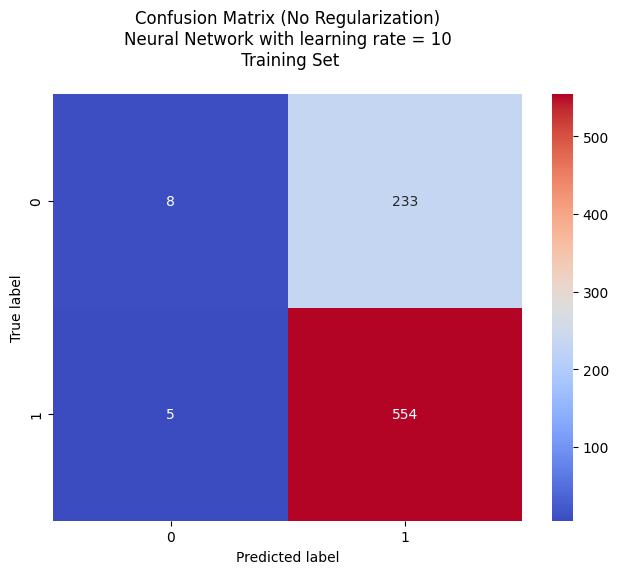

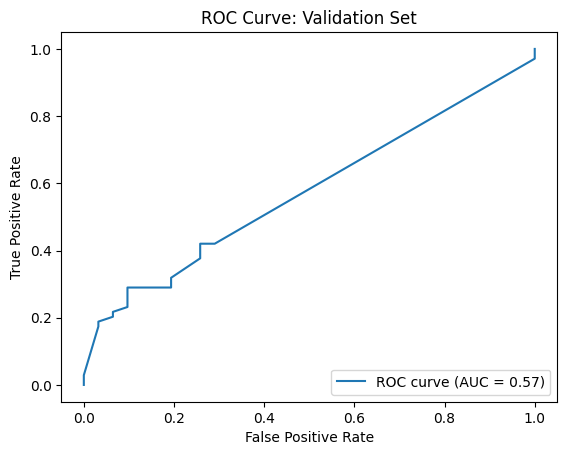

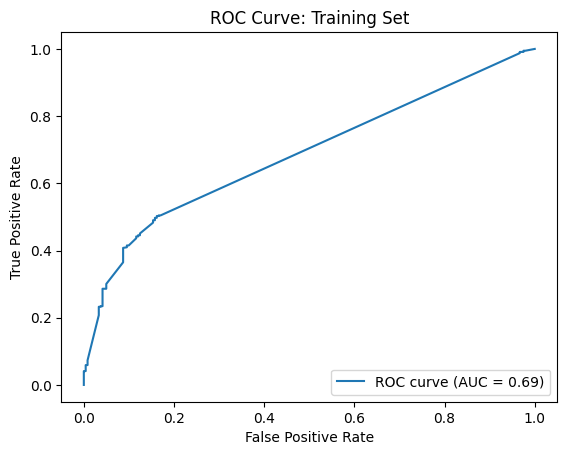

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 1000............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 1 30]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       1.00      0.03      0.06        31
good credit risk       0.70      1.00      0.82        69

        accuracy                           0.70       100
       macro avg       0.85      0.52      0.44       100
    weighted avg       0.79      0.70      0.59       100

Accuracy: 0.70
Recall: 1.0
Precision: 0.7
Metrics on training set:
Confusion Matrix (on training set):
 [[  2 239]
 [  2 557]]
                  precision    recall  f1-score   support

 bad credit risk       0.50      0.01      0.02       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
       

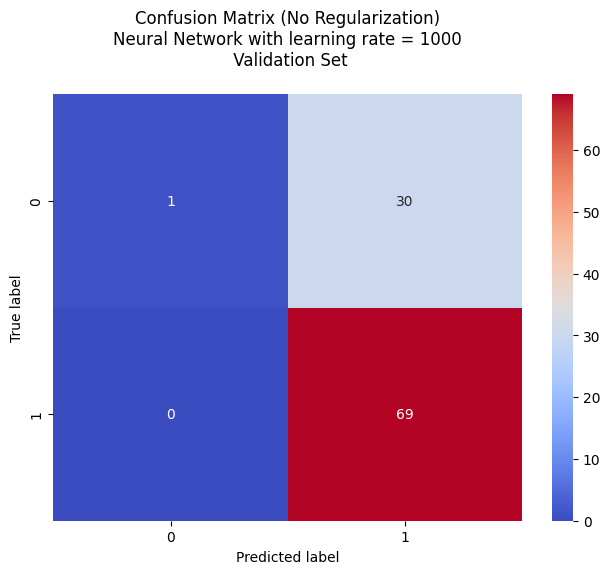

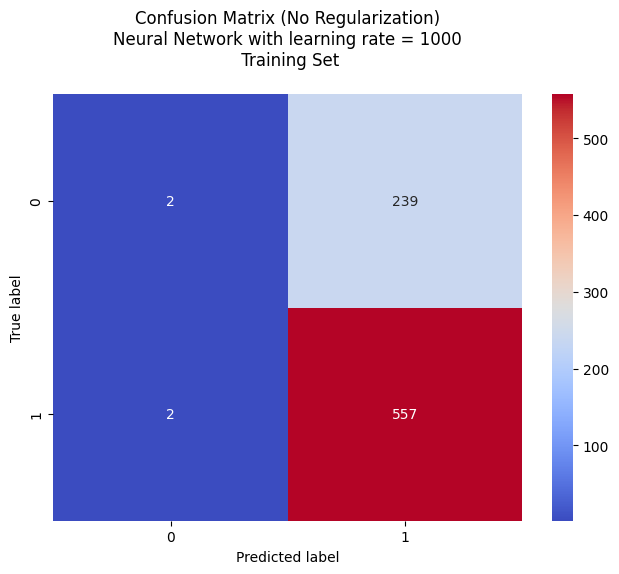

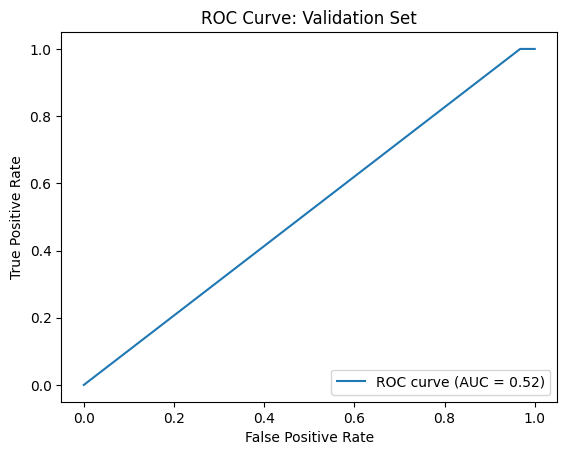

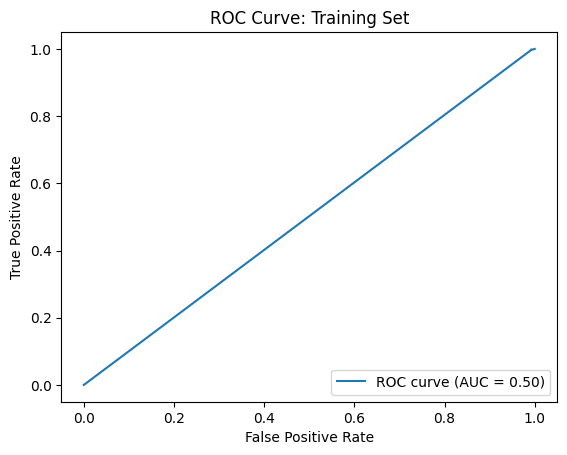

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 100000............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

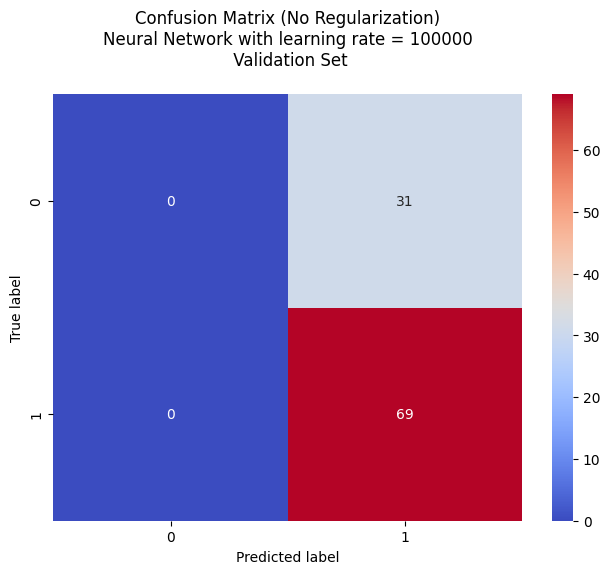

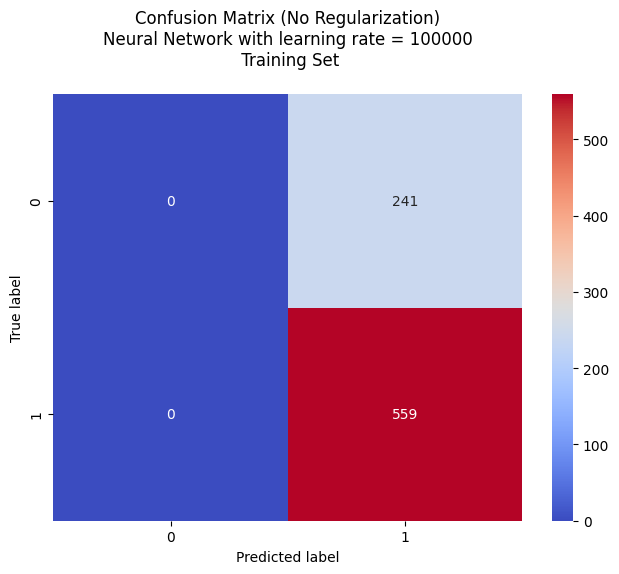

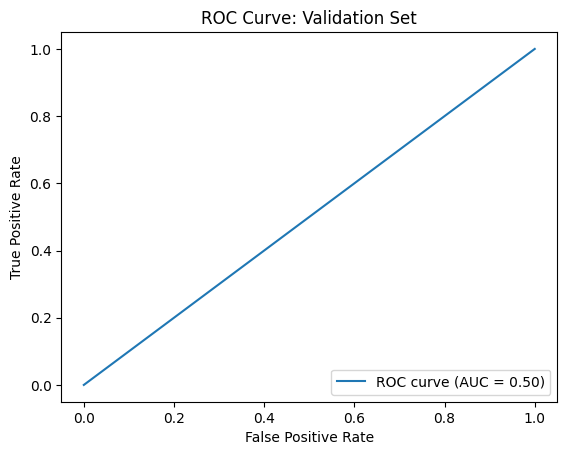

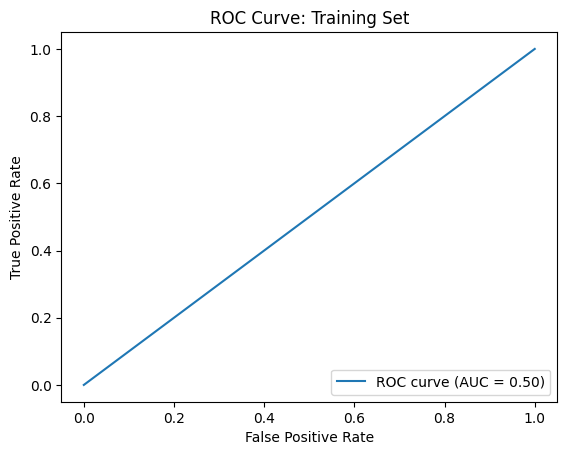

---------------------------------------------------------------------
---------------------------------------------------------------------
Trying learning rate = 10000000............................
Metrics on validation set:
Confusion Matrix (on validation set):
 [[ 0 31]
 [ 0 69]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00        31
good credit risk       0.69      1.00      0.82        69

        accuracy                           0.69       100
       macro avg       0.34      0.50      0.41       100
    weighted avg       0.48      0.69      0.56       100

Accuracy: 0.69
Recall: 1.0
Precision: 0.69
Metrics on training set:
Confusion Matrix (on training set):
 [[  0 241]
 [  0 559]]
                  precision    recall  f1-score   support

 bad credit risk       0.00      0.00      0.00       241
good credit risk       0.70      1.00      0.82       559

        accuracy                           0.70       800
  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

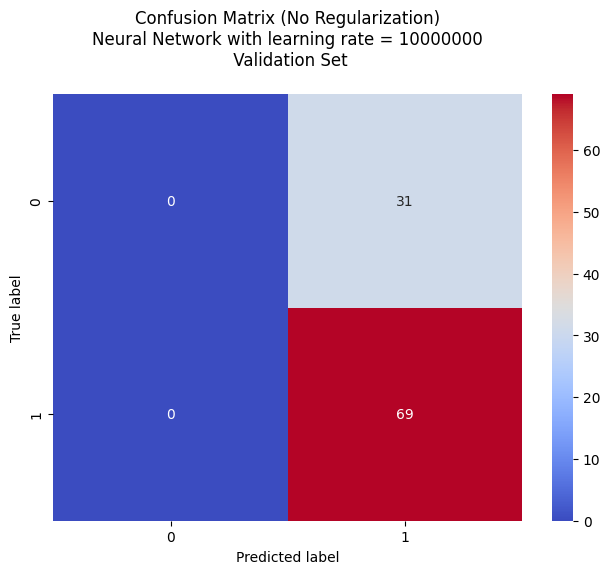

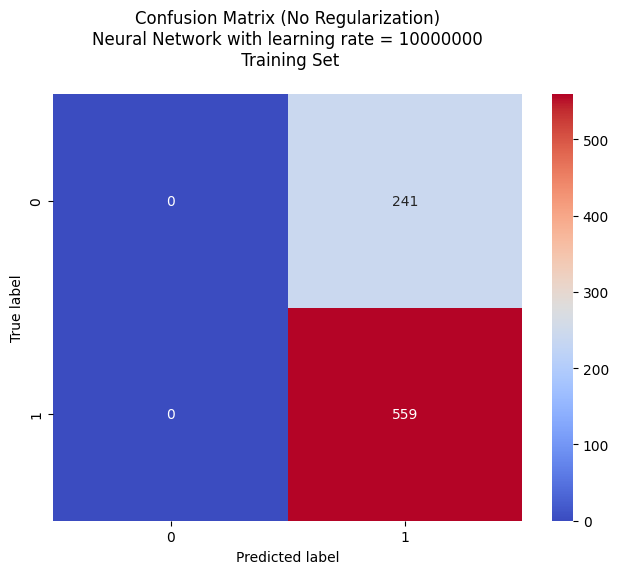

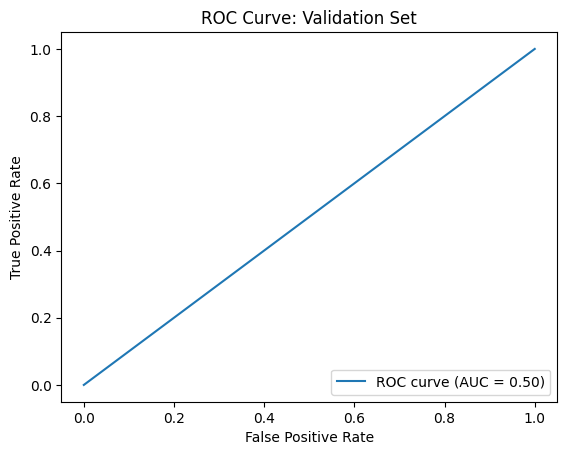

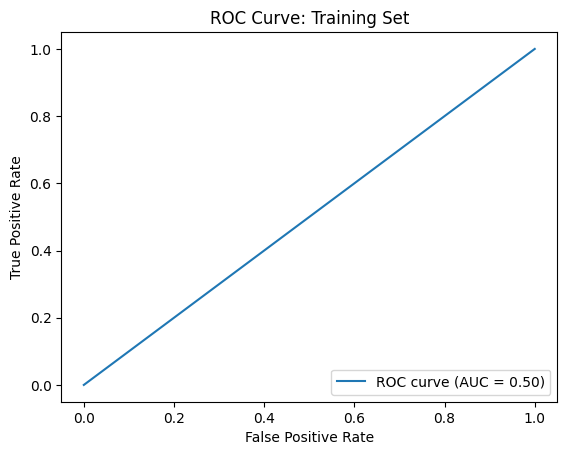

---------------------------------------------------------------------
The best learning rate is 0.001 with auc = 0.8064516129032259 on validation set.


In [39]:
# [H] Hyperparameter: testing different learning rates
learning_rates = [ 10**x for x in range(-5, 8, 2) ]

best_learning_rate = 10**-5
best_auc_for_learning_rate = -1

# Use 2 hidden layers for simplicity
# Evalute on the validation set
for i in range(len(learning_rates)):
  learning_rate = learning_rates[i]
  print("---------------------------------------------------------------------")
  print(f"Trying learning rate = {learning_rate}............................")
  model = MLPClassifier(hidden_layer_sizes=(10,), alpha=0.000001, activation='logistic', solver='adam', max_iter=1000, learning_rate='constant', learning_rate_init=learning_rate)
  model.fit(X_train, y_train)
  y_predict = model.predict(X_val)
  y_predict_train = model.predict(X_train)

  # Metrics
  cnf_matrix = get_confusion_matrix(y_val, y_predict)
  cnf_matrix_train = get_confusion_matrix(y_train, y_predict_train)

  print("Metrics on validation set:")
  print(f"Confusion Matrix (on validation set):\n {cnf_matrix}")
  display_metrics(y_val, y_predict, cnf_matrix, target_names=target_names)

  print("Metrics on training set:")
  print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
  display_metrics(y_train, y_predict_train, cnf_matrix_train, target_names=target_names)

  print("--------------------------------------------------------")

  # Visualize
  visualize_confusion_matrix(cnf_matrix, class_names, f"Confusion Matrix (No Regularization)\nNeural Network with learning rate = {learning_rate}\n Validation Set")
  visualize_confusion_matrix(cnf_matrix_train, class_names, f"Confusion Matrix (No Regularization)\nNeural Network with learning rate = {learning_rate}\n Training Set")
  y_predict_prob = model.predict_proba(X_val)[::,1]
  y_predict_prob_train = model.predict_proba(X_train)[::,1]

  auc = visualize_ROC_plot(y_val, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Validation Set")
  visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")

  if auc > best_auc_for_learning_rate:
    best_auc_for_learning_rate = auc
    best_learning_rate = learning_rate

  print("---------------------------------------------------------------------")

print(f"The best learning rate is {best_learning_rate} with auc = {best_auc_for_learning_rate} on validation set.")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Metrics on test set:
Confusion Matrix (on test set):
 [[11 17]
 [11 61]]
                  precision    recall  f1-score   support

 bad credit risk       0.50      0.39      0.44        28
good credit risk       0.78      0.85      0.81        72

        accuracy                           0.72       100
       macro avg       0.64      0.62      0.63       100
    weighted avg       0.70      0.72      0.71       100

Accuracy: 0.72
Recall: 0.85
Precision: 0.78
Metrics on training set:
Confusion Matrix (on training set):
 [[161  80]
 [ 44 515]]
                  precision    recall  f1-score   support

 bad credit risk       0.79      0.67      0.72       241
good credit risk       0.87      0.92      0.89       559

        accuracy                           0.84       800
       macro avg       0.83      0.79      0.81       800
    weighted avg       0.84      0.84      0.84       800

Accuracy: 0.84
Recall: 0.92
Precision: 0.87


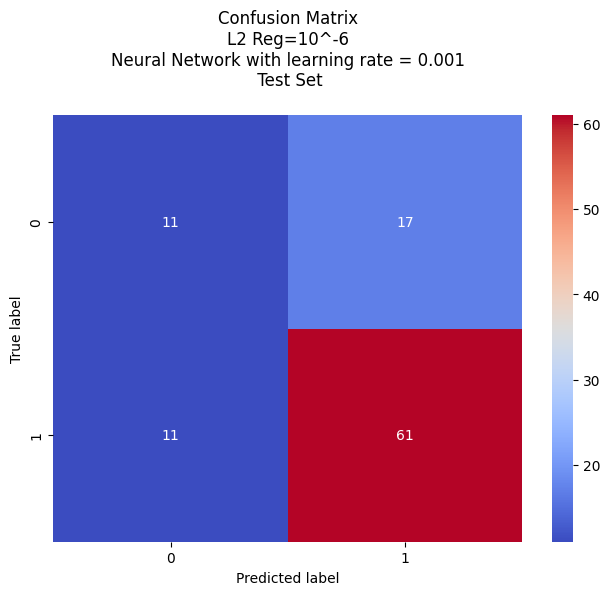

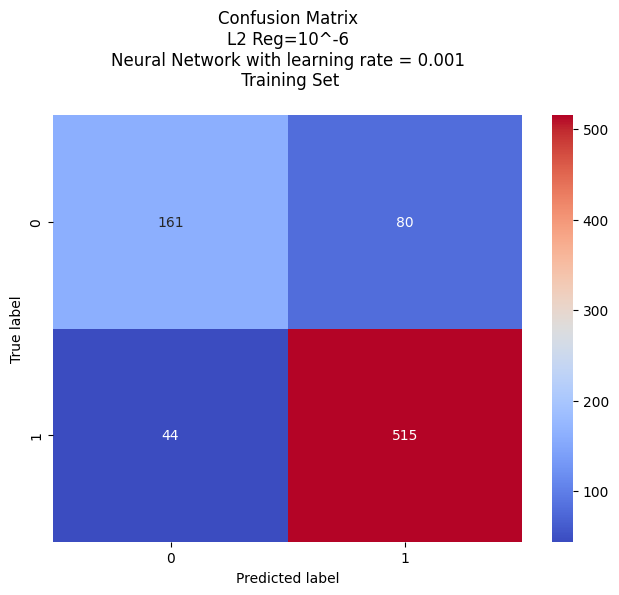

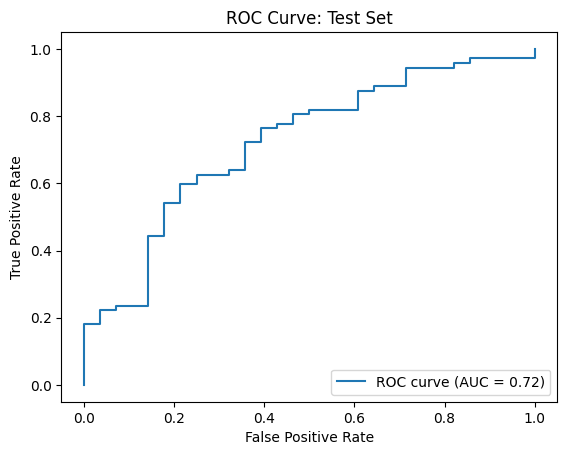

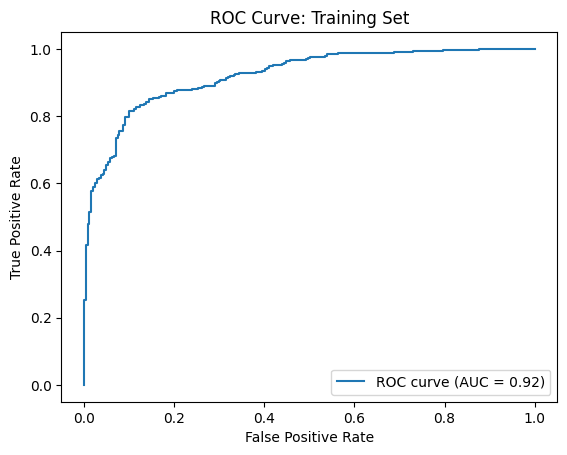

0.9209762542774218

In [40]:
# [I] Final Model with best everything - test it on the test set

# print(f"Best regularization strength (L2): {best_reg_strength}")
# print(f"Best learning rate: {best_learning_rate}")
# print(f"Best number of hidden layers: {best_hidden_layers}")
# print(f"Best regularization: NO regularization")


model = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=1000, learning_rate='constant', learning_rate_init=0.001, alpha=0.000001)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_predict_train = model.predict(X_train)

# Metrics
cnf_matrix = get_confusion_matrix(y_test, y_predict)
cnf_matrix_train = get_confusion_matrix(y_train, y_predict_train)

print("Metrics on test set:")
print(f"Confusion Matrix (on test set):\n {cnf_matrix}")
display_metrics(y_test, y_predict, cnf_matrix, target_names=target_names)

print("Metrics on training set:")
print(f"Confusion Matrix (on training set):\n {cnf_matrix_train}")
display_metrics(y_train, y_predict_train, cnf_matrix_train, target_names=target_names)

# Visualize
visualize_confusion_matrix(cnf_matrix, class_names, f"Confusion Matrix\nL2 Reg=10^-6\nNeural Network with learning rate = 0.001\n Test Set")
visualize_confusion_matrix(cnf_matrix_train, class_names, f"Confusion Matrix\nL2 Reg=10^-6\nNeural Network with learning rate = 0.001\n Training Set")
y_predict_prob = model.predict_proba(X_test)[::,1]
y_predict_prob_train = model.predict_proba(X_train)[::,1]

visualize_ROC_plot(y_test, y_predict_prob, class_mapping=class_mapping, title="ROC Curve: Test Set")
visualize_ROC_plot(y_train, y_predict_prob_train, class_mapping=class_mapping, title="ROC Curve: Training Set")
